# Chapter 13 - Models with Memory

- Most models so far 'forget' everything about previous clusters of data as soon as they move on to the next
- They have 'anterograde amnesia'
- Say you have a robot going to cafes and ordering coffee. They want to estimate the wait times. Say they start with a prior of 5 minutes and an sd of 1 minute. Then they order coffee at one cafe, and it takes 4 minutes. They update their prior and move on to the next cafe. What should the prior at this cafe be? We kind of want to estimate parameters for *each* cafe as well as parameters for the population of cafes as a whole. As the robot goes to the cafes, it should update both the population-level and cafe-level parameters, using the population level as the prior for each new cafe. If the cafes are all different this will not provide much information, but if they are all similar then it provides a lot of information!
- The formal version of this argument leads us to **multilevel models**
- They 'remember' features of each cluster as they learn about all of the clusters
- Tends to improve estimates about each cluster
- Several other benefits:
1. Improved estimates for repeat sampling. When multiple observations arise from the same individual (or whatever), single-level models tend to underfit / overfit the model
1. Improved estimates for imbalances in sampling. When some individuals are sampled more than others, multilevel models automatically cope with this. This provents over-sampled clusters for unfairly dominating inferences.
1. Estimates of variance. If our research questions include variation among individuals or other groups within the data, then multilevel models are a big help because they model variation explicitly.
1. Acoid averaging, retain variation. Frequently, people average some value to construct variables. This can be dangerous because the averaging removes information about the variation. Also, there are several different ways to construct the average. **Multilevel models** allow us to preserve uncertainty and avoid data transformations.

In general, there is a strong argument that multilevel models should be the default over single-level ones.

Of course, there are some downsides.
1. New assumptions. We need to define the distributions from which the characteristics of the cluster arise.
1. Challenges with estimation. Apparently this is harder than with a single-level model?
1. Difficult to understand. Multilevel models make predictions at different levels of the model, and so can be difficult to interpret.

**Multilevel models** are also called **Hierarchical models** or **Mixed effects models**. The type of parameters that appear in the models are sometimes known as **random effects**. There is a lot of vocabulary around this and it is frequently inconsistently used - basically you often need to look at the actual math to figure out what is going on!

## Example: multilevel tadpoles

We'll look at frog mortality.

In [1]:
library(rethinking)
library(ggplot2)
library(rstan)

options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

options(repr.plot.width = 17, repr.plot.height = 8)

Loading required package: cmdstanr

This is cmdstanr version 0.8.1

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /Users/ericr/.cmdstan/cmdstan-2.35.0

- CmdStan version: 2.35.0

Loading required package: posterior

This is posterior version 1.6.0


Attaching package: ‘posterior’


The following objects are masked from ‘package:stats’:

    mad, sd, var


The following objects are masked from ‘package:base’:

    %in%, match


Loading required package: parallel

rethinking (Version 2.40)


Attaching package: ‘rethinking’


The following object is masked from ‘package:stats’:

    rstudent


Loading required package: StanHeaders


rstan version 2.32.6 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_re

In [2]:
data(reedfrogs)
d <- reedfrogs
str(d)

'data.frame':	48 obs. of  5 variables:
 $ density : int  10 10 10 10 10 10 10 10 10 10 ...
 $ pred    : Factor w/ 2 levels "no","pred": 1 1 1 1 1 1 1 1 2 2 ...
 $ size    : Factor w/ 2 levels "big","small": 1 1 1 1 2 2 2 2 1 1 ...
 $ surv    : int  9 10 7 10 9 9 10 9 4 9 ...
 $ propsurv: num  0.9 1 0.7 1 0.9 0.9 1 0.9 0.4 0.9 ...


We're interested in the number surviving (`surv`) out of the initial population (`density`).

We can think of each row as a 'tank' containing some tadpoles. There are a lot of thinkgs that are unique to each tank, so even when all of our recorded predictor variables are the same there are still differences. These tanks are an example of a 'cluster', and we make multiple observations within each cluster.

If we ignore the clusering and assign the same intercept to each, we ignore important variation in the baseline survival.

If we go the other direction and assign a unique intercept to each tank, then we practice 'anterograde amnesia' - information from tank within the same cluster should really inform our views. Each tank is different, but knowing information about one tank should also give us information about other tanks in the same cluster.

We want a multilevel model, where we will simulatenously estimate both an intercept for *each* tank and a variation *among tanks*. This will be a [[Varying Intercepts Model]]. Varying intercepts are the simplest kind of [[Varying Effect Model]]. For each cluster in the data, we use a unique intercept parameter. This is essentially the same as the categorical variable model from earlier, but now we are also adaptively learning the prior that is common to the intercepts.

Here's the model for predicting tadpole mortality:

$$
\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{TANK}[i]} \\
\alpha_j &\sim \text{Normal}(0, 1.5) & \text{for $j = 1\dots 48$}
\end{align*}
$$

In [3]:
# tank cluster variable
d$tank <- 1:nrow(d)

dat <- list(
    S = d$surv,
    N = d$density,
    tank = d$tank
)

m13.1 <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank],
        a[tank] ~ dnorm(0, 1.5)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

mean        sd        5.5%        94.5%        rhat      ess_bulk
a[1]   1.70049950 0.7497252  0.59887018  2.975501850 1.0022289 4889.511
a[2]   2.39518204 0.8876435  1.06426105  3.930386750 1.0048374 4655.833
a[3]   0.75640364 0.6306012 -0.19681222  1.788293300 1.0048841 4160.963
a[4]   2.38356397 0.8684106  1.11627085  3.822064950 1.0000318 5400.087
a[5]   1.69594537 0.7583699  0.57999923  2.998542100 1.0028963 4331.713
a[6]   1.71122167 0.7363207  0.57281489  2.955731450 0.9991404 4016.962
a[7]   2.38899473 0.9123562  1.03610515  3.948461200 1.0053820 4172.170
a[8]   1.71372195 0.7340980  0.58567738  2.985565450 1.0046840 3330.060
a[9]  -0.38094600 0.6181678 -1.38565050  0.603662830 1.0027876 3984.459
a[10]  1.72310683 0.8126847  0.51113849  3.093611850 1.0042392 3214.386
a[11]  0.74239817 0.6145996 -0.21912968  1.729549100 1.0038181 4787.070
a[12]  0.36779522 0.5881692 -0.52664893  1.297336600 1.0014061 5254.104
a[13]  0.76343334 0.6263288 -0.19819923  1.796871650 1.0041913 5228.821
a[14]  0.01954581 0.5841969 -0.93606455  0.939591940 1.0049121 5817.342
a[15]  1.70949390 0.7547426  0.56800733  2.994540950 1.0024950 4341.449
a[16]  1.73520113 0.7487890  0.61776586  2.992198100 1.0020416 4315.823
a[17]  2.52971530 0.6377864  1.57803810  3.596058500 1.0016941 4681.037
a[18]  2.13772481 0.6087378  1.22904295  3.141571300 1.0069333 4777.709
a[19]  1.81810045 0.5604278  0.96183403  2.753333850 1.0014860 5290.065
a[20]  3.07671203 0.7825060  1.97118425  4.440145500 1.0017148 4706.840
a[21]  2.14771465 0.5951666  1.26815465  3.165760200 1.0061698 4827.711
a[22]  2.14409686 0.6256160  1.21389430  3.145202100 1.0008013 6602.060
a[23]  2.15442374 0.6014744  1.27542770  3.173858150 1.0032253 3846.463
a[24]  1.53726624 0.5253774  0.73053575  2.437899250 1.0011781 4762.780
a[25] -1.09762863 0.4358341 -1.82144575 -0.411782295 0.9990513 4586.819
a[26]  0.07148796 0.3930504 -0.51436716  0.675233055 1.0049674 4712.190
a[27] -1.54921715 0.4900185 -2.34879410 -0.786765915 1.0037255 5115.843
a[28] -0.55985854 0.4134748 -1.23690195  0.085239247 1.0045258 5233.299
a[29]  0.08064254 0.3963550 -0.53698910  0.721634190 1.0014990 5547.496
a[30]  1.30491775 0.4581103  0.60749076  2.078997100 1.0015329 6247.562
a[31] -0.72625624 0.4044059 -1.38033420 -0.097516358 1.0042292 5340.167
a[32] -0.39313426 0.4086365 -1.04187610  0.250583270 0.9993788 5578.839
a[33]  2.85396841 0.6585512  1.87070620  3.913768050 1.0033343 3776.145
a[34]  2.48506977 0.5990868  1.57997330  3.472322100 1.0064588 4546.533
a[35]  2.45485111 0.5878307  1.59663395  3.462075700 0.9997085 5028.903
a[36]  1.90380406 0.4782167  1.18059355  2.698417900 0.9996165 5357.651
a[37]  1.90285691 0.4705635  1.17743465  2.676869000 1.0004010 3653.147
a[38]  3.36315848 0.8060520  2.21079635  4.800772050 1.0067639 5101.424
a[39]  2.46614807 0.5643787  1.63177055  3.389822350 1.0044997 4593.130
a[40]  2.16239378 0.5206009  1.38778770  3.045046250 0.9993820 3638.898
a[41] -1.91896826 0.4920083 -2.75053900 -1.152667450 1.0009009 4259.936
a[42] -0.63372891 0.3477850 -1.19529870 -0.098636503 1.0050435 5039.642
a[43] -0.51291731 0.3322768 -1.06292195 -0.008861441 1.0022415 6033.443
a[44] -0.39507784 0.3340188 -0.92250193  0.129665570 1.0036692 5041.826
a[45]  0.51107729 0.3459851 -0.03346051  1.050289950 1.0038981 3709.977
a[46] -0.63422062 0.3534991 -1.23101430 -0.048508704 1.0033814 5914.009
a[47]  1.89916617 0.4916798  1.16933495  2.721762950 1.0074324 5427.145
a[48] -0.05647789 0.3286388 -0.58419263  0.469143990 1.0000265 5573.941

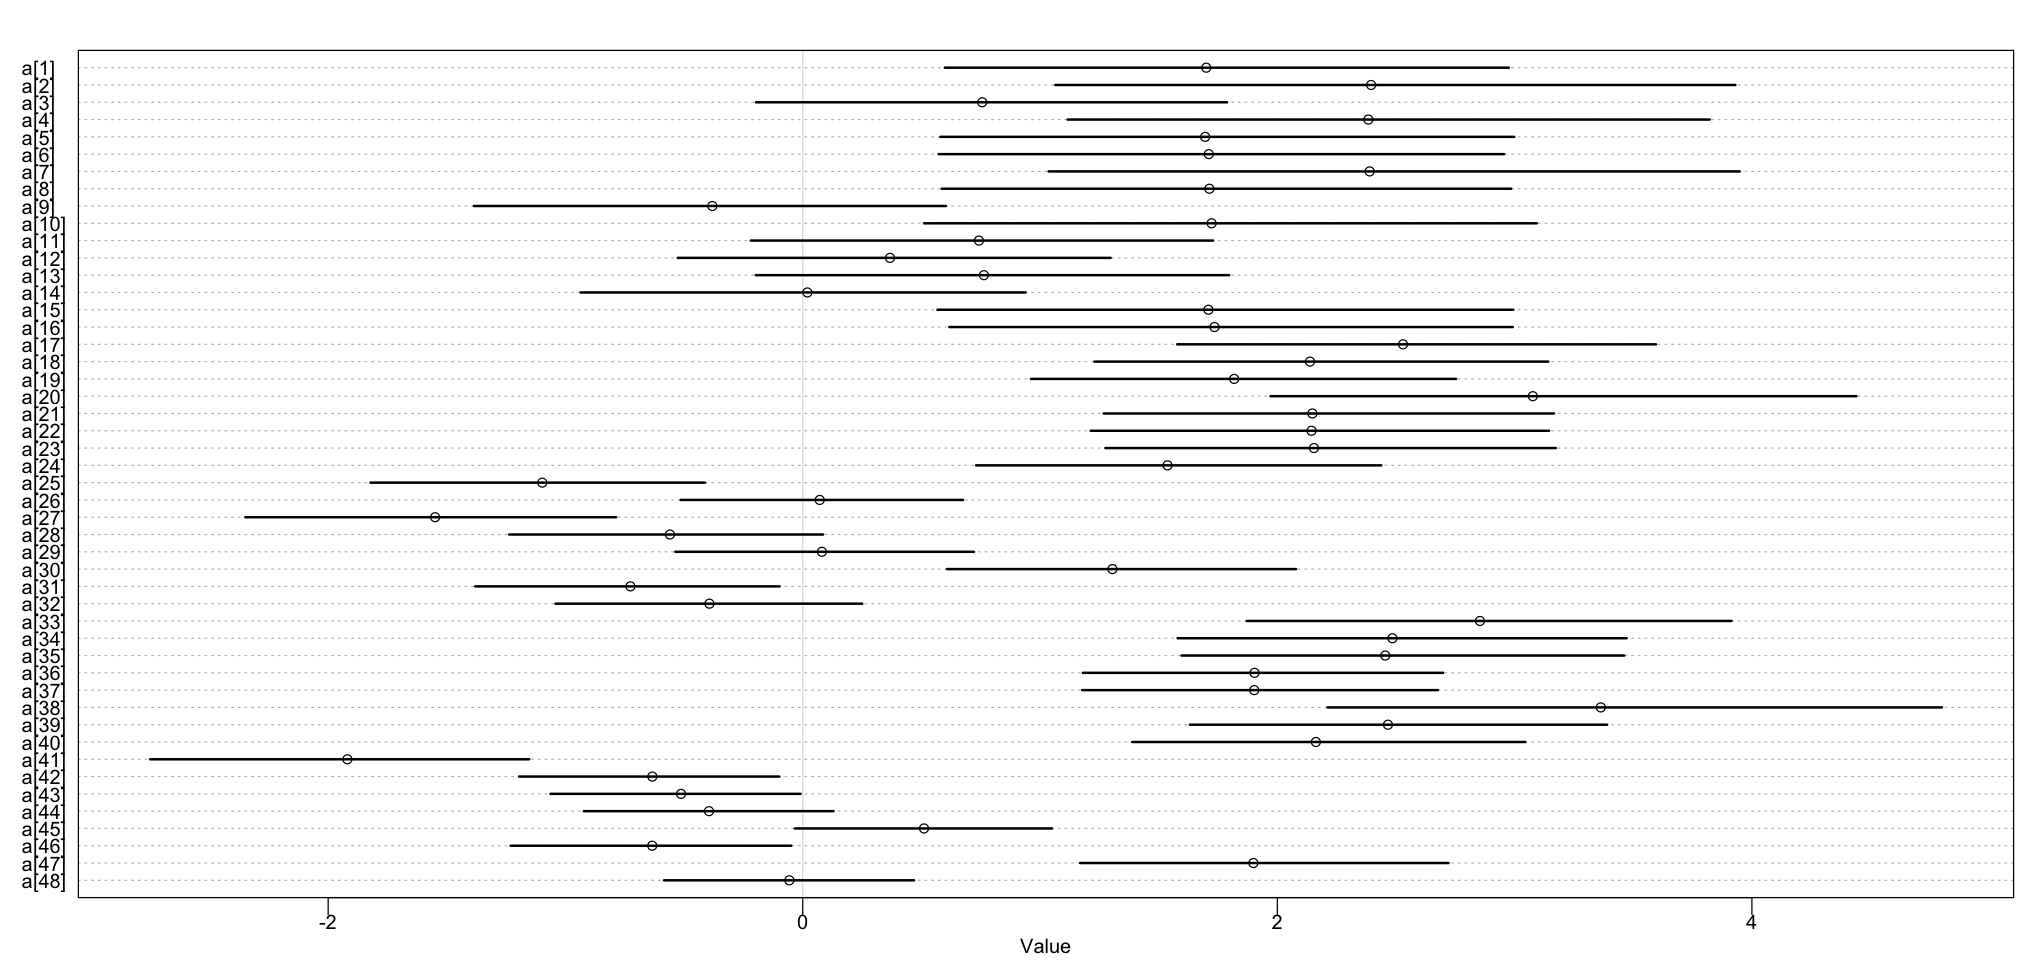

In [4]:
par(bg = 'white')
precis(m13.1, depth = 2)
plot(precis(m13.1, depth = 2))

So far this is just a very standard model with nothing new in it. If we wanted the probability of survival we would take the logit of the `a` values, as we've done in the past.

Now let's do the multilevel model. To do that, we make the prior for the `a` parameter a function of some new variable.

$$
\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{TANK}[i]} \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma) & \text{for $j = 1\dots 48$} \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

So we now have an adaptive prior across all of our tanks which tracks in some way the average mortality.

There are two 'levels' to this model. The first is the one that looks like our usual model, and the second is the level where we track the 'global' average across tanks.

The two new parameters $\bar{\alpha}$ and $\sigma$ are termed [[Hyperparameters]] - they are parameters for parameters. Their priors are called [[Hyperpriors]].

In principle there is no limit to the number of levels we could include in the model, but often they are constrained in practice by computational complexity or the need to actually understand the model.

In [5]:
m13.2 <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

In [6]:
compare(m13.1, m13.2)

WAIC     SE       dWAIC    dSE     pWAIC    weight     
m13.2 201.0782 7.210405  0.00000      NA 21.37888 0.997425352
m13.1 212.9971 4.622617 11.91893 3.83002 24.81349 0.002574648

A few things to note:
- The multilevel model has only about 21 effective parameters (`pWAIC`) vs. 50 actual (48 intercepts + the prior parameters). This is due to the fact that the prior for each parameter 'shrinks' them toward the average, leading to a decrease in their effective number. The mean of `sigma` is about 1.6 if you calculate it. It's a [[Regularizing Prior]], but the strength of that regularization has been learned from the data.
- The multilevel model has fewer effective variables than the regular fixed model (`m13.1`), despite in reality having more variables (50 vs. 48). This is due to the effect of the aggressive regularizing prior.

Let's take a look at how our model handles the data:

In [7]:
# extract some data
post <- extract.samples(m13.2)

# mean intercept for each tank
d$propsurv.est <- logistic(apply(post$a, 2, mean))

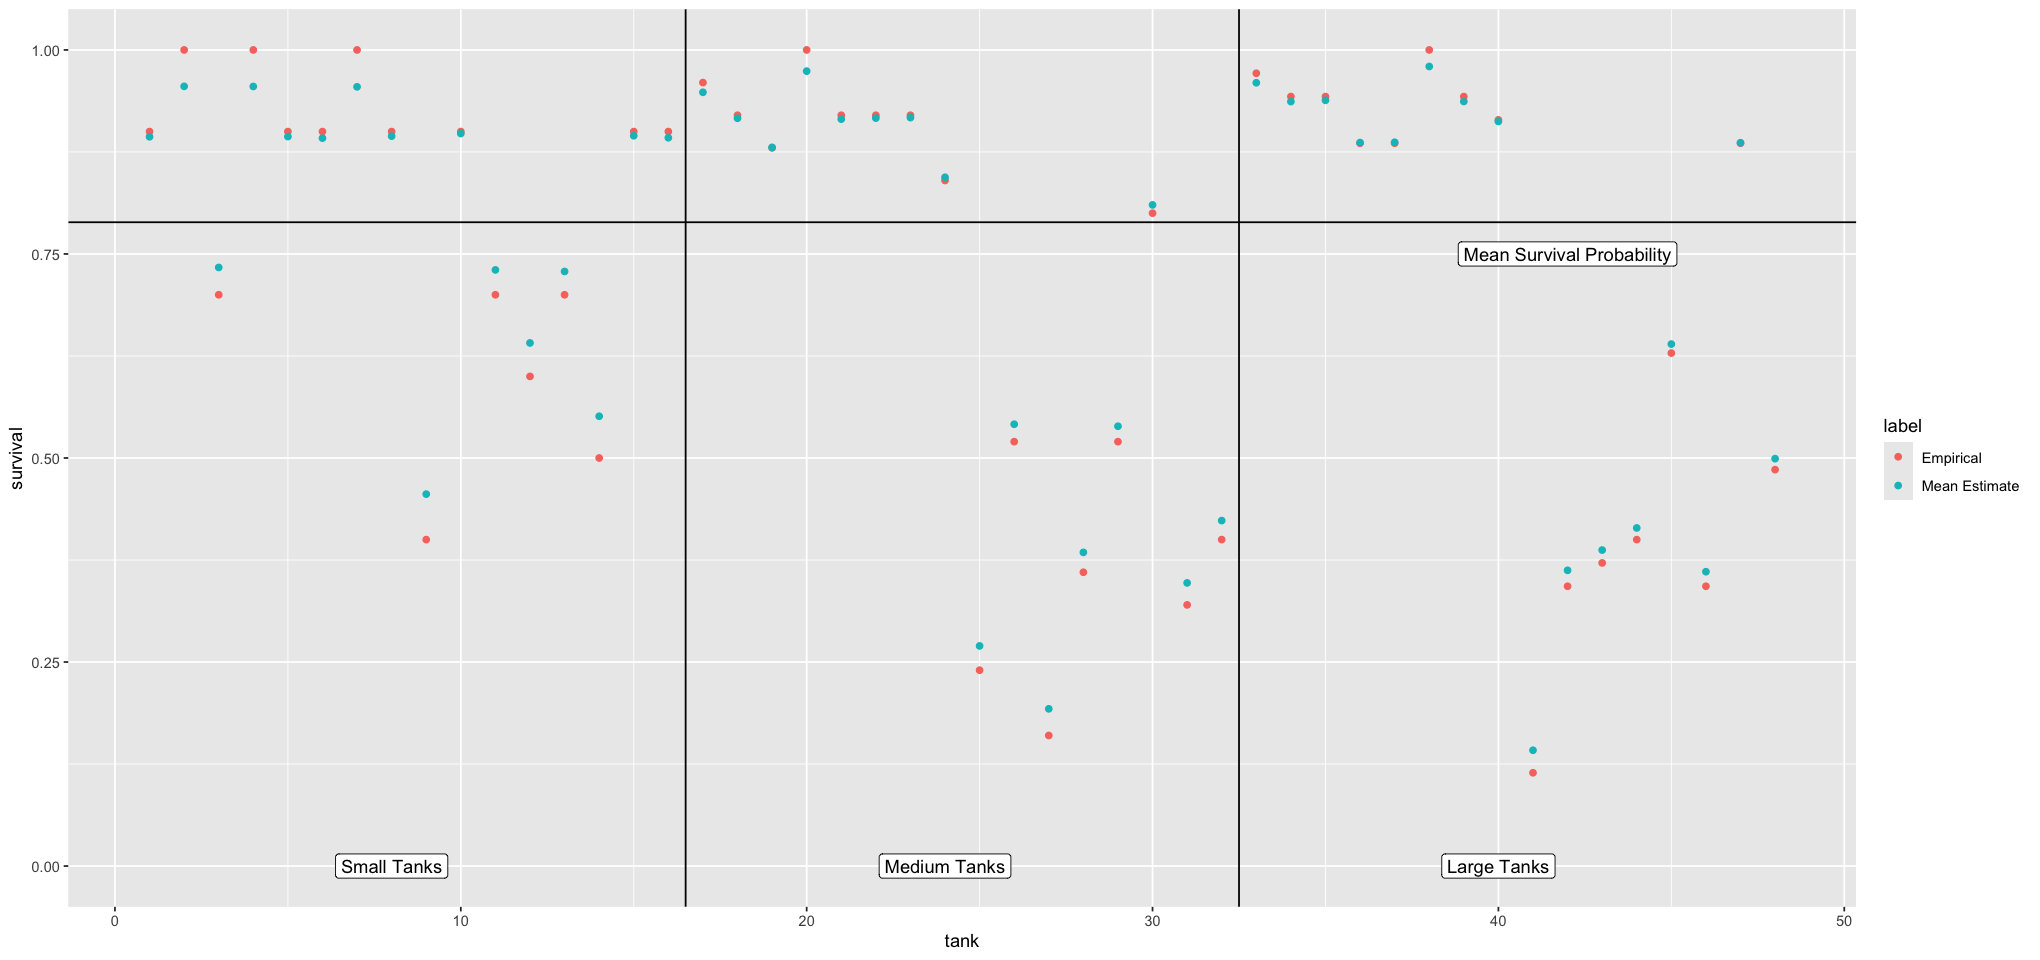

In [8]:
plot_df <- data.frame(
    tank = d$tank,
    survival = d$propsurv,
    label = "Empirical"
)
plot_df <- rbind(plot_df,
    data.frame(
        tank = d$tank,
        survival = d$propsurv.est,
        label = "Mean Estimate"
    )
)
ggplot(plot_df) +
    geom_point(mapping = aes(tank, survival, colour = label)) +
    geom_hline(aes(yintercept = mean(inv_logit(post$a_bar)) )) +
    annotate('label', x = 42, y = 0.75, label = "Mean Survival Probability") +
    geom_vline(aes(xintercept = 16.5)) + 
    annotate('label', x = 8, y = 0, label = 'Small Tanks') +
    geom_vline(aes(xintercept = 32.5)) +
    annotate('label', x = 24, y = 0, label = 'Medium Tanks') +
    annotate('label', x = 40, y = 0, label = 'Large Tanks')

What does this imply about the population distribution of survival probabilities? To find out, we'll:
- plot a bunch of Gaussian distributions, one for each of the simulated samples from the posterior distribution of both $\alpha$ and $\sigma$.
- Sample a bunch of log-odds of survival for individual tanks

The result will be a posterior distribution of variation in survial in the population of tanks.

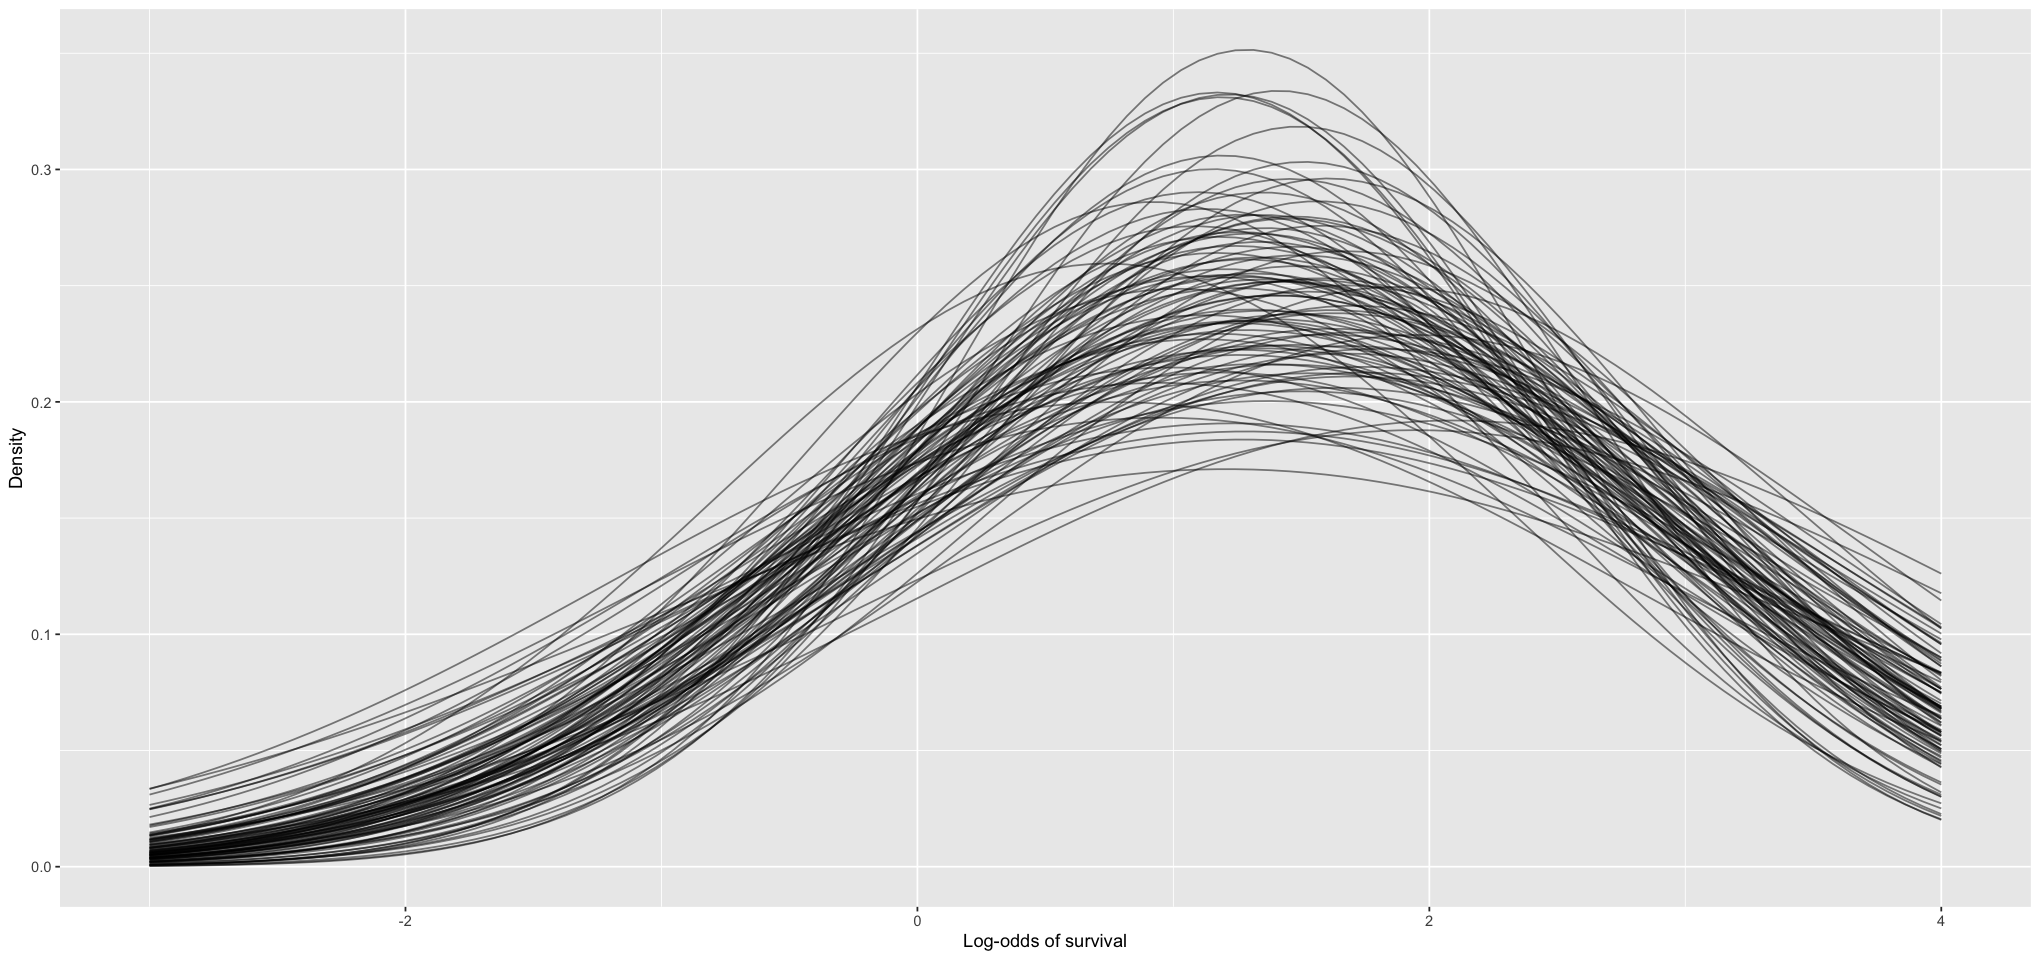

In [9]:
# log-odds of survival
x <- seq(-3, 4, length.out = 100)
plot_df <- data.frame(x = numeric(), y = numeric(), distribution_number = integer())
for (i in 1:100) {
    mu <- post$a_bar[i]
    sigma <- post$sigma[i]
    plot_df <- rbind(plot_df, data.frame(x = x, y = dnorm(x, mu, sigma), distribution_number = i))
}
plot_df$distribution_number <- factor(plot_df$distribution_number)

ggplot(plot_df, aes(x, y, group = distribution_number)) +
    geom_line(alpha = 0.5) +
    labs(y = "Density", x = "Log-odds of survival")

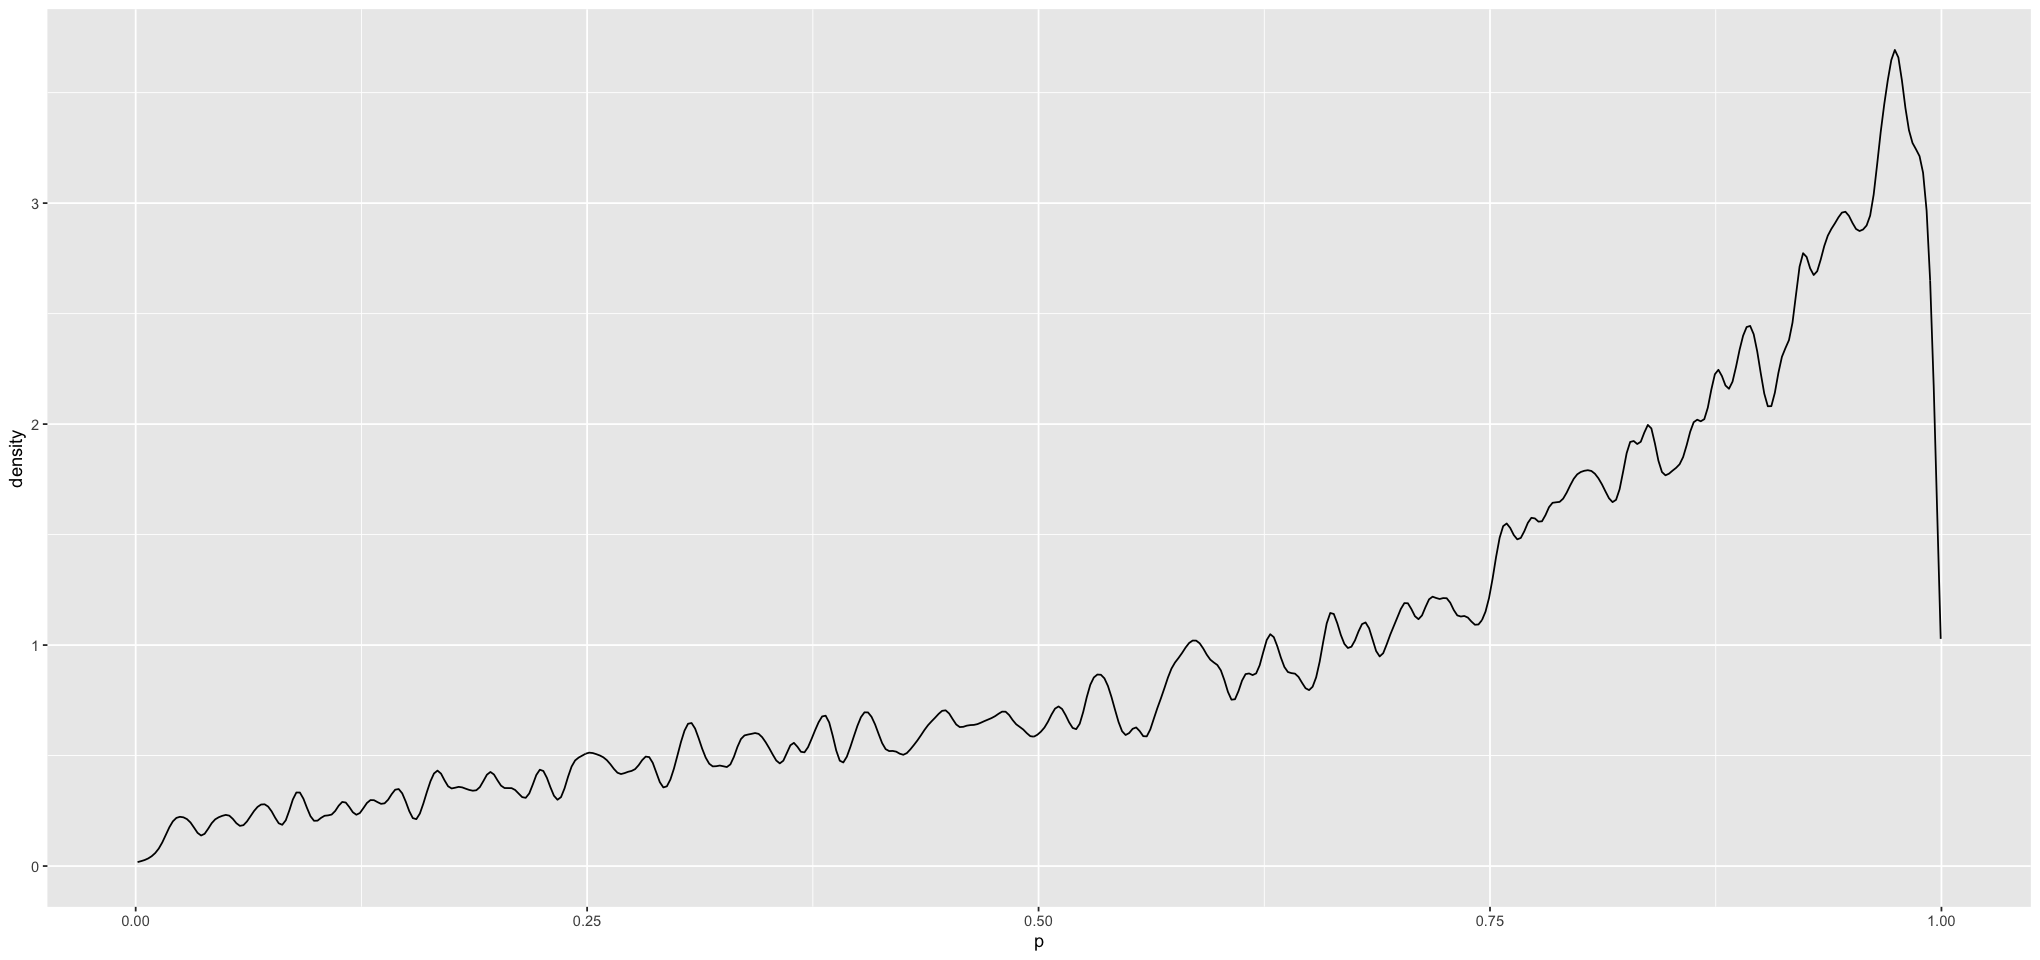

In [10]:
# now the actual probabilities
simulated_tanks <- rnorm(8000, post$a_bar, post$sigma)

plot_df <- data.frame(p = inv_logit(simulated_tanks))

ggplot(plot_df) +
    geom_density(aes(p), adjust = 0.1)

### Varying efects and the underfitting / overfitting trade-off

> Varying intercepts are regularized estimates, byt adaptively regularized by estimating how diverse the clusters are while still estimating the features of each cluster

Multilevel models do a better job of navigating the underfitting / overfitting problem.

To see how this could be, let's pretend that the tanks are actually natural ponds. Then there are three perspectives that we could take on how to estimate the survival rate:
1. Complete pooling. This means that we assume that the ponds are all the same, with a common intercept.
1. No pooling. This means that we assume that each pond tells us nothing about the other ponds.
1. Partial pooling. This means that we use an adaptive regularizing prior, as we did earlier in this chapter.

For the first one (complete pooling), we have lots of data and so will probably generate a very precise estimate $\alpha$. However, the estimate will not fit any particular data point very well; it will underfit the data.

If you use the no pooling approach, then the estimate for each pond will be based on very little data. As a result, the mean will be overfit to the data but the variance of the estimate will be large. 

The partial pooling approach (multilevel models) threads the line between these. If there's lots of data then the result will be very precise, and if there's not then it will tend to drift toward the average of the data. This avoids both overfitting and underfitting.

To see this in action we're going to generate our own data. This will help us to verify that our models work as we expect.

### 13.12 The model

The first step is to define the model we'll be using. Basically it's the same as what we already did, but with ponds instead of tanks.

$$
\begin{align*}
    S_i &\sim \text{Binomial}(N_i, p_i) \\
    \text{logit}(p_i) &= \alpha_{\text{POND}[i]} \\
    \alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma) & \text{for $j = 1\dots 48$} \\
    \bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
    \sigma &\sim \text{Exponential}(1)
\end{align*}
$$

To simulate data, we'll need to fix the values of
- $\bar{\alpha}$, the average log-odds of survival in the entire population of ponds
- $\sigma$, the standard deviation of the distribution of logg-odds of survival
- $\alpha$, a vector of individual pond intercepts
- $N_i$, the sample size from each pond

Once we have those, it''ll be simple to simulate our data!

### Assign values to the parameters

In [11]:
a_bar <- 1.5
sigma <- 1.5
Ni <- as.integer(rep(c(5, 10, 25, 35), each = 15))
nponds <- length(Ni) # 15 * 4 -> 60

# now we simulate the intercept for each pond
set.seed(5005)
a_pond <- rnorm(nponds, mean = a_bar, sd = sigma)

# put it in a data frame
dsim <- data.frame(
    pond = 1:nponds,
    Ni = Ni,
    true_a = a_pond
)

dsim

pond Ni true_a     
1   1    5  0.56673123
2   2    5  1.99002317
3   3    5 -0.13775688
4   4    5  1.85676651
5   5    5  3.91208800
6   6    5  1.95414869
7   7    5  1.48963805
8   8    5  2.52407196
9   9    5  2.17828010
10 10    5  2.04776578
11 11    5  2.74564559
12 12    5 -0.63722320
13 13    5  3.03948315
14 14    5  1.90733694
15 15    5  3.54119394
16 16   10  0.65165674
17 17   10 -1.16943954
18 18   10  0.59568973
19 19   10  0.38530177
20 20   10  1.02961242
21 21   10  0.07034006
22 22   10  1.34936971
23 23   10  2.45730258
24 24   10 -0.05251326
25 25   10  2.20677386
26 26   10  1.82918746
27 27   10  1.33997120
28 28   10  1.57233138
29 29   10  1.25467353
30 30   10  0.82663309
31 31   25  2.65834264
32 32   25  2.08241191
33 33   25  1.50758907
34 34   25  0.86265946
35 35   25  0.22721714
36 36   25  4.61568929
37 37   25 -1.75144380
38 38   25 -1.03306026
39 39   25  0.23817747
40 40   25  5.35841158
41 41   25  3.84572461
42 42   25  1.81628755
43 43   25 -0.34267584
44 44   25  0.76111582
45 45   25 -1.55979666
46 46   35 -0.08456073
47 47   35  4.37882074
48 48   35  2.32597649
49 49   35  1.78144089
50 50   35  1.86990933
51 51   35  1.58196519
52 52   35  0.15560642
53 53   35  1.50345864
54 54   35  4.49654575
55 55   35  0.56518221
56 56   35  2.55806132
57 57   35  0.56742678
58 58   35  2.74606408
59 59   35  1.50422253
60 60   35  2.49737954

### Simulate survivors

Now let's simulate the binomial survival process. The number of survivors is a binomial outcome with each pond having a probability of survival $p_i = \text{inv\_logit}(\alpha_i) = \frac{e^{ \alpha_i }}{1 + e^{\alpha_i}}$

In [12]:
dsim$Si <- rbinom(nponds, prob = logistic(dsim$true_a), size=dsim$Ni)

### Compute the no-pooling estimates

This is very easy - we can actually just use the data and calculate the empirical estimate: number of survivors / size of pond! Note that we could run this through a Stan model (or whatever), but the mean would be the same. We're just missing any estimate of the uncertainty, but that's ok for now.

In [13]:
dsim$p_nopool <- dsim$Si / dsim$Ni

### Compute the partial-pooling estimates

Now to fit the model to the data using partial pooling (hierarchical model). We'll use `ulam`.

In [14]:
dat <- list(
    Si = dsim$Si,
    Ni = dsim$Ni,
    pond = dsim$pond
)

m13.3 <- ulam(
    alist(
        Si ~ dbinom(Ni, p),
        logit(p) <- a_pond[pond],
        a_pond[pond] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1)
    ),
    data = dat,
    chains = 4
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

In [15]:
precis(m13.3, depth=2)

mean         sd        5.5%        94.5%       rhat      ess_bulk 
a_pond[1]   1.65988624  1.0085597  0.15479386  3.33835955 0.9995353 4420.683 
a_pond[2]   2.90822959  1.3398756  1.04712405  5.19245595 1.0018814 3004.773 
a_pond[3]  -0.62461362  0.8600122 -1.99488080  0.71766552 1.0013826 3480.877 
a_pond[4]   2.88470748  1.2674096  1.07691985  4.96211655 1.0034323 2954.273 
a_pond[5]   2.90283869  1.2870118  1.04730230  5.19048195 1.0041054 2463.419 
a_pond[6]   2.86141924  1.2160174  1.12579000  4.92912070 1.0002863 2913.118 
a_pond[7]   0.08323686  0.8532966 -1.26758355  1.41021815 1.0039936 3894.854 
a_pond[8]   2.86103928  1.2452787  1.00635600  5.08126810 1.0044143 3660.543 
a_pond[9]   1.63214357  0.9873611  0.18602875  3.24833360 1.0005107 4113.089 
a_pond[10]  1.64936922  0.9928527  0.16837178  3.26092935 0.9995783 3867.943 
a_pond[11]  2.88341248  1.1840134  1.12441140  4.85602465 1.0017004 2423.561 
a_pond[12]  0.07258528  0.8295170 -1.20716410  1.39003175 1.0030982 3803.645 
a_pond[13]  2.88679519  1.2521863  1.01510055  4.97860845 1.0022083 3939.425 
a_pond[14]  2.88281649  1.2924166  1.01573715  5.13895545 1.0008813 3530.874 
a_pond[15]  2.89701372  1.3297960  0.98711284  5.11217525 0.9994146 2911.033 
a_pond[16]  1.56662105  0.7288709  0.50415809  2.84394650 1.0056684 3714.162 
a_pond[17] -1.43375421  0.7586111 -2.71091635 -0.29662957 1.0018077 3312.875 
a_pond[18]  1.07297851  0.6958979  0.03872329  2.25471110 1.0059577 5299.181 
a_pond[19] -0.95240108  0.6786632 -2.07539120  0.08662152 1.0016871 4327.842 
a_pond[20]  1.54804951  0.7643490  0.40798497  2.77530760 1.0002527 3566.401 
a_pond[21] -0.16060884  0.6393441 -1.20282815  0.83028261 1.0030545 4944.697 
a_pond[22]  2.25152715  0.9324078  0.90781505  3.81120310 0.9998040 3526.614 
a_pond[23]  3.23931817  1.1356209  1.67503440  5.18412150 1.0013413 3348.751 
a_pond[24]  0.62166002  0.6224451 -0.35062381  1.62889410 1.0022992 4060.234 
a_pond[25]  3.29010498  1.1997874  1.62144450  5.36935185 1.0064335 3158.397 
a_pond[26]  2.22989451  0.8996433  0.90760689  3.77986180 0.9999014 3454.550 
a_pond[27]  1.05548051  0.6699028  0.03753697  2.15367505 0.9999907 4324.304 
a_pond[28]  2.23254095  0.8734175  0.94810737  3.71547465 1.0082535 4251.251 
a_pond[29]  1.57638561  0.7388113  0.45475913  2.79557285 0.9994820 3668.306 
a_pond[30]  1.04288704  0.6761319  0.03467851  2.16845875 1.0005339 3686.254 
⋮          ⋮            ⋮         ⋮           ⋮           ⋮         ⋮        
a_pond[33]  1.729826671 0.5285802  0.95513611  2.6231067  1.0022817 3913.9272
a_pond[34]  1.244389024 0.4728283  0.50956235  2.0052454  1.0018902 3688.0856
a_pond[35]  0.661364881 0.4089161  0.01510982  1.3181901  1.0026253 4230.4677
a_pond[36]  3.837529060 1.0336977  2.34673250  5.6492970  1.0001253 2437.2189
a_pond[37] -0.988240077 0.4346930 -1.71186035 -0.3210750  1.0012422 3646.7817
a_pond[38] -1.192465540 0.4722272 -1.97269830 -0.4703791  1.0080495 4510.8249
a_pond[39]  0.667472885 0.4310774  0.02278333  1.3646030  1.0026915 3792.0056
a_pond[40]  3.852422695 1.0665439  2.34982260  5.7361128  1.0031673 2689.7708
a_pond[41]  3.852268495 1.0889751  2.36126405  5.7819006  1.0006275 3060.2526
a_pond[42]  2.466787424 0.6989907  1.46877350  3.6379816  1.0031976 4273.7207
a_pond[43] -0.127785952 0.3882158 -0.74288822  0.4955991  1.0028909 4971.5770
a_pond[44]  0.673961175 0.3874305  0.06019406  1.2960422  1.0035083 4928.0808
a_pond[45] -1.190294806 0.4742464 -1.99217330 -0.4588302  0.9990809 4813.6941
a_pond[46]  0.004155066 0.3297293 -0.53088607  0.5316434  1.0003552 4194.2279
a_pond[47]  4.065463275 1.0949588  2.54808875  5.9144301  1.0013355 2475.4901
a_pond[48]  2.085699492 0.5191137  1.29768890  2.9558292  1.0000303 3798.3450
a_pond[49]  1.850587844 0.4686794  1.14700325  2.6185046  1.0079853 4130.5650
a_pond[50]  2.746846295 0.6257955  1.82925445  3.8250139  1.0011958 3564.3574
a_pond[51]  2.393873983 0.5684531  1.53779710  3.3464912  1.0084080 3890.1543
a_pond[52]  0.365686217 0.3188737

Let's compute the predicted survival proportions and add them to the data frame.

In [16]:
post <- extract.samples(m13.3)
dsim$p_partpool <- apply(inv_logit(post$a_pond), 2, mean)

# we'll also need the true p value for each pond
dsim$p_true <- inv_logit(dsim$true_a)

# no we calculate the error for each of the different methods
nopool_error <- abs(dsim$p_nopool - dsim$p_true)
partpool_error <- abs(dsim$p_partpool - dsim$p_true)

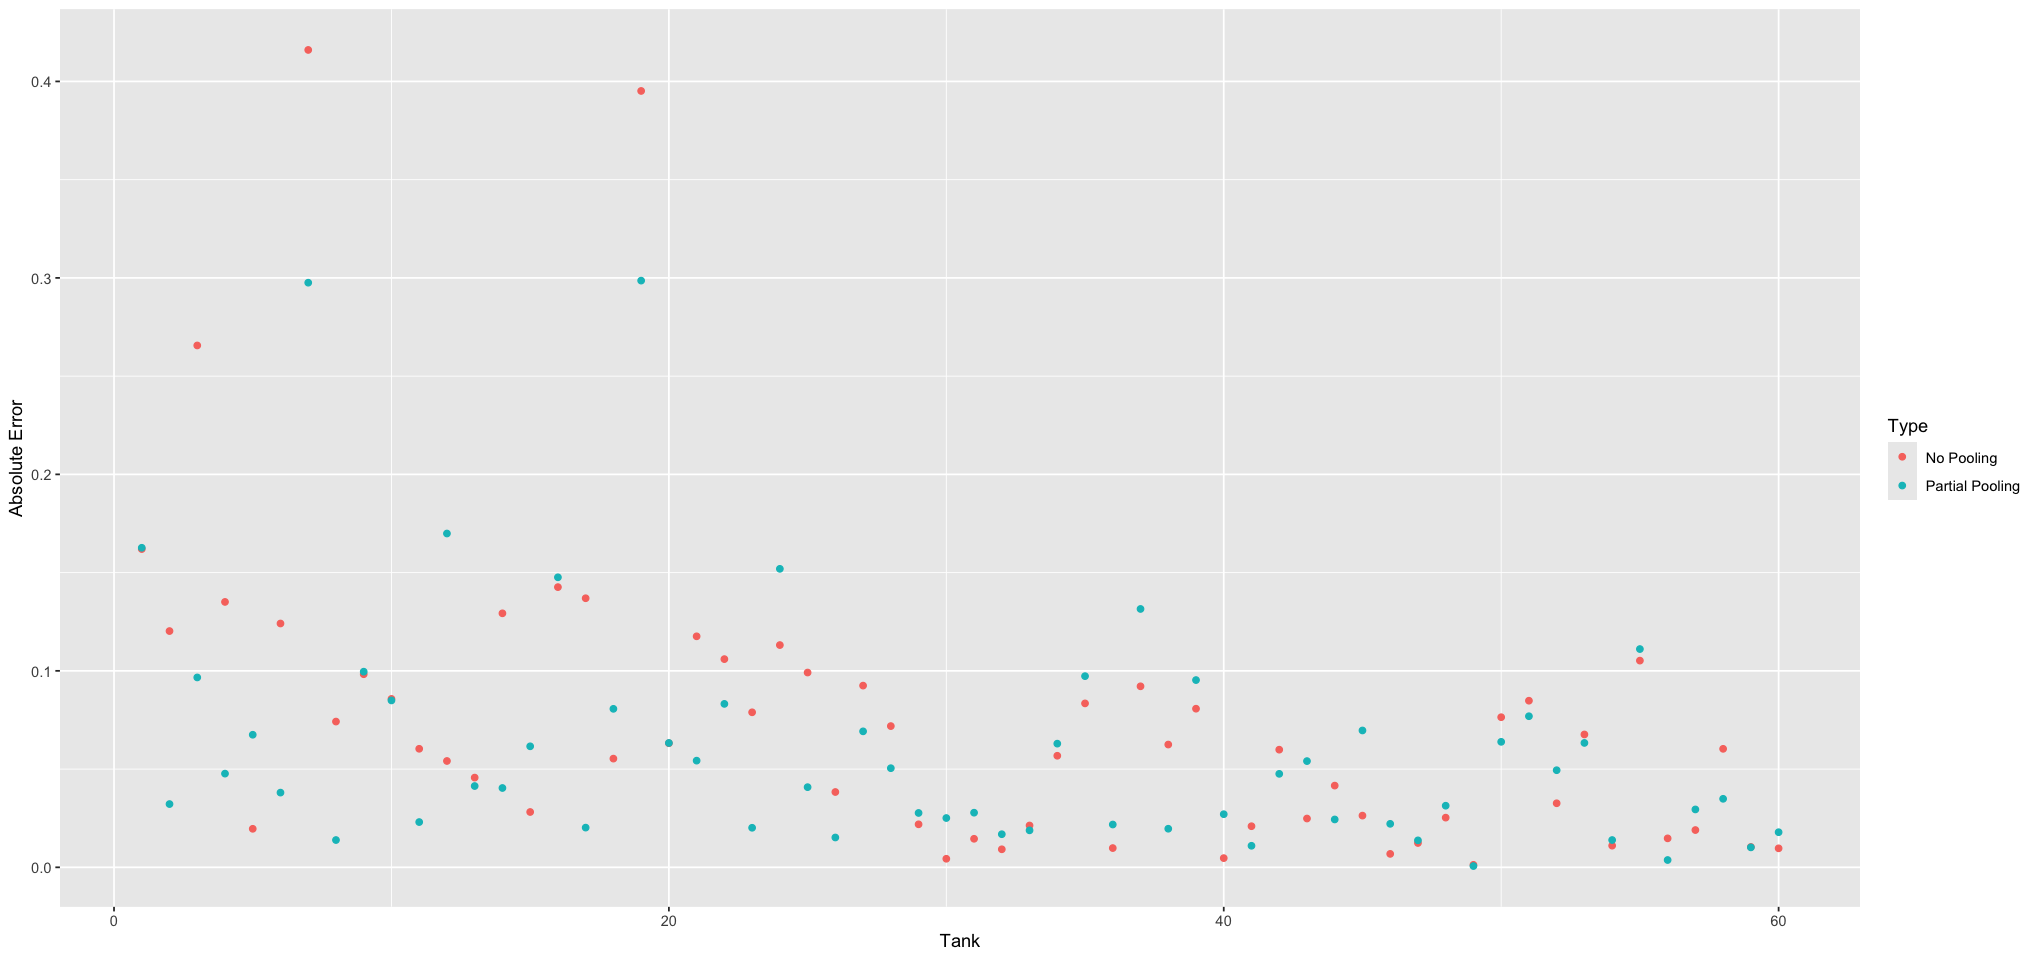

In [17]:
plot_df <- rbind(
    data.frame(
        tank = 1:length(nopool_error),
        error = nopool_error,
        type = "No Pooling"
    ),
    data.frame(
        tank = 1:length(partpool_error),
        error = partpool_error,
        type = "Partial Pooling"
    )
)

ggplot(plot_df, aes(tank, error, colour = type)) +
    geom_point() +
    labs(x = "Tank", y = "Absolute Error", colour = "Type") 


Note that the partial pooling results are better almost every time than the no pooling results.

In [18]:
nopool_avg <- aggregate(nopool_error, list(dsim$Ni), mean)
partpool_avg <- aggregate(partpool_error, list(dsim$Ni), mean)

nopool_avg
partpool_avg

Group.1 x         
1  5      0.12122935
2 10      0.10245961
3 25      0.04057566
4 35      0.03583510

Group.1 x         
1  5      0.08512961
2 10      0.07655761
3 25      0.04837656
4 35      0.03616521

## More than one type of cluster

It often turns out that our experimental structure lends itself to more than one type of cluster. For instance, in the chimpanzee experiment, each level pulls belongs to one actor (the chimpanzee), but the pulls *also* happened within discrete experimental blocks, each occurring on the same day. Each pull belongs to an actor (1 - 7) but also to a block (1 - 6). We can use partial pooling on both of these clusters.

This kind of data, where e.g. actors are not nested within a single block, is called a [[Cross-Classified Multilevel Model]]. In each actor had done all of their pulls within the same blocks, then it would be a [[Hierarchical Multilevel Model]]. The model specification is typically the same between these.

### Multilevel chimpanzees

To adapt for both the actor-level and block-level clustering, we'll adapt the model from [[Chapter 11]] and add a new actor-level and block-level intercept, each with their own parameters.

$$
\begin{align*}
L_i &\sim \text{Binomial}(1, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{ACTOR}[i]} + \gamma_{\text{BLOCK}[i]} + \beta_{\text{TREATMENT}[i]} \\
\beta_j &\sim \text{Normal}(0, 0.5) & \text{for $j = 1\dots 4$} \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) & \text{for $j = 1\dots 7$} \\
\gamma_j &\sim \text{Normal}(0, \sigma_{\gamma}) & \text{for $j = 1\dots 6$} \\
\bar{\alpha} &\sim \text{Normal(0, 1.5)} \\
\sigma_\alpha &\sim \text{Exponential(1)} \\
\sigma_\gamma &\sim \text{Exponential(1)} \\
\end{align*}
$$

Note that there's only one $\bar{\alpha}$ parameter. We can't identify a separate mean for each varying intercept type because both intercepts are added to the same prediction. In theory we could add separate ones, but then we'd run into a multicollinearity problem like we did earlier with the left and right legs example.

Now let's run the model!

In [19]:
data(chimpanzees)
d <- chimpanzees
d$treatment <- 1 + d$prosoc_left + 2 * d$condition

dat_list <- list(
    pulled_left = d$pulled_left,
    actor = d$actor,
    block_id = d$block,
    treatment = as.integer(d$treatment)
)

set.seed(13)
m13.4 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + g[block_id] + b[treatment],
        b[treatment] ~ dnorm(0, 0.5),
        # adaptive priors
        a[actor] ~ dnorm(a_bar, sigma_a),
        g[block_id] ~ dnorm(0, sigma_g),
        # hyper priors
        a_bar ~ dnorm(0, 1.5),
        sigma_a ~ dexp(1),
        sigma_g ~ dexp(1)
    ),
    data = dat_list,
    chains = 4,
    cores = 4,
    log_lik = TRUE
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpgEp1rs/model-9878260719cc.stan', line 21, column 4 to column 34)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpgEp1rs/model-9878260719cc.stan', line 21, column 4 to column 34)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60

See https://mc-stan.org/misc/warnings for details.




Apparently this is supposed to result in a bunch of divergent transitions, but it's not at the moment. Apparently this is something that we'll fix in a bit.

mean         sd        5.5%         94.5%        rhat     ess_bulk 
b[1]    -0.140384396 0.3104392 -0.656763650  0.340089770 1.010293  438.7808
b[2]     0.393819689 0.3105997 -0.111781670  0.886487385 1.012343  400.4837
b[3]    -0.478942576 0.3125054 -0.985714350 -0.001867275 1.014307  426.3076
b[4]     0.281226117 0.3040646 -0.214599940  0.738879970 1.014526  465.1455
a[1]    -0.349393397 0.3709872 -0.915795145  0.265304750 1.008104  414.0663
a[2]     4.693184815 1.2253668  3.033960000  6.876075550 1.003570  799.5012
a[3]    -0.656808101 0.3687594 -1.217484700 -0.057030201 1.008510  388.3045
a[4]    -0.656701408 0.3752144 -1.240150050 -0.072011782 1.008084  404.3305
a[5]    -0.354013953 0.3711532 -0.920823360  0.261819015 1.010378  423.3406
a[6]     0.594438954 0.3779616  0.007510246  1.203294600 1.008408  388.7268
a[7]     2.121230156 0.4672240  1.387656900  2.872632750 1.007484  366.7395
g[1]    -0.177523192 0.2340502 -0.606642055  0.068304781 1.006124  546.3455
g[2]     0.026140733 0.1804243 -0.245996270  0.318646150 1.008799  949.5756
g[3]     0.052752477 0.1865732 -0.199796370  0.385483410 1.011404  711.8376
g[4]     0.009976589 0.1813646 -0.274479290  0.289173435 1.006694 1071.4778
g[5]    -0.032283694 0.1822856 -0.348219435  0.230681665 1.012738  946.1959
g[6]     0.106378586 0.1978929 -0.138192100  0.465116445 1.001676  818.4058
a_bar    0.606644243 0.7361489 -0.520919780  1.800580700 1.002886 1051.5382
sigma_a  2.031491420 0.6466113  1.205757900  3.259981250 1.003725  781.6992
sigma_g  0.216229703 0.1768724  0.028509086  0.541332890 1.019222  195.4716

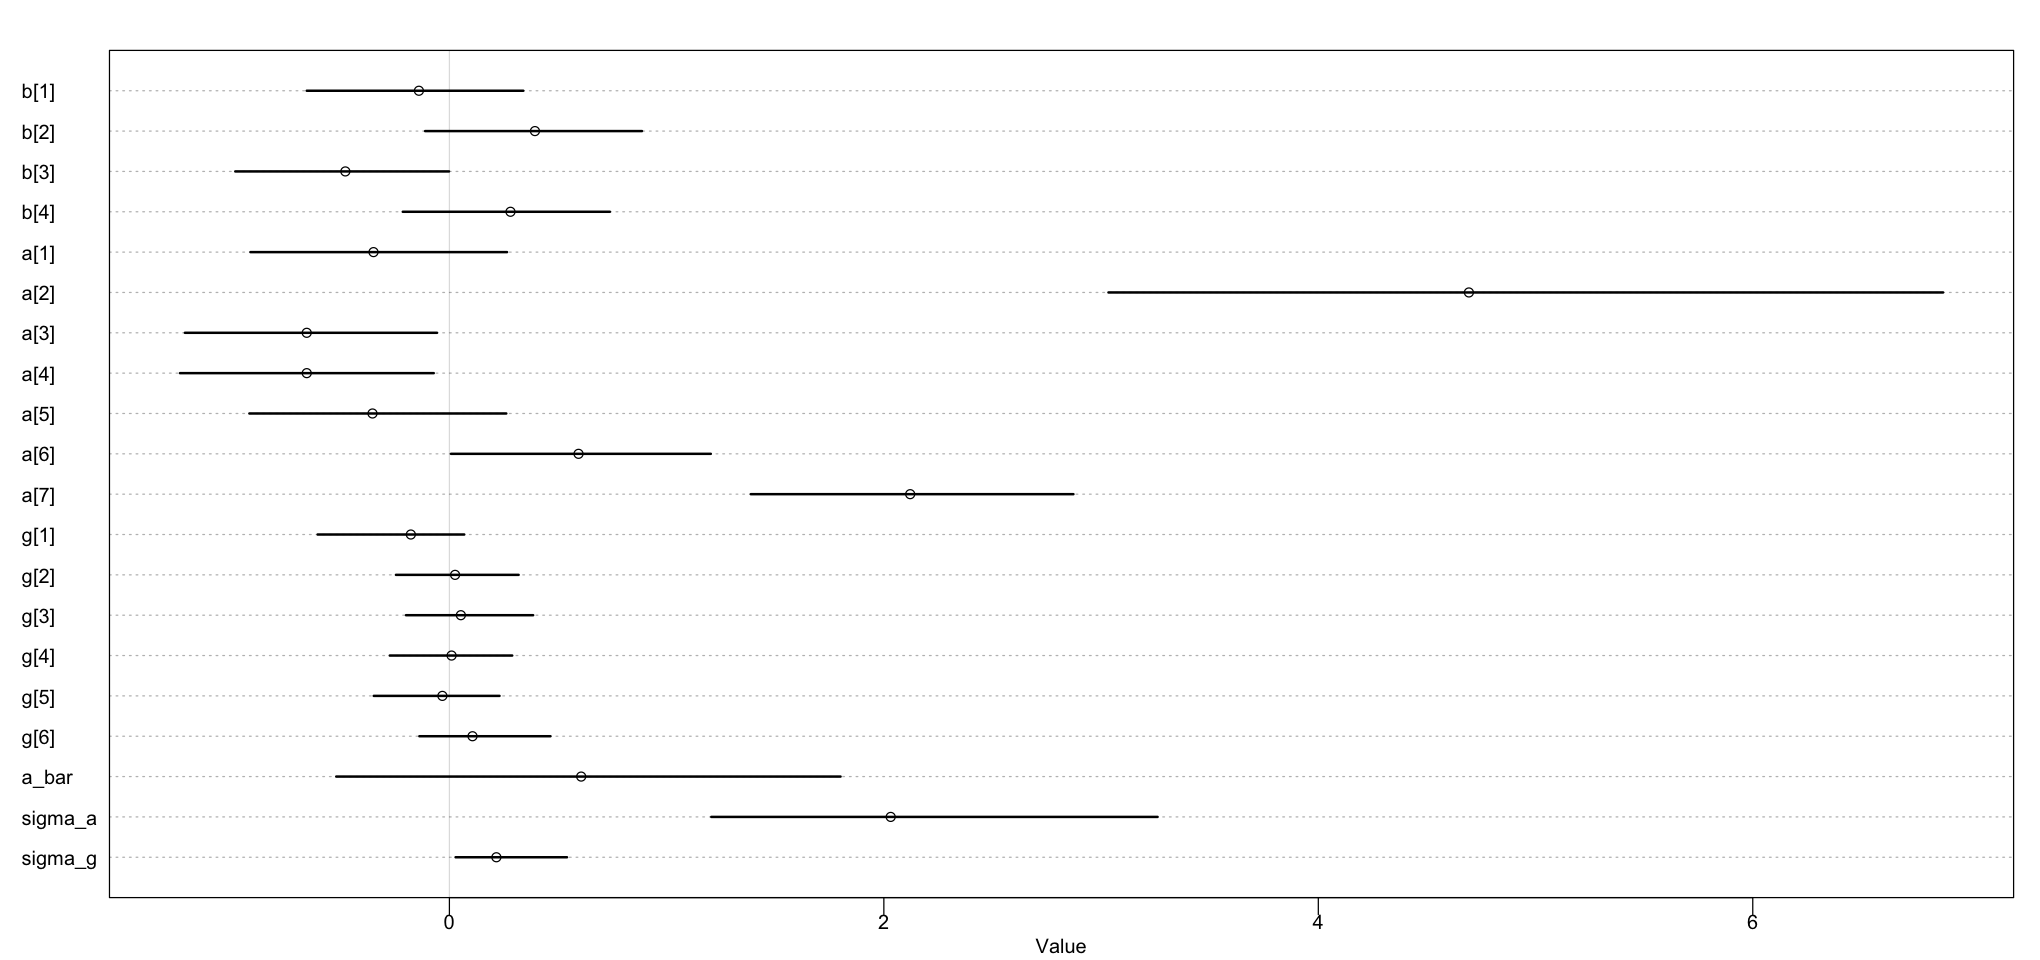

In [20]:
par(bg = 'white')
precis(m13.4, depth = 2)
plot(precis(m13.4, depth = 2))

There are a few things that we should notice about this.

- The effective number of parameters (`ess_bulk`) varies a lot between the different parameters. There are a lot of reasons for this, but in out case a large part of the reason is that some parameters spend a lot of time near a boundary. In this case, it's `sigma_g`. Also a bunch of the `r_hat` values are above one. Both of these are signs of inefficient sampling, which we'll fix later.
- Notice that `sigma_g` (sd of the blocks) is much smaller than `sigma_a`, the variance among the actors. If we look at the values for these (`a[]` and `g[]`) this makes sense - the blocks all seem to be basically the same while there's a lot of variation among the actors.

As a result, adding `block` to this model hasn't added a lot of overfitting risk. Let's take a look at the varying intercepts model without the blocks.

In [21]:
set.seed(14)
m13.5 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + b[treatment],
        b[treatment] ~ dnorm(0, 0.5),
        # adaptive priors
        a[actor] ~ dnorm(a_bar, sigma_a),
        # hyper priors
        a_bar ~ dnorm(0, 1.5),
        sigma_a ~ dexp(1)
    ),
    data = dat_list,
    chains = 4,
    cores = 4,
    log_lik = TRUE
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration:

In [22]:
compare(m13.4, m13.5)

WAIC     SE       dWAIC     dSE      pWAIC     weight   
m13.5 531.5236 19.24054 0.0000000       NA  8.760136 0.5637934
m13.4 532.0367 19.39689 0.5131437 1.707225 10.593521 0.4362066

These models are basically identical in terms of their efficacy.

Note that it is tempting to just coose m13.4 as the model to use and go from there. However, that risks us losing valuable information - we now know something that *didn't* really affect the model! It's probably a good practice to report both and show what happened.

### Even more clusters

Notice that the treatment effects, `b`, look like the `a` and `g` parameters. Could we also partially pool these? Absolutely!

Note that some people have been taught that you should only ever pool things that were not experimentally controlled (varying effects are only for these variables). The idea is that since the treatment was 'fixed' by the experiment, we should use un-pooled 'fixed' effects.

This is not correct. We use varying effects (pooling) because they provide better inferences. It doesn't matter how the clusters are created. What's important is that the individual units are **exhangable** - that is, we could swap the individual index values without changing the meaning of the model.

In this case there are only four treatments and there is a lot of data on each treatment, so it probably won't make a different anyway. Let's test it out!

In [23]:
set.seed(15)
m13.6 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + g[block_id] + b[treatment],
        # adaptive priors
        a[actor] ~ dnorm(a_bar, sigma_a),
        g[block_id] ~ dnorm(0, sigma_g),
        b[treatment] ~ dnorm(0, sigma_b),
        # hyper priors
        a_bar ~ dnorm(0, 1.5),
        sigma_a ~ dexp(1),
        sigma_g ~ dexp(1),
        sigma_b ~ dexp(1)
    ),
    data = dat_list,
    chains = 4,
    cores = 4,
    log_lik = TRUE
)
coeftab(m13.4, m13.6)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 4

See https://mc-stan.org/misc/warnings for details.




        m13.4   m13.6  
b[1]      -0.14   -0.09
b[2]       0.39    0.43
b[3]      -0.48   -0.42
b[4]       0.28    0.31
a[1]      -0.35   -0.39
a[2]       4.69    4.65
a[3]      -0.66   -0.70
a[4]      -0.66   -0.70
a[5]      -0.35   -0.39
a[6]       0.59    0.54
a[7]       2.12    2.08
g[1]      -0.18   -0.18
g[2]       0.03    0.03
g[3]       0.05    0.04
g[4]       0.01    0.01
g[5]      -0.03   -0.04
g[6]       0.11    0.11
a_bar      0.61    0.56
sigma_a    2.03    2.02
sigma_g    0.22    0.22
sigma_b      NA    0.61
nobs        504     504

If we look just at the `b` parameters, we see that they're basically the same. The variable `sigma_b` is very small. Basically, the treatments don't vary a lot because they don't really do that much. Since there's a lot of data on each treatment, they don't get pooled much anyway. This is broadly typical when each cluster has a lot of data.

However, we do get more divergent transitions. We'll look at how to fix those in a bit.

## 13.4 - Divergent transitions and non-centred priors

The previous models were supposed to produce divergent transitions (but tragically didn't - we'll continue as though they did).

[[Divergent transitions]] are commonplace when working with multilevel models, and so it's important to know how to fix them.

In [[Hamiltonian Monte Carlo]], the idea is that the particle is given a 'flick', and then we track its position to give us the different samples from the posterior. In principle, the total energy of the system should be the same at the start and the end. However, due to the vagaries of numerical approximations, sometimes it is not! This is then called a [[divergent transition]].

When does this tend to happen? Usually, when the posterior distribution is very steep in some region of the parameter space. These steep changes are hard for a discrete numerical approximation to ... approximate.

These divergent transitions are rejected, so they don't directly hurt the simulation. However, they do hurt it indirectly because those steep regions should still be explored - they're still part of the posterior!

There are two main ways to adjust for these divergent transitions:
1. Tune to simulation so that it doesn't overshoot. In [[Stan]], this involves doing more warmup with a higher target acceptance rate (`adapt_delta`). Note that for some models, they can't be fixed using this method - you can never adjust it enough to get rid of all of the divergent transitions.
2. [[Reparameterize]] is. For any model, it can be written in several different equivalent forms.

Let's take a look at two examples.

### 13.4.1 The Devil's Funnel

You don't need a fancy model to produce divergent transitions:

$$
\begin{align*}
v &\sim \text{Normal}(0, 3) \\
x &\sim \text{Normal}(0, e^v) \\
\end{align*}
$$

In [24]:
m13.7 <- ulam(
    alist(
        v ~ normal(0, 3),
        x ~ normal(0, exp(v))
    ),
    data = list(N = 1),
    chains = 4
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

See https://mc-stan.org/misc/warnings for details.




OK, so now there are some divergent transitions!

In [25]:
traceplot(m13.7)

ERROR: Error: unable to find an inherited method for function ‘traceplot’ for signature ‘object = "ulam"’


Yikes! This doesn't look like a spiky caterpillar at all!

What's happening here is that around zero, the entire distribution contracts, creating a very steep valley of probability density. The actual simulation will then overshoot this valley, leading to the ivergent transitions.

For us, it's the dependence of $x$ on $v$ which creates the problem:

$$
x \sim \text{Normal}(0, exp(v))
$$

as $v$ changes, the distribution of $x$ changes in a very inconvenient way.

This parameterization is known as the [[Centred Parameterization]]. It just indicates that the distribution of $x$ is conditional on one or more other parameters.

The alternative is a [[Non-centred Parameterization]]. This is one where the embedded parameter, $v$, is moved out of the definition of the other parameter. For us, this might look like

$$
\begin{align*}
v &\sim \text{Normal}(0, 3) \\
z &\sim \text{Normal}(0, 1) \\
x &= z \ast \exp (v)
\end{align*}
$$

What's going on here? Basically, we're 'unstandardizing' $z$ to get $x$. Normally when standardizing a variable we subtract the mean and divide by the standard deviation to get something with mean 0 and sd 1. The new variable $z$ is the standardized form of $x$: $z = \frac{x - 0}{\exp (v)} \to x = z \ast \exp (v)$. So to get $x$ back, we just undo the standardization.

Now when we run the Markov chain, we sample from $z$, not $x$.

In [ ]:
m13.7nc <- ulam(
    alist(
        v ~ normal(0, 3),
        z ~ normal(0, 1),
        gq > real[1]:x <<- z * exp(v)
    ),
    data = list(N = 1),
    chains = 4
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

Now we get no divergent transitions!

In [ ]:
precis(m13.7nc)

mean         sd          5.5%       94.5%     rhat     ess_bulk
v -0.186937548   3.0302187  -5.009651  4.630757 1.001919 1447.016
z  0.003852076   0.9980279  -1.582904  1.606554 1.001535 1391.508
x  4.050962936 382.8535941 -19.955182 19.116465 1.000364 1447.043

So we managed to reparameterize this model and sample from the variable that we wanted by sampling a different variable and then transforming it.

### Non-centred chimpanzees

In the chimpanzee model, the adaptive priors that make it a multilevel model also cause regions of steep curvature and hence divergent transitions. We'd like to fix that!

Before we reparameterize, maybe we can get away with changing the `adapt_delta` parameter in Stan. The default which `ulam` uses is 0.95, which means that it aims for a 95% acceptance rate. During the warmup phase, it uses this to adjust the step size of each [[leapfrog step]] When `adapt_delta` is high it results in smaller steps, giving a more detailed approzimation of the posterior.

Increasing `adapt_delta` will often, but not always, help with divergent transitions.

Let's see what happens if we run model `m13.4` with a higher target acceptance rate!

In [ ]:
# original version
m13.4a <- ulam(m13.4, chains = 4, cores = 4, control = list(adapt_delta = 0.95))
divergent(m13.4a)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 5

See https://mc-stan.org/misc/warnings for details.




[1] 3

In [ ]:
# increasing the acceptance rate
m13.4b <- ulam(m13.4, chains = 4, cores = 4, control = list(adapt_delta = 0.99))
divergent(m13.4b)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 5

[1] 0

So this is a slight improvement. Note that even though we have fewer divergent transitions, it's still not great - the chain isn't very efficient. If we look at the precis, we see that the effective number of samples is far below the actual number (2000):

(Actually we're looking for `n_eff`, which isn't showing up. But apparently it's low!)

In [ ]:
precis(m13.4b, depth = 2)

mean         sd        5.5%         94.5%       rhat      ess_bulk 
b[1]    -0.135335638 0.2986754 -0.611329045  0.34835652 1.0067707  654.2604
b[2]     0.391353318 0.2982066 -0.073981611  0.86401174 1.0040832  612.5395
b[3]    -0.473586060 0.3012208 -0.941730935  0.01350109 1.0013559  666.8144
b[4]     0.279498288 0.2890972 -0.189350110  0.72798494 1.0038989  614.9519
a[1]    -0.349938270 0.3687439 -0.941289805  0.20651201 1.0035689  497.7386
a[2]     4.623227610 1.2407716  3.005832800  6.80323905 0.9996655 1289.4706
a[3]    -0.665077759 0.3759564 -1.271050000 -0.07712462 1.0056842  532.5694
a[4]    -0.667970706 0.3691988 -1.253683300 -0.09762715 1.0022536  586.3560
a[5]    -0.350192426 0.3548896 -0.903757570  0.20699759 1.0046514  533.7358
a[6]     0.581713052 0.3687691 -0.000324762  1.19082240 1.0050519  631.3033
a[7]     2.114819485 0.4779974  1.339897300  2.89870805 1.0031557  776.2180
g[1]    -0.157534358 0.2158190 -0.556610840  0.07243119 1.0070861  596.2390
g[2]     0.039811591 0.1829950 -0.216339460  0.35750533 1.0143775  794.8721
g[3]     0.051019052 0.1941289 -0.206049805  0.40323823 1.0089068  747.4024
g[4]     0.009120271 0.1822555 -0.257563820  0.30012466 1.0231992  891.1370
g[5]    -0.025518160 0.1873838 -0.315726095  0.24533179 1.0148384  925.2087
g[6]     0.109728740 0.1990603 -0.118562640  0.47718371 1.0120828  571.5213
a_bar    0.604395227 0.7355361 -0.582012605  1.75500855 1.0034309  899.6368
sigma_a  1.992167091 0.6443210  1.201411850  3.14037540 1.0015380 1190.8014
sigma_g  0.207995755 0.1723785  0.022268320  0.52272063 1.0340488  126.8770

What we really want is a non-centred version of the model. That is, we need to get the parameters out of the adaptive priors and into the linear model. There are two adaptive priors to transform:

$$
\begin{align*}
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma_\alpha) \\
\gamma_j &\sim \text{Normal}(0, \sigma_\gamma)
\end{align*}
$$

Within these, there are three 'centred' parameters that we need to remove from the priors: $\bar{\alpha}$, $\sigma_\alpha$, and $\sigma\gamma$. Just like with the earlier Funnel problem, we'll defined new variables that are given standard Normal distributions and then reconstruct the original variables by undoing the transformation.

This time, we'll do it in the linear model.

$$
\begin{align*}
L_i &\sim \text{Binomial}(1, p) \\
\text{logit}(p) &= \underbrace{\bar\alpha + z_{\text{ACTOR}[i]}\sigma_\alpha}_{\alpha_{\text{ACTOR}[i]}} + \underbrace{x_{\text{BLOCK}[i]}\sigma_\gamma}_{\gamma_{\text{BLOCK}[i]}} + \beta_{\text{TREATMENT}[i]} \\
\beta_j &\sim \text{Normal}(0, 0.5) & \text{for $j=1\dots 4$} \\
z_j &\sim \text{Normal}(0, 1) \\
x_j &\sim \text{Normal}(0, 1) \\
\bar\alpha &\sim \text{Normal}(0, 1.5) \\
\sigma_\alpha &\sim \text{Exponential}(1) \\
\sigma_\gamma &\sim \text{Exponential}(1) \\
\end{align*}
$$

The vector $z$ gives the standardized intercept for each actor, and the vector $x$ gives the standardized intercept for each block. We've reparameterized our old variables as

$$
\begin{align*}
\alpha_j &= \bar\alpha + z_j \sigma_alpha \\
\gamma_j &= x_j \sigma_\gamma \\
\end{align*}
$$

In [ ]:
m13.4nc <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a_bar + z[actor] * sigma_a + x[block_id] * sigma_g + b[treatment],
        b[treatment] ~ dnorm(0, 0.5),
        z[actor] ~ dnorm(0, 1),
        x[block_id] ~ dnorm(0, 1),
        a_bar ~ dnorm(0, 1.5),
        sigma_a ~ dexp(1),
        sigma_g ~ dexp(1),
        gq> vector[actor]:a <<- a_bar + z * sigma_a,
        gq> vector[block_id]:g <<- x * sigma_g
    ),
    data = dat_list,
    chains = 4,
    cores = 4
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 4

Now let's compare the `n_eff` for each of these!

In [ ]:
precis_c <- precis(m13.4, depth = 2)
precis_nc <- precis(m13.4nc, depth = 2)

pars <- c(
    paste("a[", 1:7, "]", sep = ""),
    paste("g[", 1:6, "]", sep = ""),
    paste("b[", 1:4, "]", sep = ""),
    "a_bar", "sigma_a", "sigma_g"
)
# precis_c[, "n_eff"] # results in an error

neff_table <- cbind(precis_c[pars, "n_eff"], precis_nc[pars, "n_eff"])
# for some reason precis no longer has these columns, so none of this works...

Since `precis` no longer has the `n_eff` column, we can't really compare. But suffice it to say that the non-centred version generally has a larger `n_eff`, meaning that the sampling was more efficient.

So, should we always just use a non-centred version of the model? No! There are time when each kind (centred vs. non-centred) work better. Sometimes one version works better for one cluster and the other work better for a different cluster! Generally
- A cluster with low variation, like the block in this model, will sample better with a non-centred prior
- If you have a large number of units within the cluster but not much data for each unit, then the non-centred is usually better
- Otherwise, probably the centred one will work best

We can also reparameterize distributions other than the Gaussian. For instance, if we have an exponential, then

$$
\begin{align*}
    x &= z\lambda \\
    z &\sim \text{Exponential}(1)
\end{align*}
$$
is equivalent to $\text{Exponential}(\lambda)$. In [[The next chapter]], we'll look at how we can reparameterize multivariate distributions so as to place an entire correlation matrix inside a linear model.

## Multilevel posterior predictions

It's important to check your models! One of the best ways to do this is to explore the predictions that your model makes.

Once you think that the posterior is correct, then you can use the predictions to explore the causal effects. What does your model predict will happen when you alter one of the variables?

We can also use this to compute [[Information Criteria]] like [[AIC]] or [[WAIC]].

All of this advice also applies to multilevel models. However, the introduction of varying effects does introduce nuance.

First, we should no longer expect the model to exactly retrodict the sample; adaptive regularization has as its goal the trade of pooer fit in sample for better inference and thus hopefully better fit outside of it. That's what shrinkage does. Of course, your model will never perfectly retrodict the data, but now we should expect a systematic difference.

Second, "preduction" in a multilevel model requires choices. If we want to validate it against the clusters used to train the model, that's one thing. But if we want instead to predict new clusters, that is something else.

### Posterior predictions for the same clusters

When you're working with the same clusters used to train the data, the varying intercepts are just paaters. The only trick is to ensure that you use the right intercept for each class of the data. If you're using `link` and `sim` to do this, then it's handled for you; otherwise you need to use the model definition. We'll do it both ways.

Once again, because the partial pooling 'shrinks' the data toward the mean, we shouldn't expect the posterior distribution to match the raw data.

In [ ]:
chimp <- 2
d_pred <- list(
    actor = rep(chimp, 4),
    treatment = 1:4,
    block_id = rep(1, 4)
)

p <- link(m13.4, data = d_pred)
p_mu <- apply(p, 2, mean)
p_ci <- apply(p, 2, PI)

We can also do this directly from the samples. The only trick is that when we work with samples from the posterior, the varying intercepts will be a matrix of samples.

In [ ]:
post <- extract.samples(m13.4)
str(post)

List of 7
 $ b      : num [1:2000, 1:4] 0.0605 0.0384 0.2274 -0.012 0.1415 ...
 $ a      : num [1:2000, 1:7] -0.734 -0.593 -1.011 -0.755 -0.594 ...
 $ g      : num [1:2000, 1:6] -0.2779 -0.3638 0.0514 -0.2128 -0.0297 ...
 $ a_bar  : num [1:2000, 1] 0.472 0.828 -0.902 0.18 0.207 ...
 $ sigma_a: num [1:2000, 1] 2.97 3.07 1.9 1.77 1.56 ...
 $ sigma_g: num [1:2000, 1] 0.286 0.41 0.197 0.105 0.149 ...
 $ p      : num [1:2000, 1:504] 0.279 0.285 0.325 0.273 0.382 ...
 - attr(*, "source")= chr "ulam posterior from object"


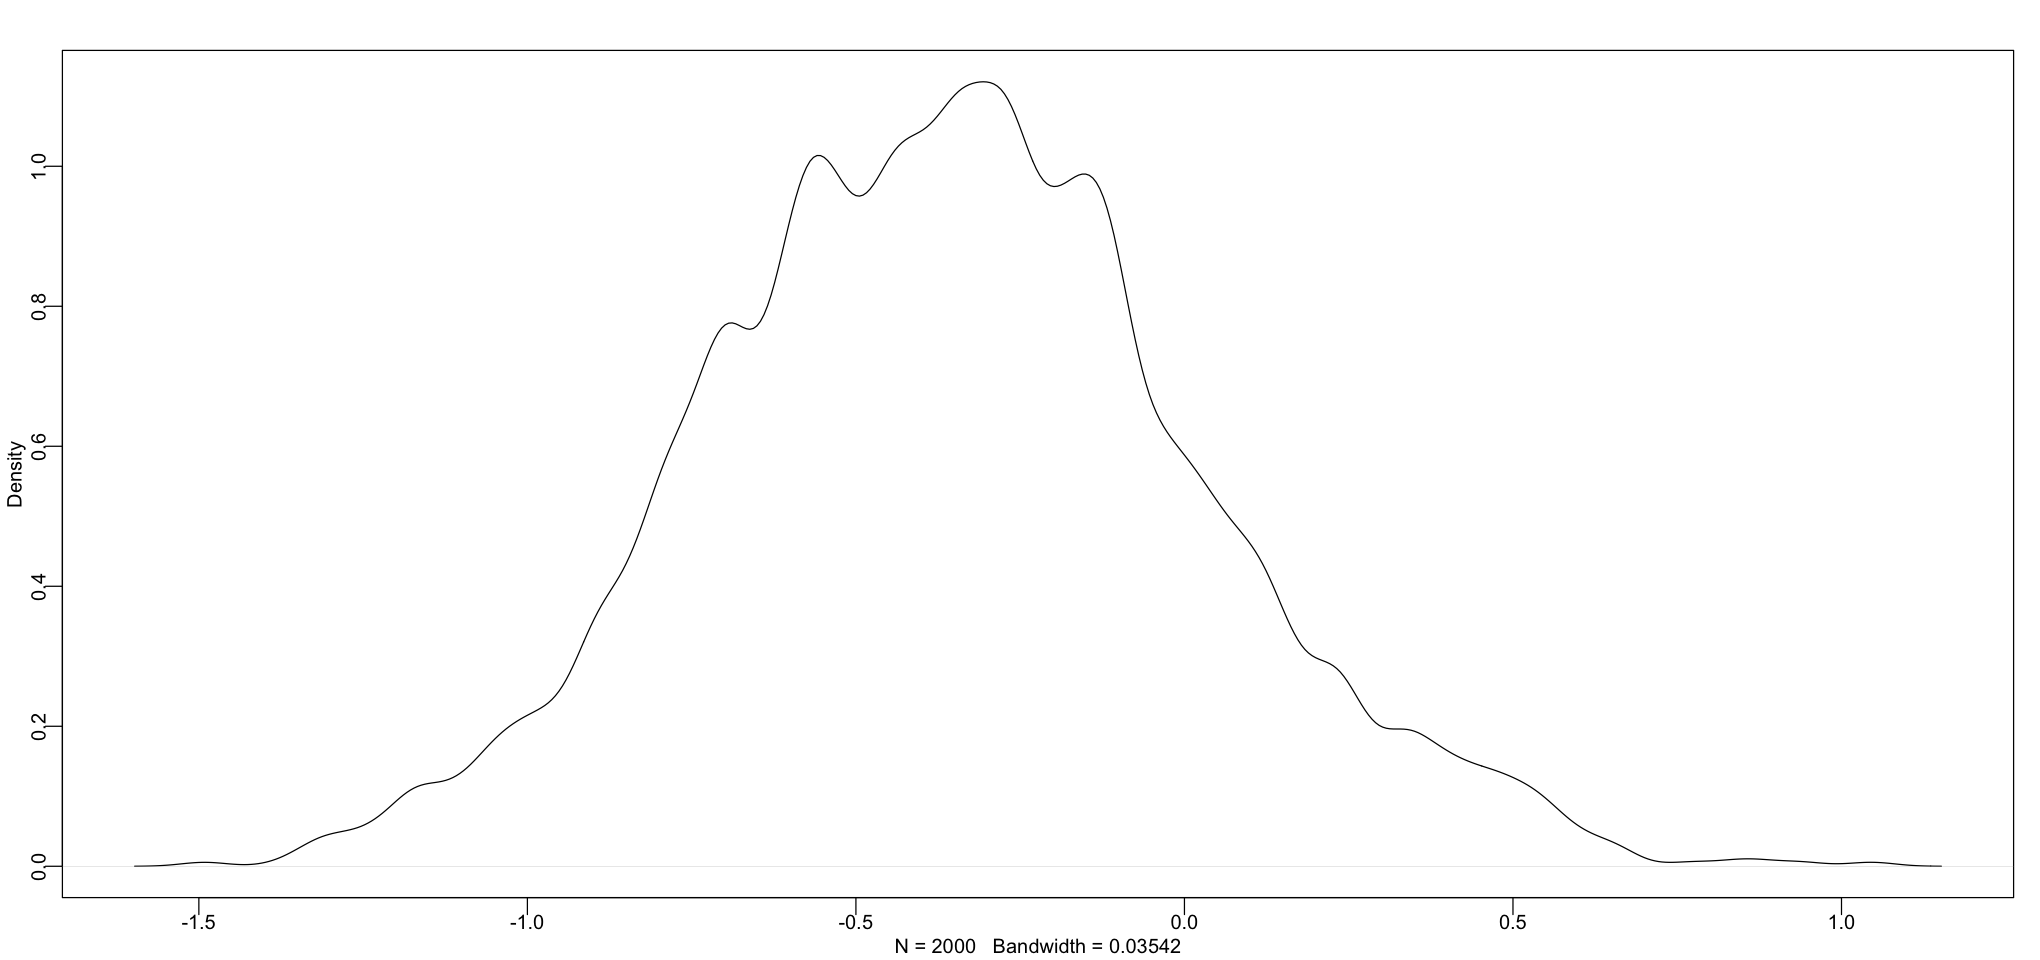

In [ ]:
# plotting the density for actor 5
par(bg = 'white')
dens(post$a[, 5])

To construct the posterior predictions, we build our own link function.

In [ ]:
p_link <- function(treatment, actor = 1, block_id = 1) {
    logodds <- with(post,
        a[, actor] + g[, block_id] + b[, treatment]
    )
    return(inv_logit(logodds))
}

In [ ]:
p_raw <- sapply(1:4, function(i) p_link(i, actor = 2, block_id = 1))
p_mu <- apply(p_raw, 2, mean)
p_ci <- apply(p_raw, 2, PI)

### Posterior prediction for new clusters

When we're making predictions for new clusters, we're trying to generalize the model to go outside of our data. There's no one, cut-and-dried approach to this; it will depend on the situation, the data, the model, &c.

As an example, let's try to imagine that we are running the chimpanzee experiment with new chimpanzees. ATM we have a bunch of actor-level intercepts for the ones in the trial, but that's not really helpful because we are now trying to make the model work on new actors.

However, we can make use of the $\bar{\alpha}$ and $\sigma_\alpha$ parameters (the adaptive prior parameters)!

One approach might be to make the prediction for an 'average' actor (one whose mean is $\bar{\alpha}$).

We'll have to make a new link function:

In [ ]:
p_link_abar <- function(treatment) {
    logodds <- with(post,
        a_bar + b[, treatment]
    )
    return(inv_logit(logodds))
}

(We're ignoring `block` because this trial will be using new blocks and we're assuming that the effect of the block is basically zero anyway).

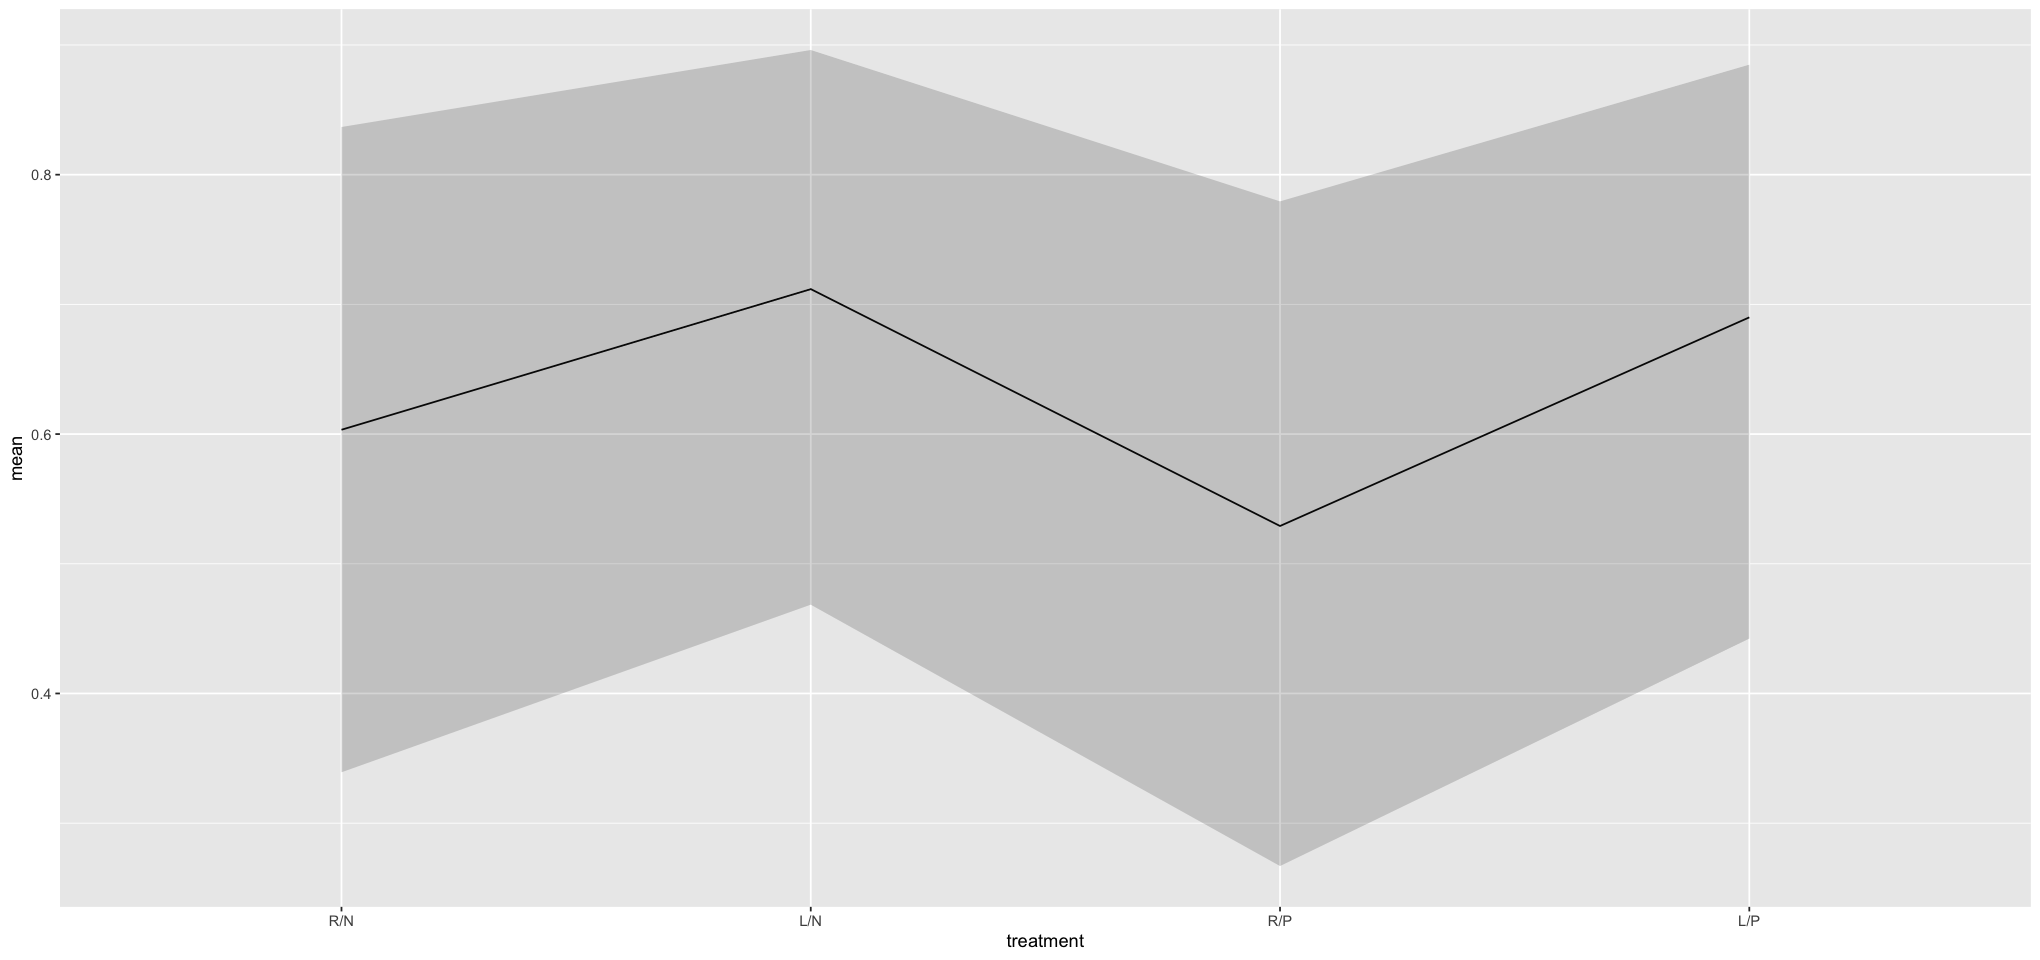

In [ ]:
post <- extract.samples(m13.4)
p_raw <- sapply(1:4, function(i) p_link_abar(i))
p_mu <- apply(p_raw, 2, mean)
p_ci <- apply(p_raw, 2, PI)

plot_df <- data.frame(
    treatment=c("R/N", "L/N", "R/P", "L/P"),
    mean = p_mu,
    lower = p_ci[1, ],
    upper = p_ci[2, ]
)
plot_df$treatment <- factor(plot_df$treatment, levels = plot_df$treatment)
# plot_df
ggplot(plot_df, aes(treatment, group = 1)) +
    geom_line(aes(y = mean)) +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2)

This is great, but it doesn't really show the potential variation among the new actors. This is strictly for an average chimpanzee!

To capture the variation, let's simulate a bunch of new chimpanzees using `rnorm` with mean `a_bar` and sd `sigma_a`! We'll have to do this outside of the link function because we want to be referencing the same population of simulated chimpanzees regardless of the treatment.

In [ ]:
a_sim <- with(post,
    rnorm(length(post$a_bar), a_bar, sigma_a)
)
p_link_asim <- function(treatment) {
    logodds <- with(post,
        a_sim + b[, treatment]
    )
    return(inv_logit(logodds))
}
p_raw_asim <- sapply(1:4, function(treatment) p_link_asim(treatment))

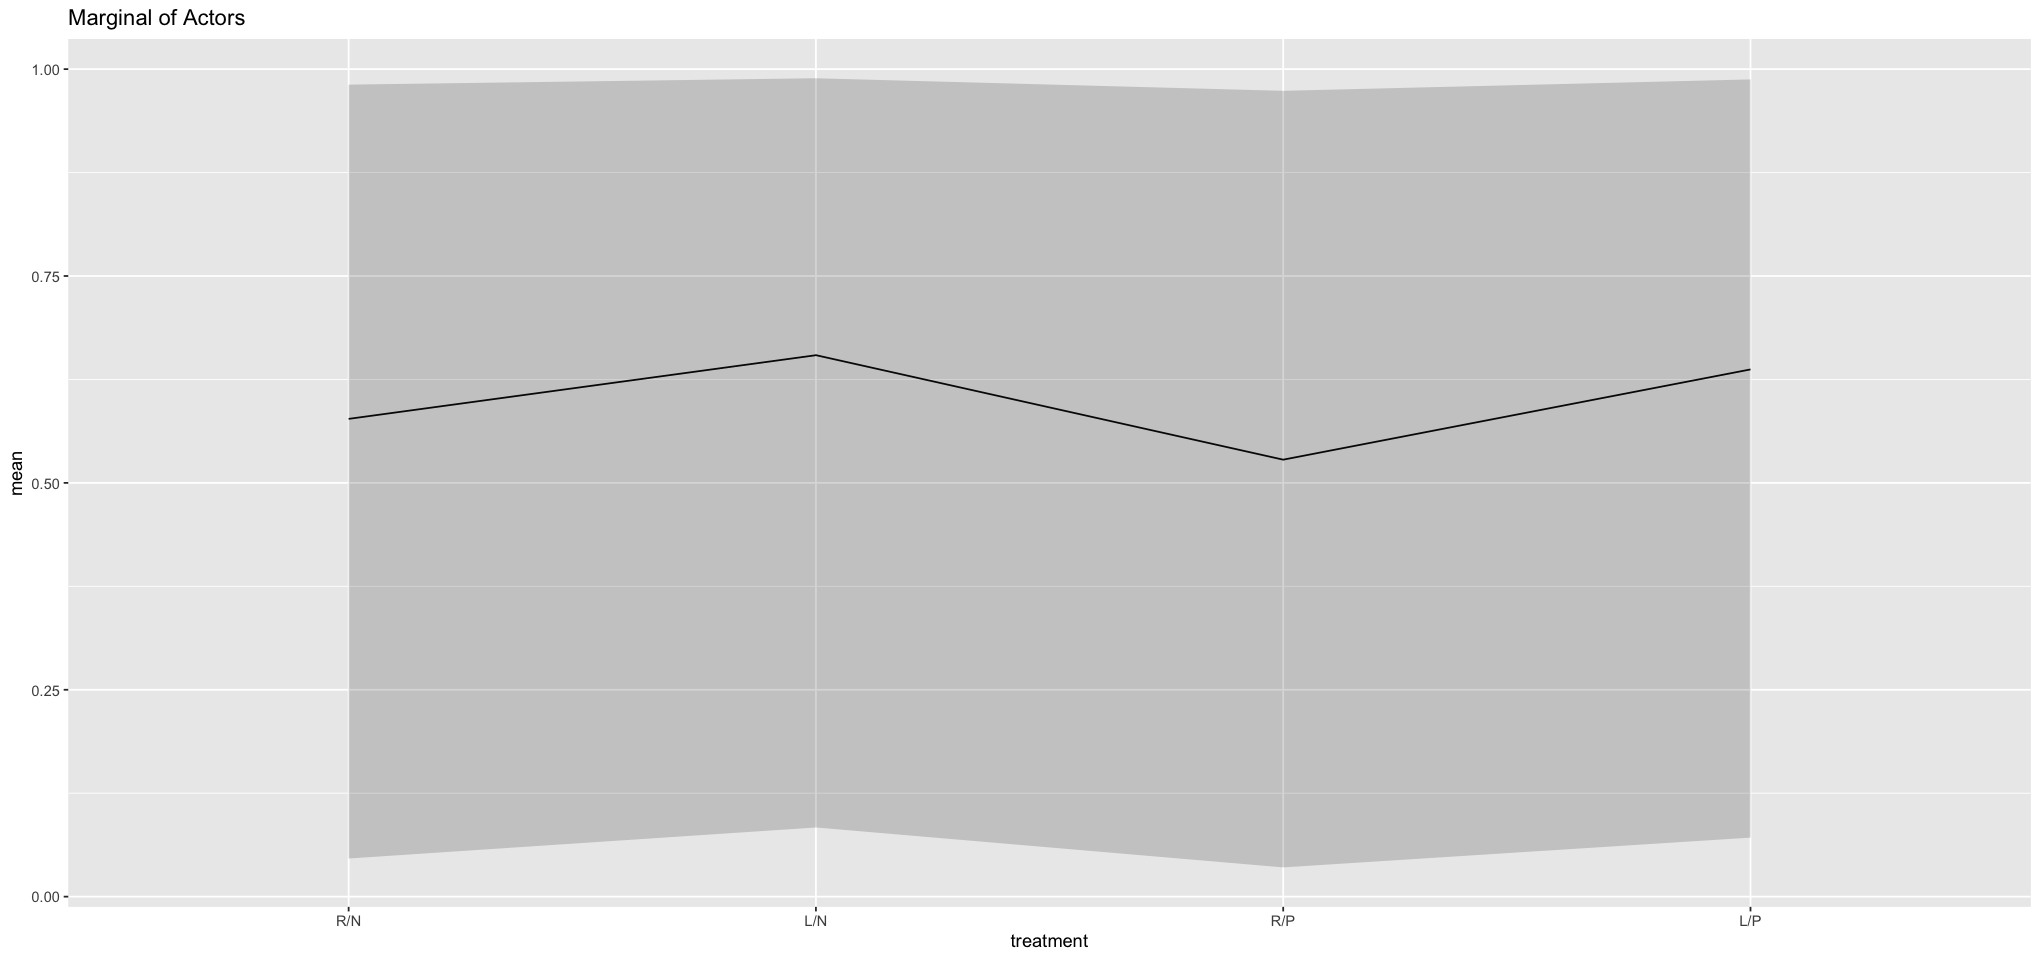

In [ ]:
p_mu <- apply(p_raw_asim, 2, mean)
p_ci <- apply(p_raw_asim, 2, PI)

plot_df <- data.frame(
    treatment=c("R/N", "L/N", "R/P", "L/P"),
    mean = p_mu,
    lower = p_ci[1, ],
    upper = p_ci[2, ]
)
plot_df$treatment <- factor(plot_df$treatment, levels = plot_df$treatment)
# plot_df
ggplot(plot_df, aes(treatment, group = 1)) +
    geom_line(aes(y = mean)) +
    geom_ribbon(aes(ymin = lower, ymax = upper), alpha = 0.2) +
    labs(title = "Marginal of Actors")

This is obviously showing something different. Instead of the expected results from a perfectly average actor, this is the result of a bunch of roughly average actors with the kind of variation that we saw in the data.

So... which of these approaches (single average actor or roughly average population) should we use? It depends on the question being asked! The single average actor is more useful when trying to see the effect of the treatment, whereas the population results are more useful in terms of letting us know what we can expect from our next experiment.

In fact, we can do better - we can simply plot the results for each of the simulated actors as discrete lines!

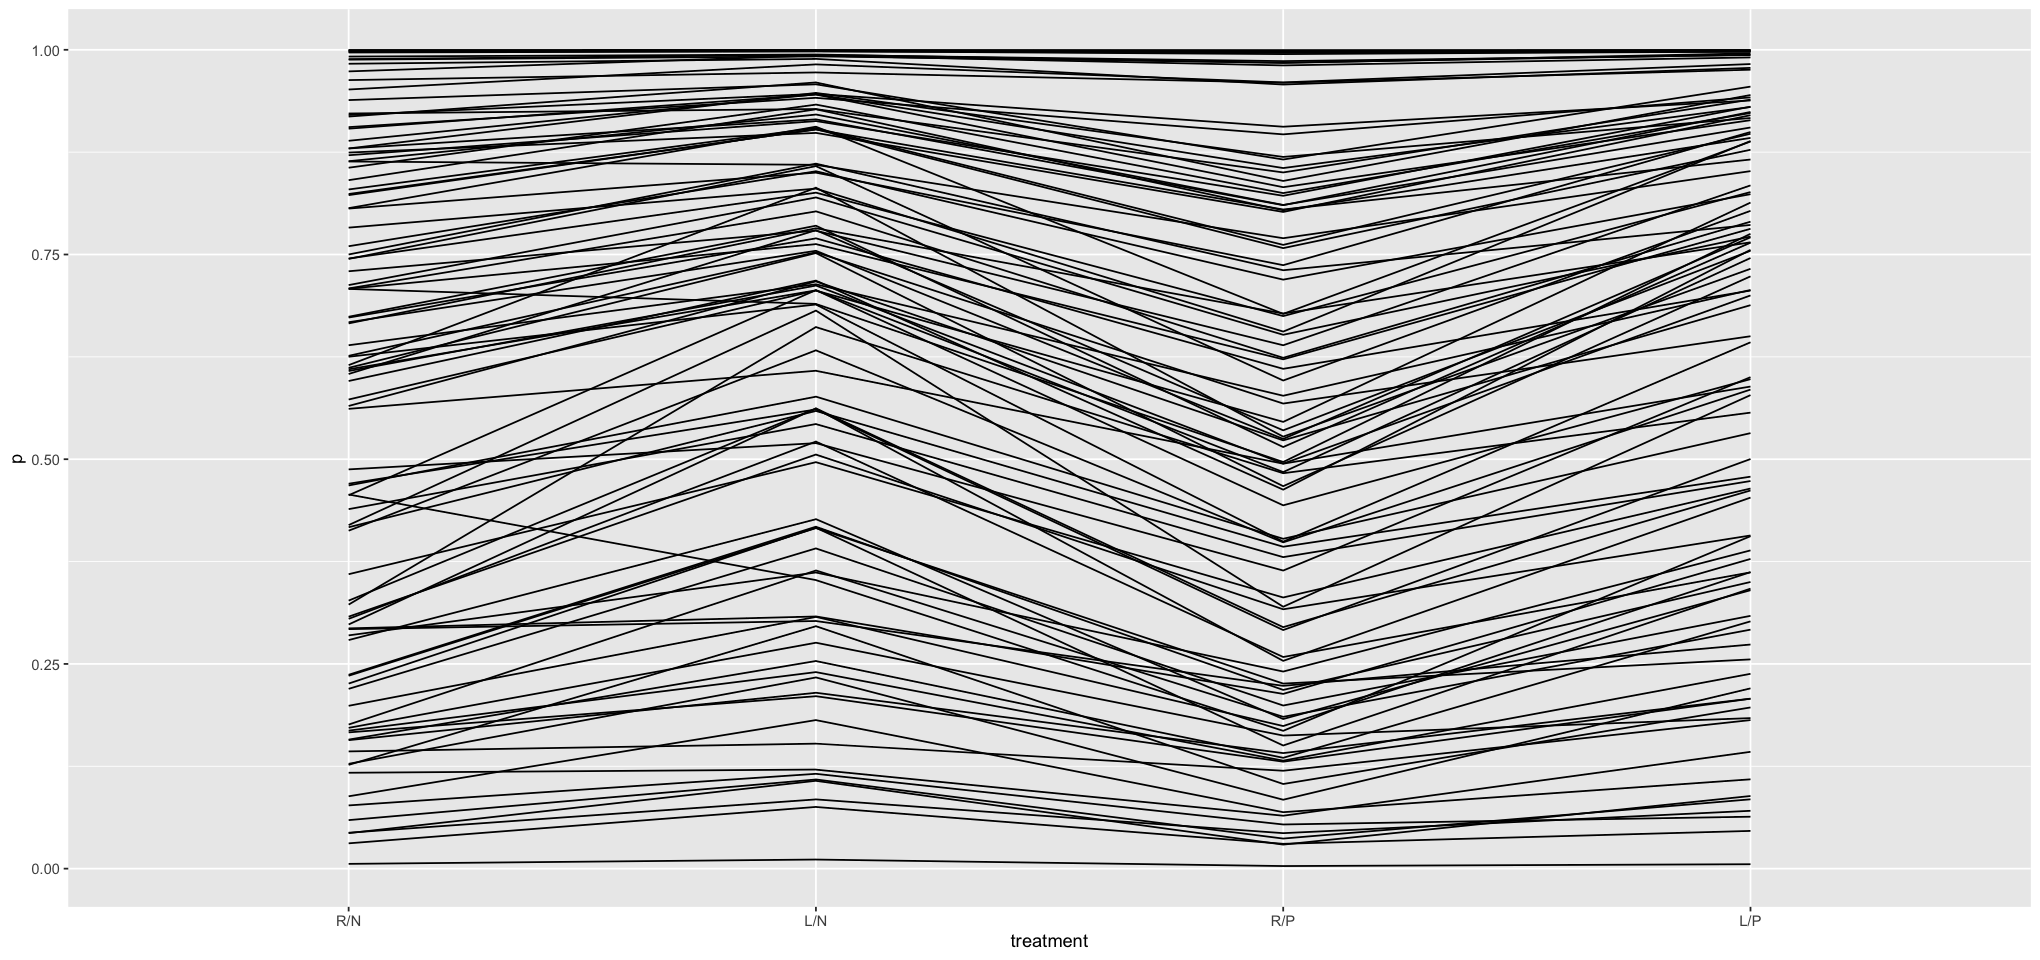

In [ ]:
plot_df <- data.frame(
    treatment= character(),
    p = numeric(),
    actor = integer()
)

for (i in 1:100) {
    plot_df <- rbind(plot_df,
        data.frame(
            treatment = c("R/N", "L/N", "R/P", "L/P"),
            p = p_raw_asim[i, ],
            actor = i
        )
    )
}
plot_df$treatment <- factor(plot_df$treatment, levels = c("R/N", "L/N", "R/P", "L/P"))

ggplot(plot_df, aes(treatment, p, group = actor)) +
    geom_line()

One interesting thing to note is that for actors with very large or very small intercepts (near the top or bottom of the plot), the treatment has esically no effect. This is because they start with a very strong preference for pulling right or left! For the ones in the middle (no strong 'handedness') we see a big effect.

## Post-stratification

A common problem is how to take a non-representative sample and extrapolate to the rest of the population. For instance, you might ask a bunch of voters how they're going to vote. However, some groups will respond at different rates, and so you need to account for this. The survey is biased by the response rate.

On technique is [[Post-Stratification]]. The idea is to fit a model where each slice of the population (age, economic, education, &c.) has its own voting intention. Then the estimates of these intentions are re-weighted using a census of the full population. However, some of the groups can be small, with only a few estimates. Thus, post-stratification is often combined with multilevel modelling, in which case with is called [[Multilevel Modelling and Post-Stratification]], or MRP (pronounced "Mister P").

How does this work?

Say you have estimates $p_i$ for each category. Then the post-stratified prediction for the entire population is a re-weighting using the number of people in each category:

$$
\frac{\sum_i N_i p_i}{\sum_i N_i}
$$

Post-stratification doesn't always work. For instance, when selection bias is caused by the outcome of interest. For instance, suppose that responding to the survey, $R$, is influenced by age $A$, and that age $A$ influences boting entention $V$: $R \leftarrow A \to V$. The it is possible to estimate the influence of $A$ on $V$. But if $V \to R$, then there is little hope. Suppose that only supporters responded. Then $V=1$ for everyone who responds, which will of course make generalization to the rest of the population impossible. Selection on the outcome variable is one of the worst things that can happen in statistics.

A general framework for generalizability is [[Transportability]]. Post-stratification is a special case of this framework, as are meta-analyses and the application of estimates across populations.

## Practice

**13E1** Which of the following priors will produce more shinkage in the estimate? $\alpha_[\text{TANK}] \sim \text{Normal}(0, 1)$ or $\alpha_[\text{TANK}] \sim \text{Normal}(0, 2)$

**Answer** The first one will. It's a stronger prior, and will thus tend to cause the other estimates to 'shrink' toward it more.

**13E2** Rewrite the following as a multilevel model

$$
\begin{align*}
y_i &\sim \text{Binomial}(1, p_i) \\
\text{logit}(p_i) &= \alpha_{ \text{GROUP}[i]  } + \beta x_i \\
\alpha_{\text{GROUP}} &\sim \text{Normal(0, 1.5)} \\
\beta &\sim \text{Normal}(0, 0.5) \\
\end{align*}
$$

**Answer** Basically, we want to have an adaptive prior here. What we'll do is to make the prior for $\alpha$ based on the group level

$$
\begin{align*}
y_i &\sim \text{Binomial}(1, p_i) \\
\text{logit}(p_i) &= \alpha_{ \text{GROUP}[i]  } + \beta x_i \\
\alpha_{\text{GROUP}} &\sim \text{Normal}(\bar{\alpha}, \sigma_\alpha) \\
\bar\alpha &\sim \text{Normal(0, 1)} \\
\sigma_\alpha &\sim \text{Exponential}(1) \\
\beta &\sim \text{Normal}(0, 0.5) \\
\end{align*}
$$

(The numbers for the new hyperpriors, $\bar\alpha$ and $\sigma_\alpha$, and largely made up; without knowing more about the situation it's hard to evaluate how accurate they are).

**13E3** Rewrite the following as a multilevel model

$$
\begin{align*}
y_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_{\text{GROUP}[i]} + \beta x_i \\
\alpha_{\text{GROUP}} &\sim \text{Normal}(0, 5) \\
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

**Answer** Same as before, we'll replace the prior for $\alpha$ with an adaptive one:

$$
\begin{align*}
y_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha_{\text{GROUP}[i]} + \beta x_i \\
\alpha_{\text{GROUP}} &\sim \text{Normal}(\bar\alpha, \sigma_\alpha) \\
\bar\alpha &\sim \text{Normal}(0, 1) \\
\sigma_\alpha &\sim \text{Exponential}(2) \\
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

**13E4** Write a mathemtical model formulat for a Poisson regression with varying intercepts.

**Answer** For this, we're going to take a normal Poisson regression and include adaptive parameters (the varying intercepts):
$$
\begin{align*}
y_i &\sim \text{Poisson}(\lambda_i) \\
\log \lambda_i &\sim \alpha_{ \text{GROUP}[i] } \\
\alpha_\text{GROUP} &\sim \text{Normal}(\bar\alpha, \sigma_\alpha) \\
\bar\alpha &\sim \text{Normal}(0, 1) \\
\sigma_\alpha &\sim \text{Exponential}(1)
\end{align*}
$$

**13E5** Write a mathematical model formula for a Poisson regression with two different kinds of varying intercepts, a cross-classified model.

**Answer** Here we'll introduce another intercept ($\beta$) which tracks a made-up BLOCK (so now each item is part of a GROUP and a BLOCK):
$$
\begin{align*}
y_i &\sim \text{Poisson}(\lambda_i) \\
\log \lambda_i &\sim \alpha_{\text{GROUP}[i]} + \beta_{\text{BLOCK}[i]} \\
\alpha_\text{GROUP} &\sim \text{Normal}(\bar\alpha, \sigma_\alpha) \\
\beta_\text{BLOCK} &\sim \text{Normal}(\bar\beta, \sigma_\beta) \\
\bar\alpha &\sim \text{Normal}(0, 1) \\
\sigma_\alpha &\sim \text{Exponential}(1) \\
\bar\beta &\sim \text{Normal}(0, 1) \\
\sigma_\beta &\sim \text{Exponential}(1)
\end{align*}
$$

**13M1** Revisit the Reed frog survival data, `data(reedfrogs)`, and add the `predation` and `size` treatment variables to the varying intercepts model. Consider models with either main effect along,both main effects, as well as a model including both and their interaction. Instead of focusing on inferences about thoses two predictor variables, focus on the inferred variation across tanks. Explain why it changes as it does across models.

**Answer**

In [ ]:
data(reedfrogs)
d <- reedfrogs
str(d)

'data.frame':	48 obs. of  5 variables:
 $ density : int  10 10 10 10 10 10 10 10 10 10 ...
 $ pred    : Factor w/ 2 levels "no","pred": 1 1 1 1 1 1 1 1 2 2 ...
 $ size    : Factor w/ 2 levels "big","small": 1 1 1 1 2 2 2 2 1 1 ...
 $ surv    : int  9 10 7 10 9 9 10 9 4 9 ...
 $ propsurv: num  0.9 1 0.7 1 0.9 0.9 1 0.9 0.4 0.9 ...


Recall that the varying effects model was

$$
\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{TANK}[i]} \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma) & \text{for $j = 1\dots 48$} \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

In [ ]:
d$tank <- 1:nrow(d)

dat <- list(
    S = d$surv,
    N = d$density,
    tank = d$tank
)
m13m1.1 <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fee6c96a3.stan', line 15, column 4 to column 32)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 3 finished in 0.1 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.1 seconds.
Total execution time: 0.5 seconds.



Now we need

a) predation only
b) size only
c) predation and size
d) predation, size, and their interaction

For both of these, the variables are factors $\to$ we need to switch them for variables / indices:

In [ ]:
d$pred_index <- ifelse(d$pred == 'no', 1L, 2L)
d$size_index <- ifelse(d$size == 'small', 1L, 2L)
d$pred_size_index <- 2 * (d$pred_index - 1) + (d$size_index - 1) + 1

summary(d)

    density        pred       size         surv          propsurv     
 Min.   :10.00   no  :24   big  :24   Min.   : 4.00   Min.   :0.1143  
 1st Qu.:10.00   pred:24   small:24   1st Qu.: 9.00   1st Qu.:0.4964  
 Median :25.00                        Median :12.50   Median :0.8857  
 Mean   :23.33                        Mean   :16.31   Mean   :0.7216  
 3rd Qu.:35.00                        3rd Qu.:23.00   3rd Qu.:0.9200  
 Max.   :35.00                        Max.   :35.00   Max.   :1.0000  
      tank         pred_index    size_index  pred_size_index
 Min.   : 1.00   Min.   :1.0   Min.   :1.0   Min.   :1.00   
 1st Qu.:12.75   1st Qu.:1.0   1st Qu.:1.0   1st Qu.:1.75   
 Median :24.50   Median :1.5   Median :1.5   Median :2.50   
 Mean   :24.50   Mean   :1.5   Mean   :1.5   Mean   :2.50   
 3rd Qu.:36.25   3rd Qu.:2.0   3rd Qu.:2.0   3rd Qu.:3.25   
 Max.   :48.00   Max.   :2.0   Max.   :2.0   Max.   :4.00   

So then our model for e.g. including predation look like

$$
\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{TANK}[i]} + \beta_{\text{PREDATION}[i]} \\
\beta &\sim \text{Normal}(0, 1.5) \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma) & \text{for $j = 1\dots 48$} \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

size only looks like
$$
\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{TANK}[i]} + \gamma_{\text{SIZE}[i]} \\
\gamma &\sim \text{Normal}(0, 1.5) \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma) & \text{for $j = 1\dots 48$} \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

both (no interaction) looks like

$$
\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{TANK}[i]} + \beta_{\text{PREDATION}[i]} + \gamma_{\text{SIZE}[i]} \\
\beta &\sim \text{Normal}(0, 1.5) \\
\gamma &\sim \text{Normal}(0, 1.5) \\
\eta &\sim \text{Normal}(0, 1.5) \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma) & \text{for $j = 1\dots 48$} \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

and both (with interaction) looks like

$$
\begin{align*}
S_i &\sim \text{Binomial}(N_i, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{TANK}[i]} + \beta_{\text{PREDATION}[i]} + \gamma_{\text{SIZE}[i]} + \eta_{\text{PREDATION\_SIZE}[i]}\\
\beta &\sim \text{Normal}(0, 1.5) \\
\gamma &\sim \text{Normal}(0, 1.5) \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma) & \text{for $j = 1\dots 48$} \\
\bar{\alpha} &\sim \text{Normal}(0, 1.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

In [ ]:
dat <- list(
    S = d$surv,
    N = d$density,
    tank = d$tank,
    pred_index = d$pred_index,
    size_index = d$size_index,
    pred_size_index = d$pred_size_index
)
# predation
m13m1.pred <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank] + b[pred_index],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1),
        b[pred_index] ~ dnorm(0, 1.5)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)

# size
m13m1.size <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank] + g[size_index],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1),
        g[size_index] ~ dnorm(0, 1.5)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)

# predation and size (no interaction)
m13m1.pred_size_no_interaction <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank] + b[pred_index] + g[size_index],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1),
        b[pred_index] ~ dnorm(0, 1.5),
        g[size_index] ~ dnorm(0, 1.5)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)


Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fe2cb74ac6.stan', line 20, column 4 to column 32)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fe2cb74ac6.stan', line 20, column 4 to column 32)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.2 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fe2cb74ac6.stan', line 20, column 4 to column 32)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 0.2 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.2 seconds.
Total execution time: 0.9 seconds.

Running MCMC with 4 sequential 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fe2bb93533.stan', line 20, column 4 to column 32)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 



Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.2 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.2 seconds.
Total execution time: 0.9 seconds.

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampli

In [ ]:
# predation and size (interaction)
m13m1.pred_size_interaction <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank] + b[pred_index] + g[size_index] + e[pred_size_index],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1),
        b[pred_index] ~ dnorm(0, 1.5),
        g[size_index] ~ dnorm(0, 1.5),
        e[pred_size_index] ~ dnorm(0, 1.5)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.4 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

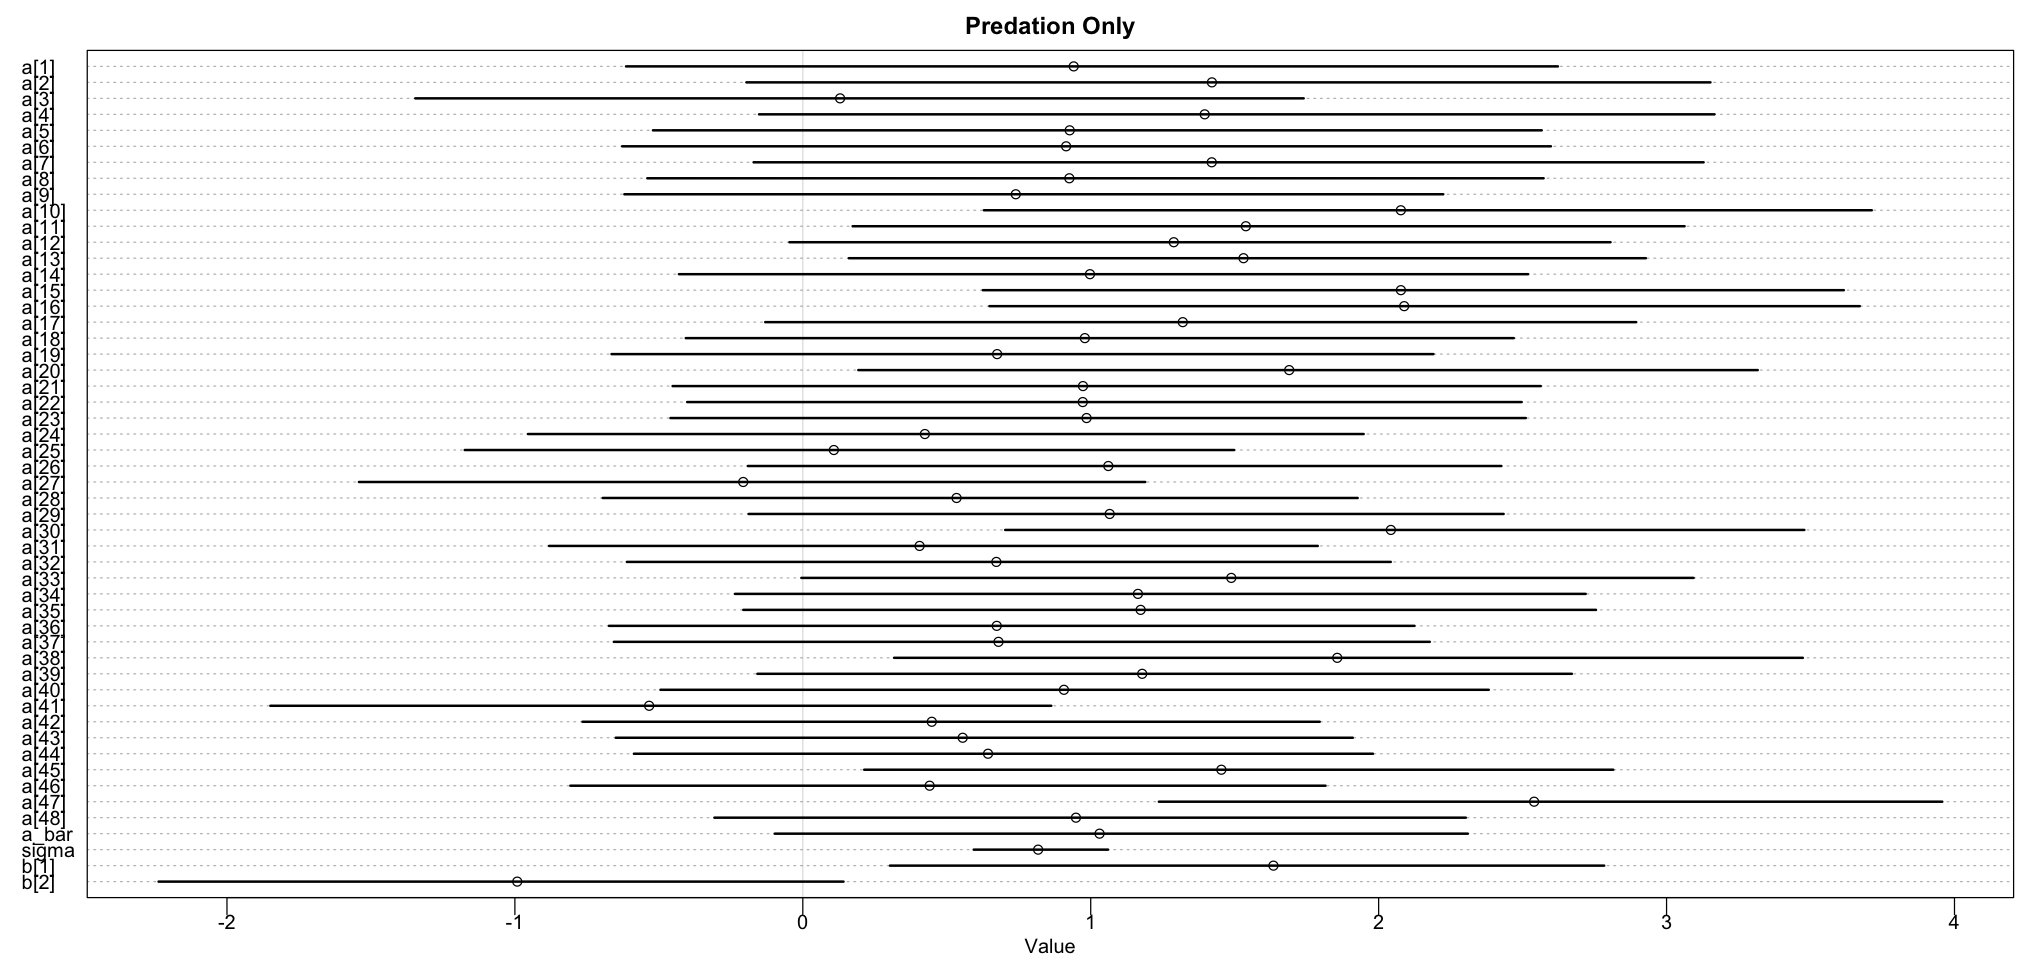

In [ ]:
par(bg = 'white')
plot(precis(m13m1.pred, depth = 2), main = "Predation Only")

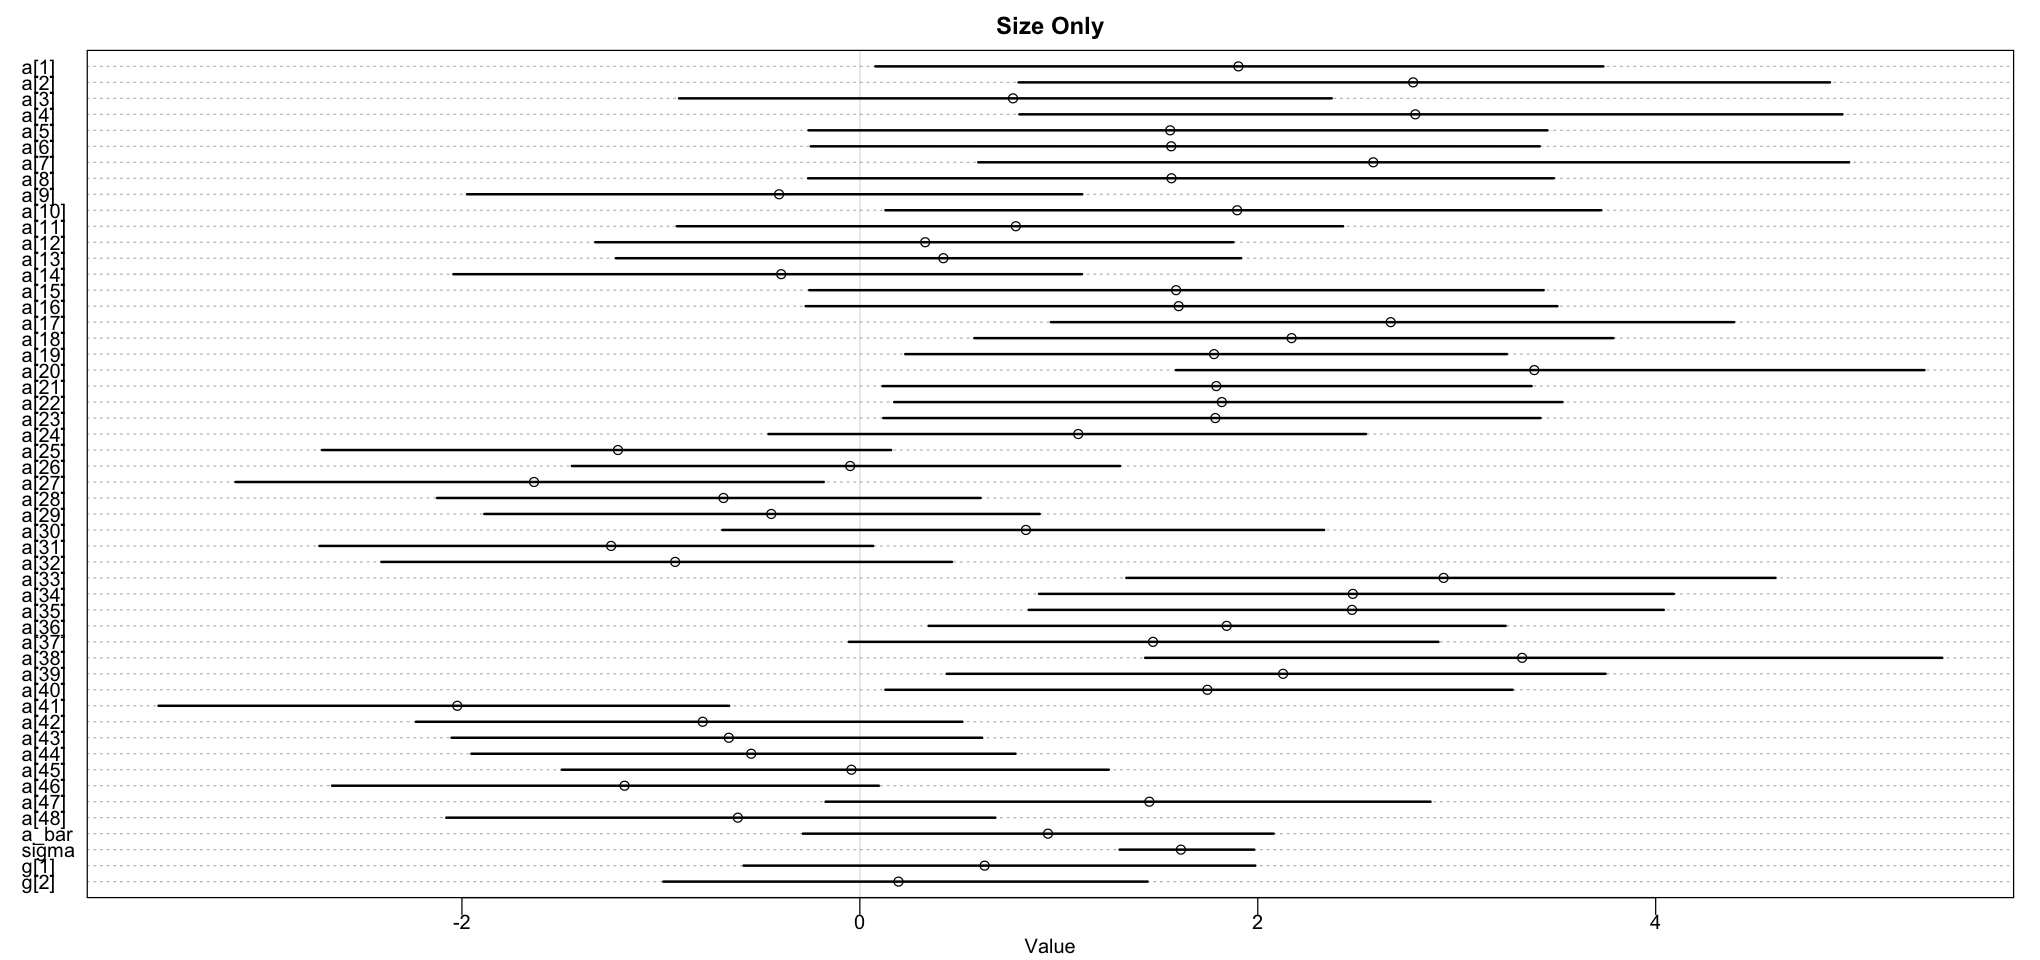

In [ ]:
par(bg = 'white')
plot(precis(m13m1.size, depth = 2), main = "Size Only")

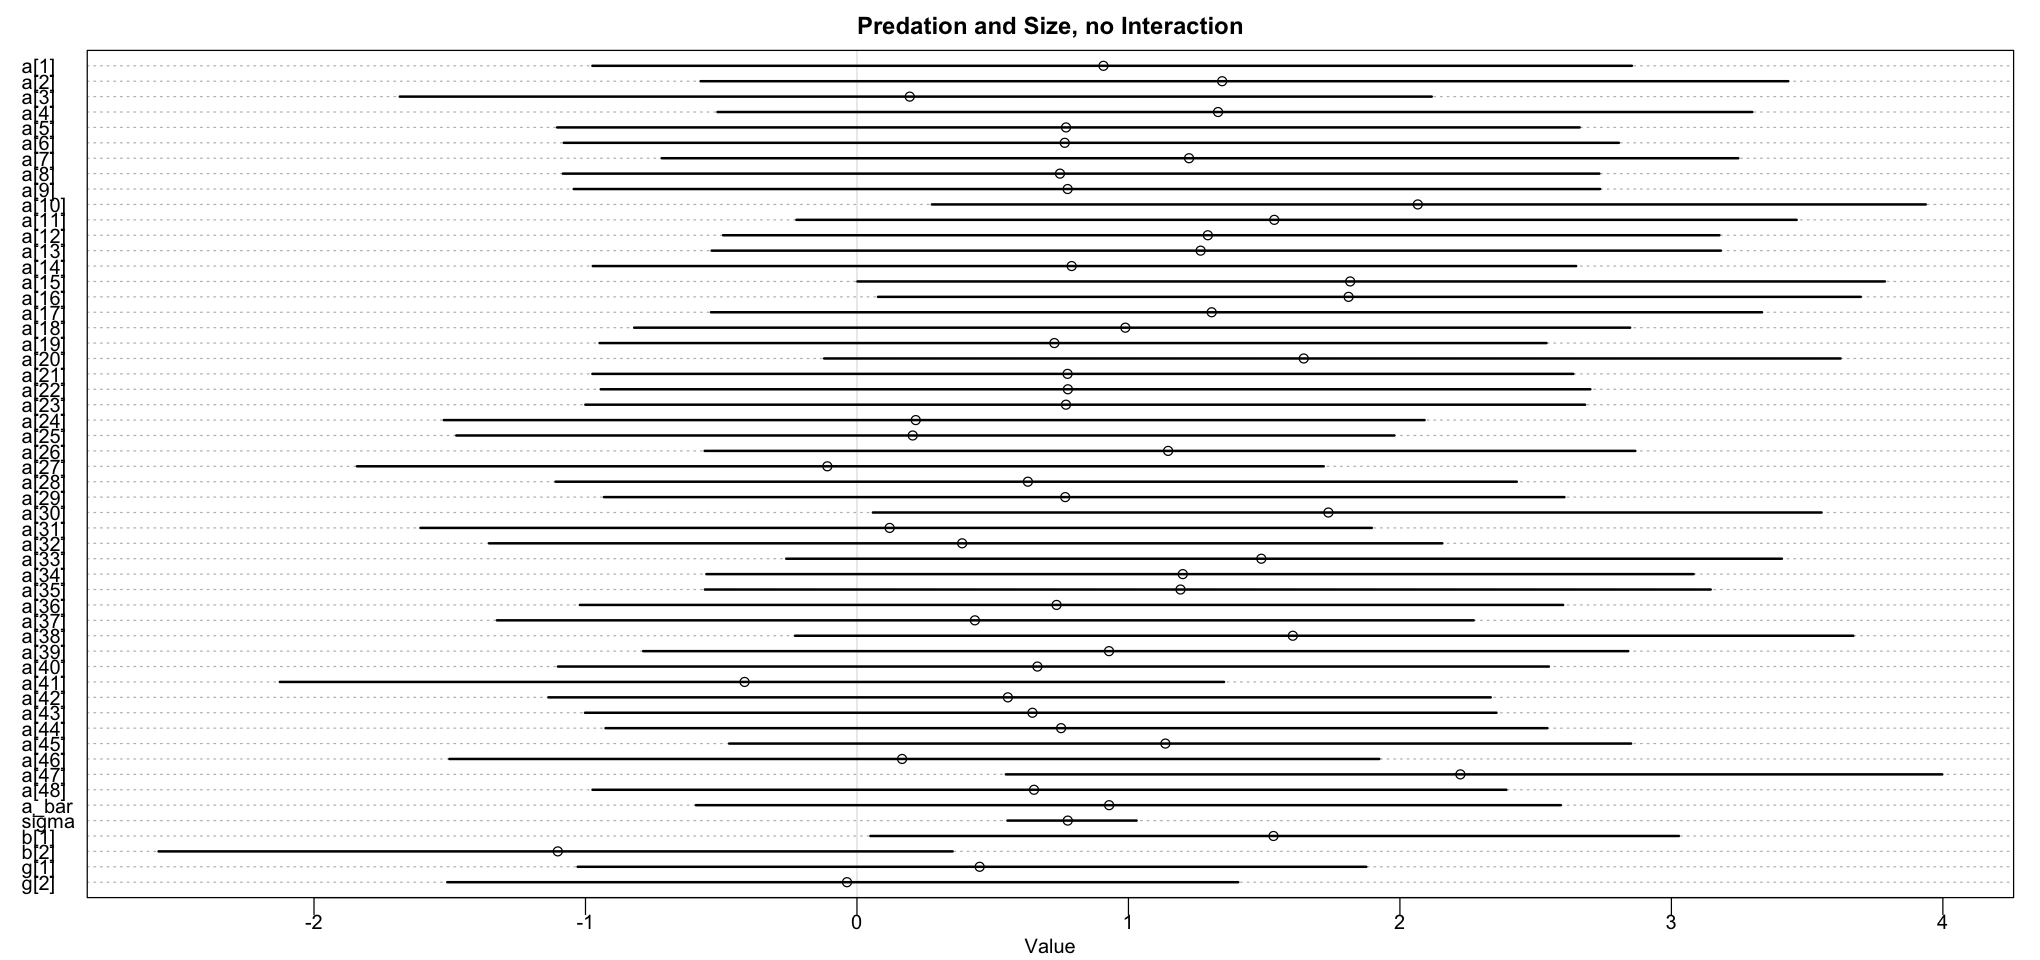

In [ ]:
par(bg = 'white')
plot(precis(m13m1.pred_size_no_interaction, depth = 2), main = "Predation and Size, no Interaction")

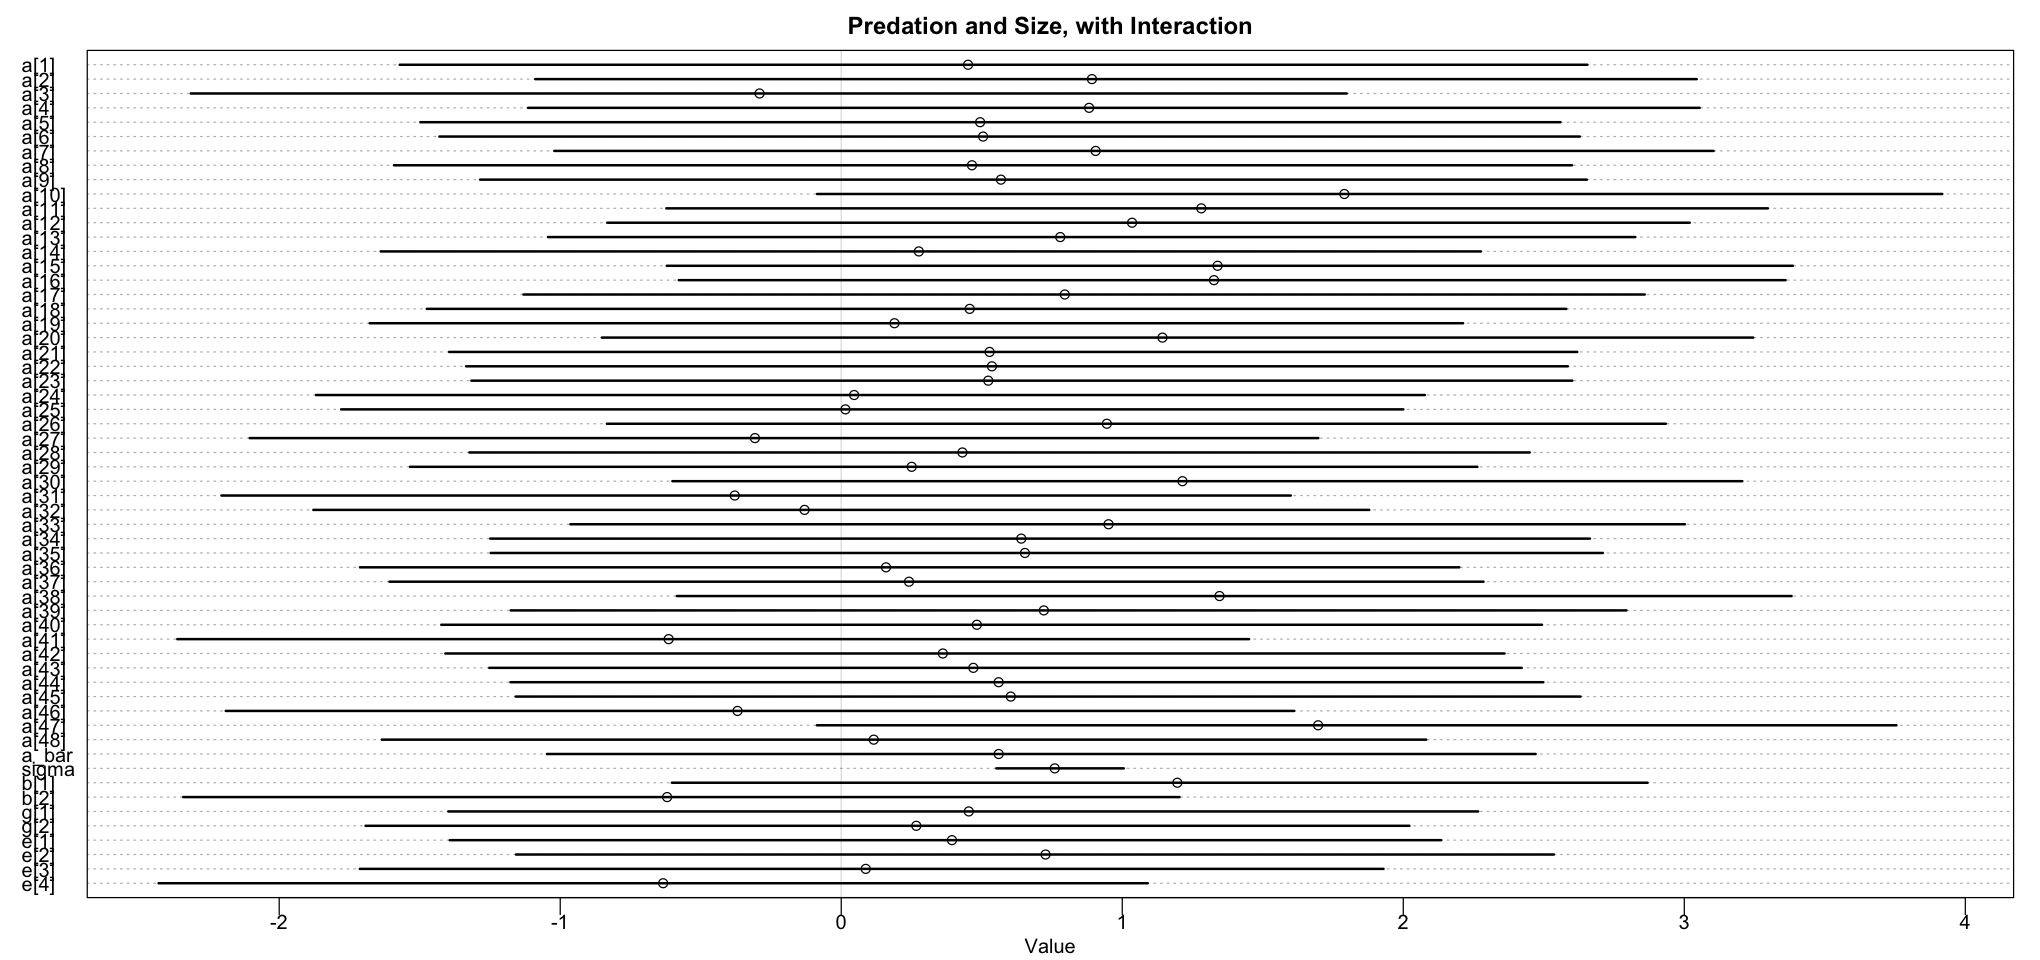

In [ ]:
par(bg = 'white')
plot(precis(m13m1.pred_size_interaction, depth = 2), main = "Predation and Size, with Interaction")

If we're looking at the variation across tanks, that's encoded in the `sigma` parameter. Let's look at that.

In [ ]:
pred_only <- extract.samples(m13m1.pred)$sigma
size_only <- extract.samples(m13m1.size)$sigma
pred_size_no_interaction <- extract.samples(m13m1.pred_size_no_interaction)$sigma
pred_size_interaction <- extract.samples(m13m1.pred_size_interaction)$sigma

model_samples <- list(pred_only, size_only, pred_size_no_interaction, pred_size_interaction)

model                             mean      lower     upper   
1 Predation Only                    0.8172831 0.5523644 1.119904
2 Size Only                         1.6137932 1.2608868 2.097616
3 Predation & Size (No Interaction) 0.7764043 0.5063266 1.110379
4 Predation & Size (Interaction)    0.7597950 0.5167539 1.069664

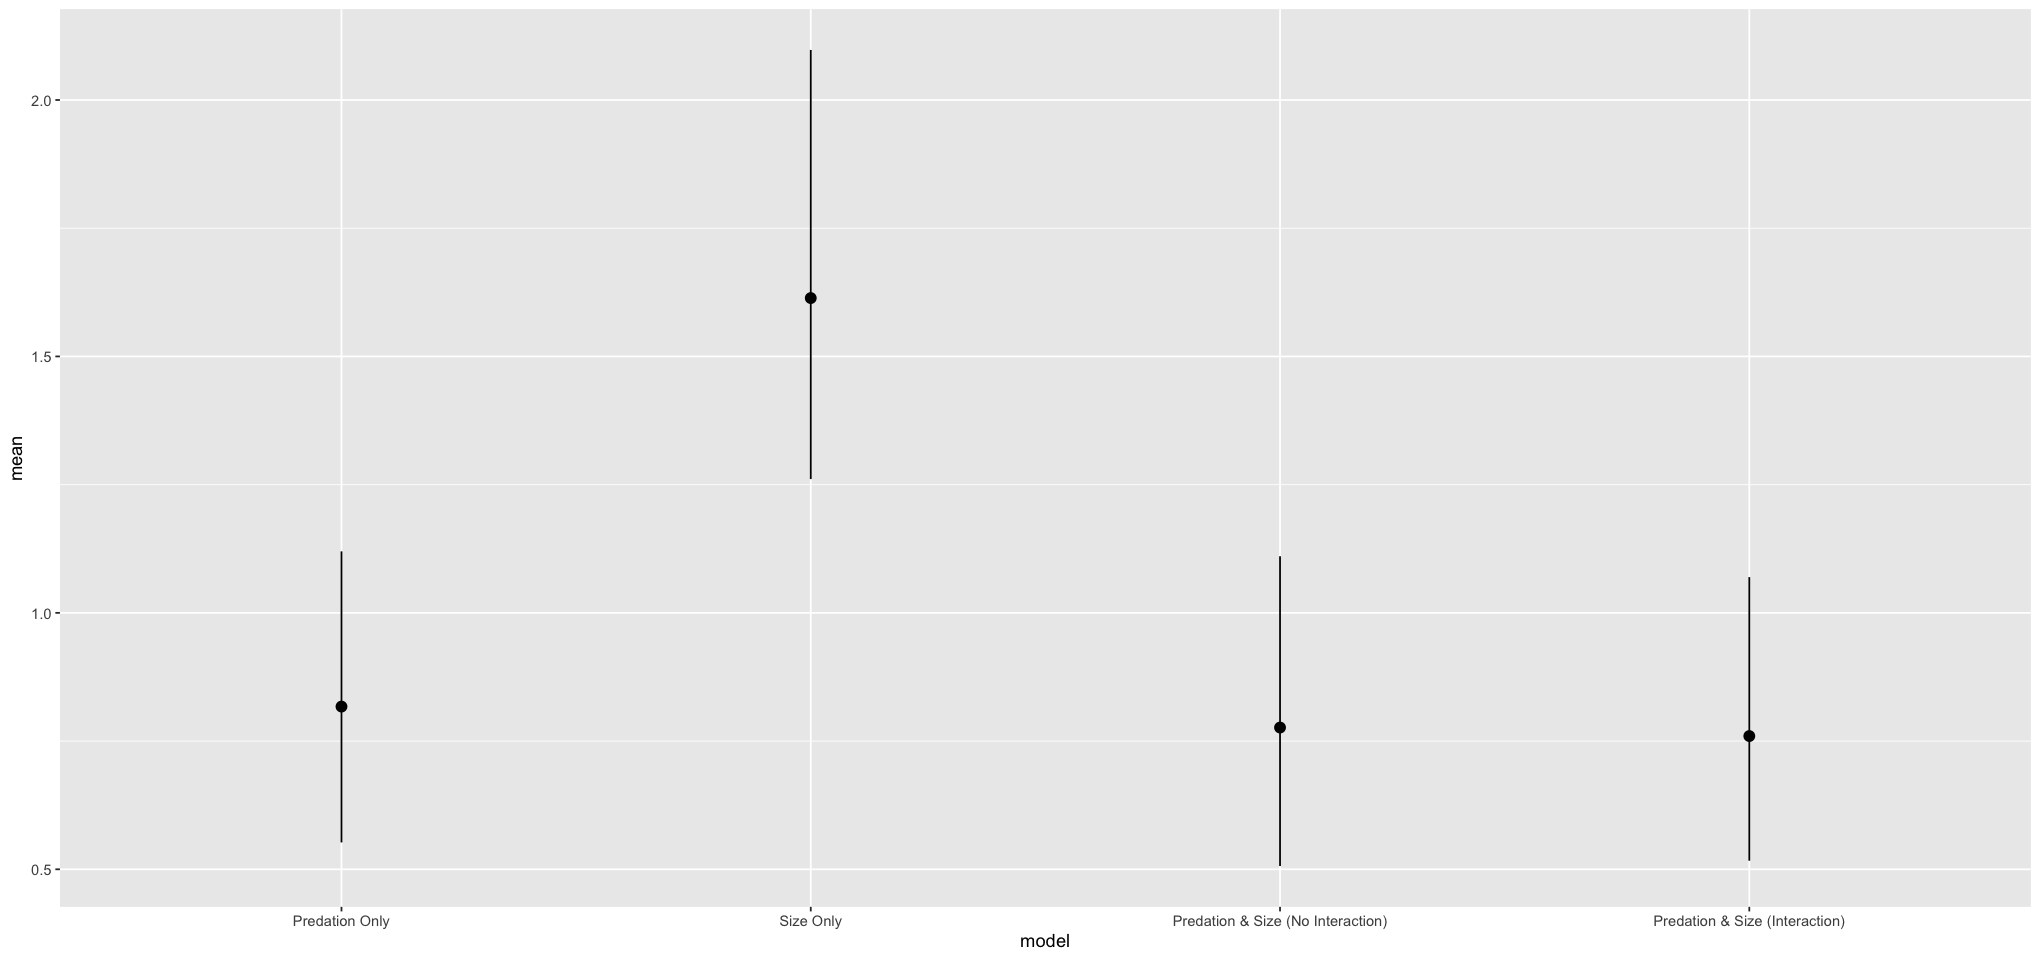

In [ ]:
model_descriptions <- c("Predation Only", "Size Only", "Predation & Size (No Interaction)", "Predation & Size (Interaction)")
plot_df <- data.frame(
    model = factor(model_descriptions, levels = model_descriptions),
    mean = sapply(model_samples, mean),
    lower = sapply(model_samples, function(c) quantile(c, 0.025)),
    upper = sapply(model_samples, function(c) quantile(c, 0.975))
)
plot_df


ggplot(plot_df, aes(model)) +
    geom_pointrange(aes(y = mean, ymin = lower, ymax = upper))

From the above, it's clear that `sigma` is materially larger for the size only model and basically the same for each of the other models.

Looking at the earlier plots of the parameter values, it seems that what is happening is that the absence or presence of predation is having a large explanatory effect - the $\beta$ parameters are large. Since they have such a good explanatory effect, the model that's missing them, the "Size Only" model, has incorporated the uncertainty into a larger $\sigma$ variable.

**13M2** Compare the models you fit using WAIC. Can you reconcile the differences in WAIC with the posterior distributions of the model?

**Answer**

In [ ]:
compare(m13m1.pred, m13m1.size, m13m1.pred_size_no_interaction, m13m1.pred_size_interaction, func = WAIC)

WAIC     SE       dWAIC    dSE      pWAIC   
m13m1.pred                     199.2979 9.317249 0.000000       NA 19.22281
m13m1.pred_size_interaction    200.6637 9.650396 1.365797 3.338249 19.71828
m13m1.pred_size_no_interaction 200.7702 8.893776 1.472390 2.181174 19.45172
m13m1.size                     200.9968 7.297595 1.698914 6.351048 21.23925
                               weight   
m13m1.pred                     0.4146400
m13m1.pred_size_interaction    0.2094557
m13m1.pred_size_no_interaction 0.1985847
m13m1.size                     0.1773196

From the above, it seems that the predation only model does the best job of explaining our results. Basically, it is telling us that the main driver of mortality differences is predation, not the tank size.

**13M3** Re-estimate the basic Reed frog varying intercept model, but now using a Cauchy distribution in palce of the Gaussian distribution for the varying intercepts.

$$
\begin{align*}
    s_i &\sim \text{Binomial}(n_i, p_i) \\
    \text{logit}(p_i) &= \alpha_{\text{TANK}[i]} \\
    \alpha_{\text{TANK}} &\sim \text{Cauchy}(\bar{\alpha}, \sigma) \\
    \bar\alpha &\sim \text{Normal}(0, 1) \\
    \sigma &\sim \text{Exponential}(1)
\end{align*}
$$

(You are likely to see many divergent transitions for this model. Can you figure out why? Can you fix them?) Compare the posterior means of the intercepts, $\alpha_{\text{TANK}}$, to the posterior means produced in the chapter, using the customary Gaussian prior. Can you explain the pattern of differences? Take note of any change in the mean $\alpha$ as well.

**Answer**

First, let's naively just try to run the model.

In [ ]:
m13m1.1.cauchy.1 <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank],
        a[tank] ~ dcauchy(a_bar, sigma),
        a_bar ~ dnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: cauchy_lpdf: Scale parameter is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fe316afece.stan', line 18, column 4 to column 32)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.9 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: cauchy_lpdf: Scale parameter is inf, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fe316afece.stan', line 18, column 4 to column 32)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.7 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90

See https://mc-stan.org/misc/warnings for details.




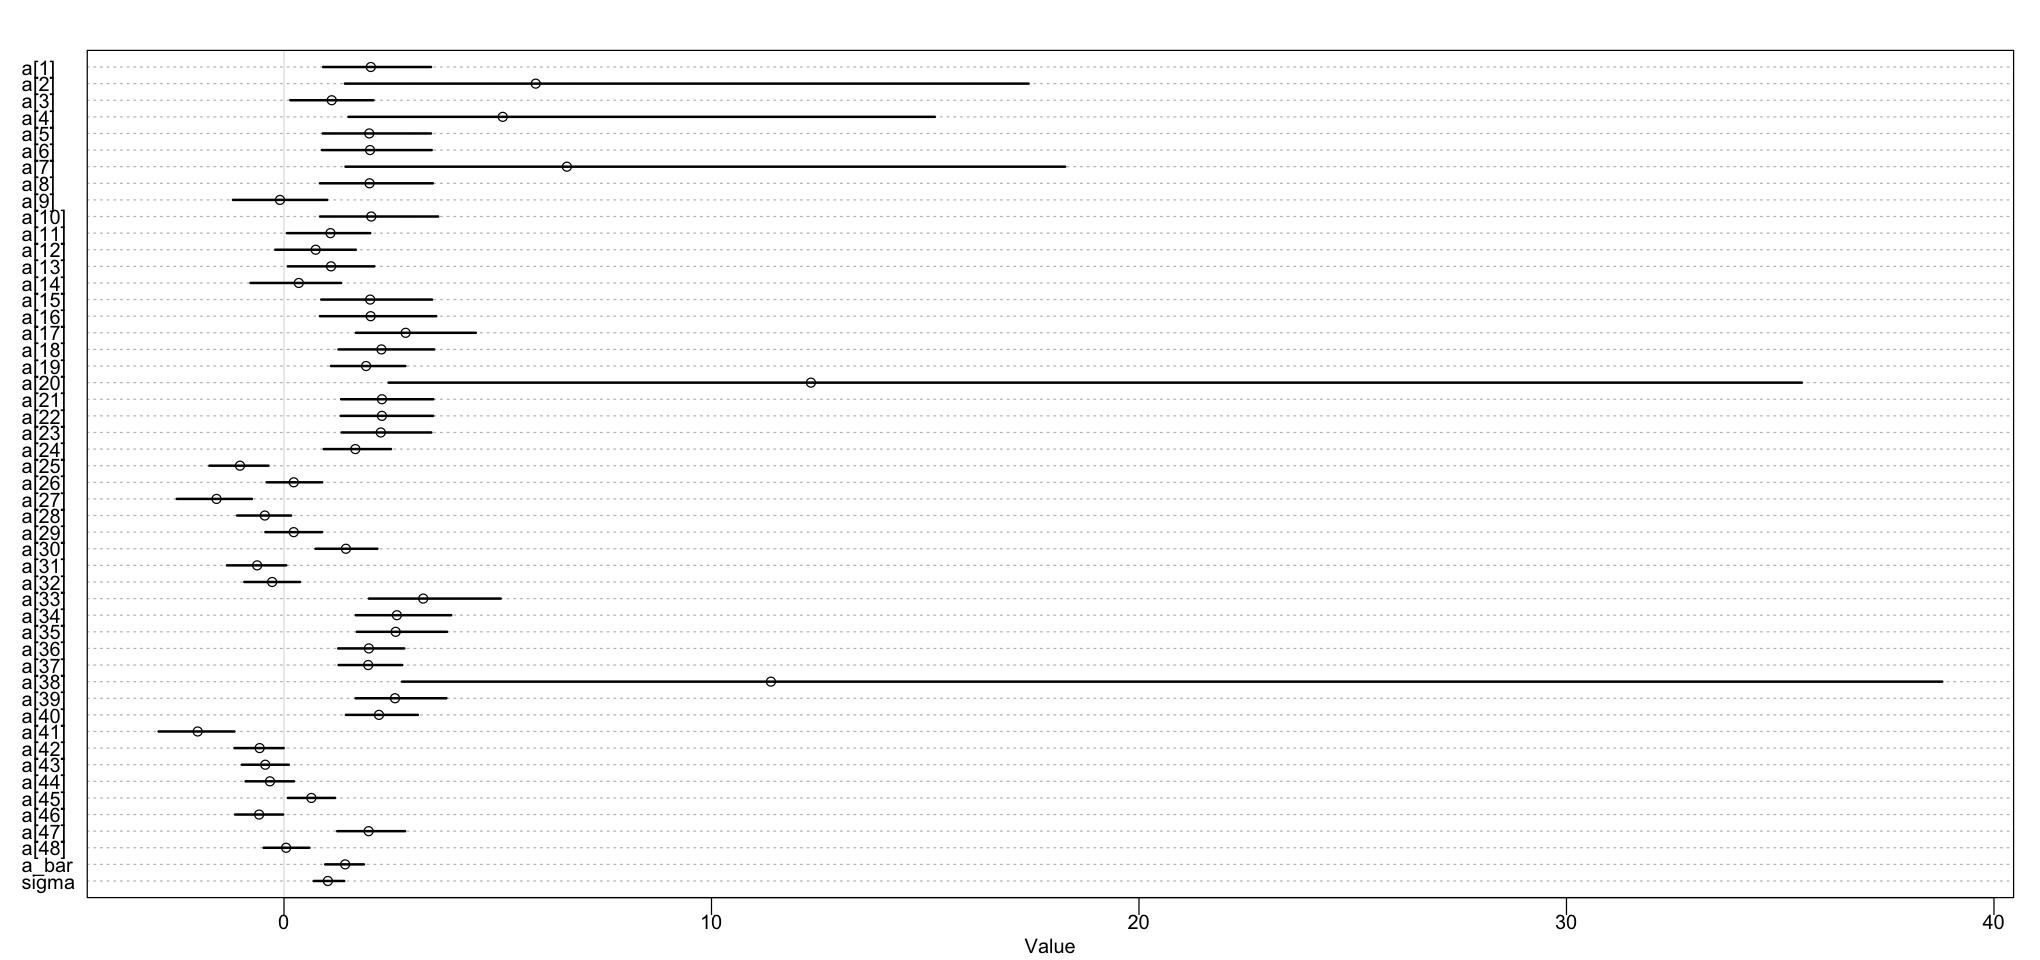

In [ ]:
par(bg = 'white')
plot(precis(m13m1.1.cauchy.1, depth = 2))

Wow, that's a lot of divergent transitions! Probably this is happening because the Cauchy distribution has very wide tails, which means that the parameters are free to wander all over the potential space. The first thing we can try is to change the `adapt_delta` parameter:

In [ ]:
m13m1.1.cauchy.2 <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank],
        a[tank] ~ dcauchy(a_bar, sigma),
        a_bar ~ dnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE,
    control = list(adapt_delta = 0.99)
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.4 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

See https://mc-stan.org/misc/warnings for details.




Hmm, well, that didn't appear to have helped. Looks like we'll have to try something different! Let's see if centring the model helps.

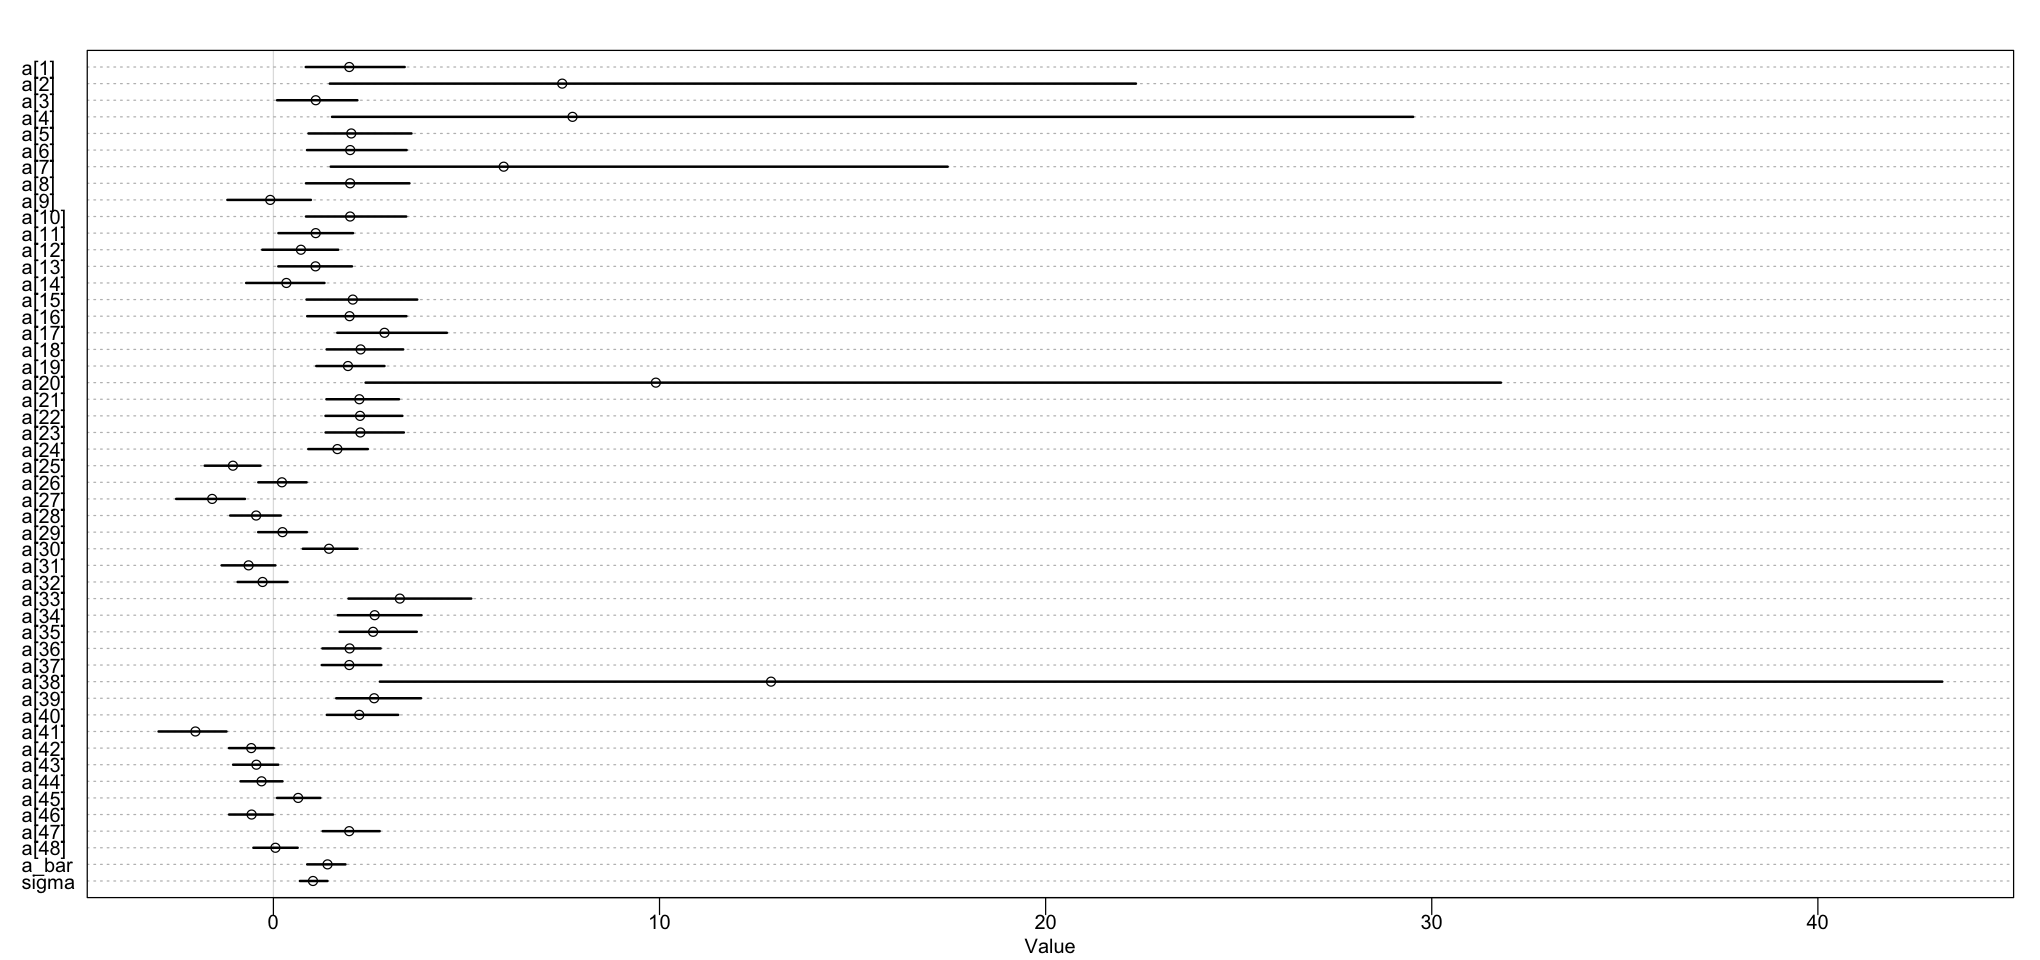

In [ ]:
par(bg = 'white')
plot(precis(m13m1.1.cauchy.2, depth = 2))

In [ ]:
m13m1.1.cauchy.3 <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a_bar + sigma * z[tank],
        # a[tank] ~ dcauchy(a_bar, sigma),
        # a[tank] <- a_bar + sigma * z[tank],
        z[tank] ~ dcauchy(0, 1),
        a_bar ~ dnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE,
    # control = list(adapt_delta = 0.99)
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.5 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

See https://mc-stan.org/misc/warnings for details.




So centring the model definitely worked!

In [ ]:
base_model_samples <- extract.samples(m13m1.1)
centred_cauchy_samples <- extract.samples(m13m1.1.cauchy.3)

In [ ]:
# NB we don't have an a[tank] parameter in the cauchy model, so we have to recreate it. The variable a[tank] would be logit(p), so that's what we'll do from the samples
cauchy_a_tank <- logit(centred_cauchy_samples$p)
head(cauchy_a_tank)

[,1]      [,2]     [,3]      [,4]     [,5]      [,6]     [,7]    
[1,] 1.4066056 2.458186 0.8764016      Inf 3.2268151 1.268968 1.571561
[2,] 2.0727775 2.511556 1.2679989      Inf 0.6063906 1.873060 4.290573
[3,] 1.3355307 2.391737 0.6285958 10.92512 3.1082068 1.696171 2.359901
[4,] 1.3246783 1.919243 0.4364256 13.12236 1.1812807 1.582378 1.678109
[5,] 1.1318763 2.131613 1.7582871 12.42921 1.4232154 1.651051 2.357266
[6,] 0.9496212 4.768450 1.8790416 11.41760 1.6374011 1.302962 2.600908
     [,8]      [,9]       [,10]     [,11] [,12]    [,13]    [,14]    
[1,] 0.8834904  0.4681593 0.8121948 ⋯     2.762528 1.892383 -1.730036
[2,] 2.3988950 -0.9724170 2.1820283 ⋯     2.150056 1.831901 -2.027906
[3,] 1.0594425  0.4820295 1.4652019 ⋯     2.623741 3.130563 -2.408541
[4,] 2.0738859  0.1497472 2.3052147 ⋯     1.937298 2.949228 -1.699742
[5,] 2.6210327 -0.8336256 1.5030572 ⋯     2.817308 2.516103 -2.505457
[6,] 1.6895198 -0.2137704 0.9727636 ⋯     2.721475 2.767804 -2.311445
     [,15]       [,16]       [,17]      [,18]       [,19]      [,20]    
[1,] -0.64013953 -1.23210622 -0.4764193 0.074446364 -0.7768416 1.8328930
[2,] -0.49260962  0.27643092 -0.1609747 1.389841886 -0.4604841 1.6648127
[3,] -1.24798004 -0.81506136 -0.6997259 0.004584008 -0.2528872 2.2798807
[4,] -0.04210222 -0.05707549  0.5146120 1.186792976 -0.8367439 1.5729799
[5,] -0.45573115 -0.40864946 -0.6518889 0.276137389 -0.1249182 1.3351850
[6,] -0.20112323 -0.07801555 -0.3091223 0.281239183 -0.8319827 0.9338958
     [,21]      
[1,]  0.42972082
[2,] -0.53784084
[3,]  0.31440867
[4,]  0.06392576
[5,]  0.21483044
[6,]  0.33249367

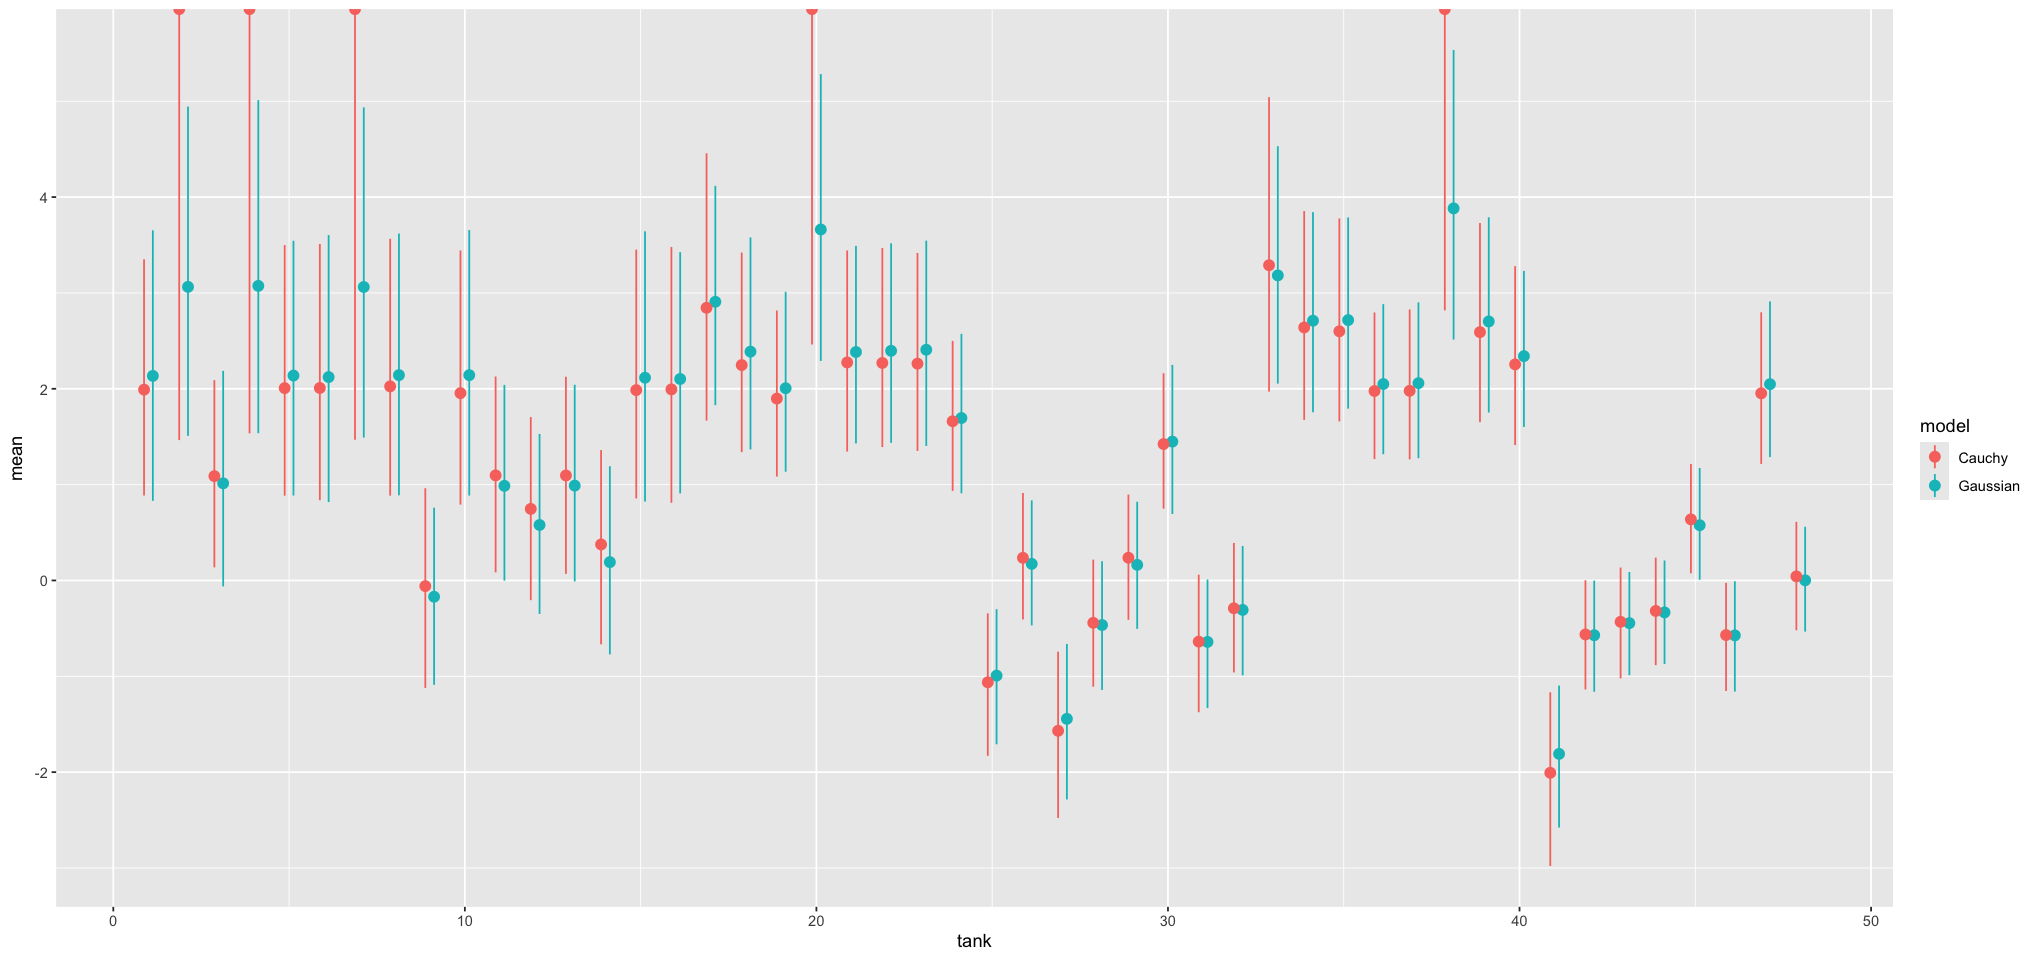

In [ ]:
base_means <- apply(base_model_samples$a, 2, mean)
base_ci <- apply(base_model_samples$a, 2, PI)
cauchy_means <- apply(cauchy_a_tank, 2, mean)
cauchy_ci <- apply(cauchy_a_tank, 2, PI)

plot_df <- data.frame(
    tank = rep(d$tank, 2),
    mean = c(base_means, cauchy_means),
    lower = c(base_ci[1, ], cauchy_ci[1, ]),
    upper = c(base_ci[2, ], cauchy_ci[2, ]),
    model = c(rep("Gaussian", length(d$tank)), rep("Cauchy", length(d$tank)))
)
ggplot(plot_df, aes(tank, group = model, colour = model)) +
    geom_pointrange(aes(y = mean, ymin = lower, ymax = upper), position = position_dodge(width = 0.5))

These look basically the same, except that when the value for `a[tank]` is large in the Gaussian model it tends to be even larger in the Cauchy one. Let's plot these against each other to see if that makes the relationship clearer.

Now let's take a look at $\bar\alpha$!

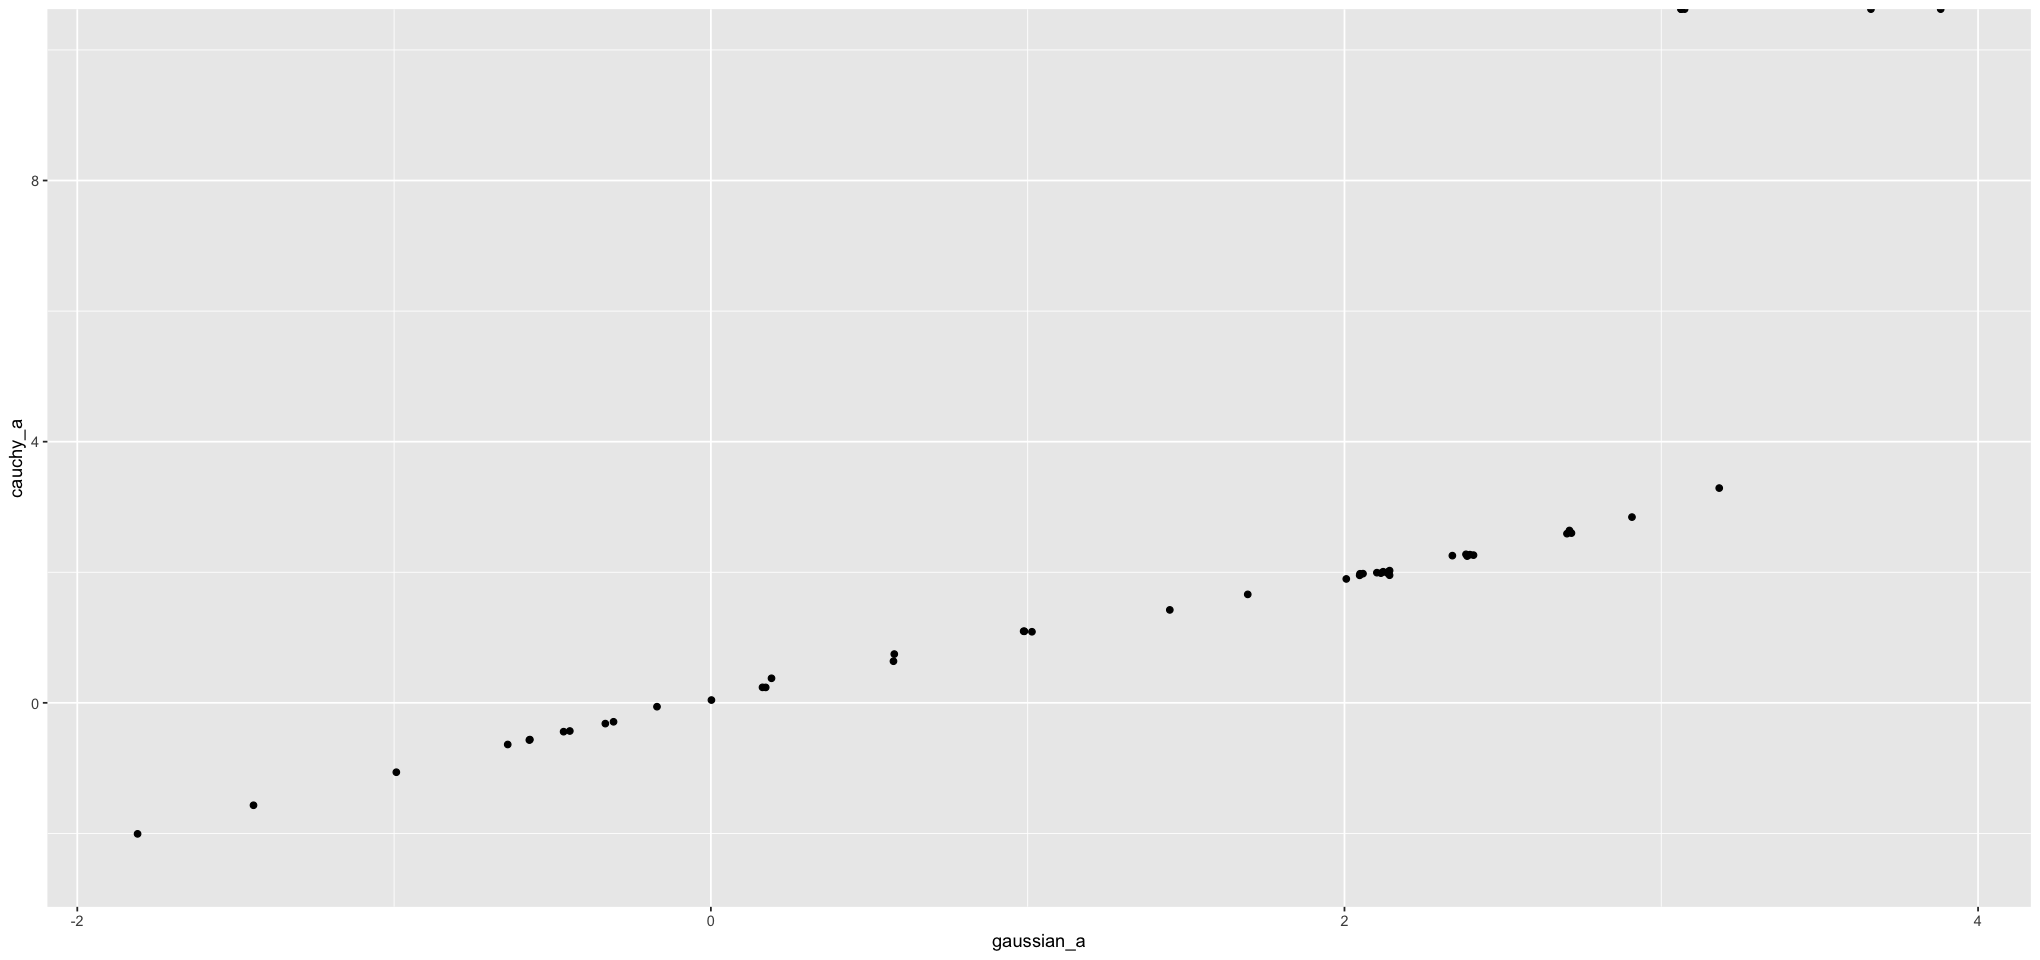

In [ ]:
plot_df <- data.frame(
    gaussian_a = base_means,
    cauchy_a = cauchy_means,
    tank = d$tank
)
ggplot(plot_df, aes(gaussian_a, cauchy_a)) +
    geom_point() +
    coord_cartesian(ylim = c(-2.5, 10))

Now we're running into a problem - some of the Cauchy values are infinity!

In [ ]:
cauchy_means

[1]  1.99097607         Inf  1.08846304         Inf  2.00674867  2.00807849
 [7]         Inf  2.02505695 -0.05916424  1.95440720  1.09641849  0.74665080
[13]  1.09571549  0.37587166  1.98621139  1.99366912  2.84477473  2.24731053
[19]  1.89766222         Inf  2.27468866  2.26947568  2.26233016  1.66097268
[25] -1.06268158  0.23622881 -1.56893246 -0.44186499  0.23695575  1.42329918
[31] -0.63812095 -0.29033170  3.28918249  2.63984124  2.59960047  1.97672851
[37]  1.97845848         Inf  2.59102742  2.25448643 -2.00686521 -0.56313342
[43] -0.43157044 -0.31829299  0.63739013 -0.56994388  1.95278844  0.04247024

Probably what is happening here is that the hierarchical priors are 'shrinking' the Gaussian models more toward the mean (since the extreme `a[tank]` values are ones where a high proportion of the tadpoles survived), leading to very large (infinite) values in the Cauchy model.

Now let's compare the posterior means of the intercepts ($\alpha_{\text{TANK}}$)

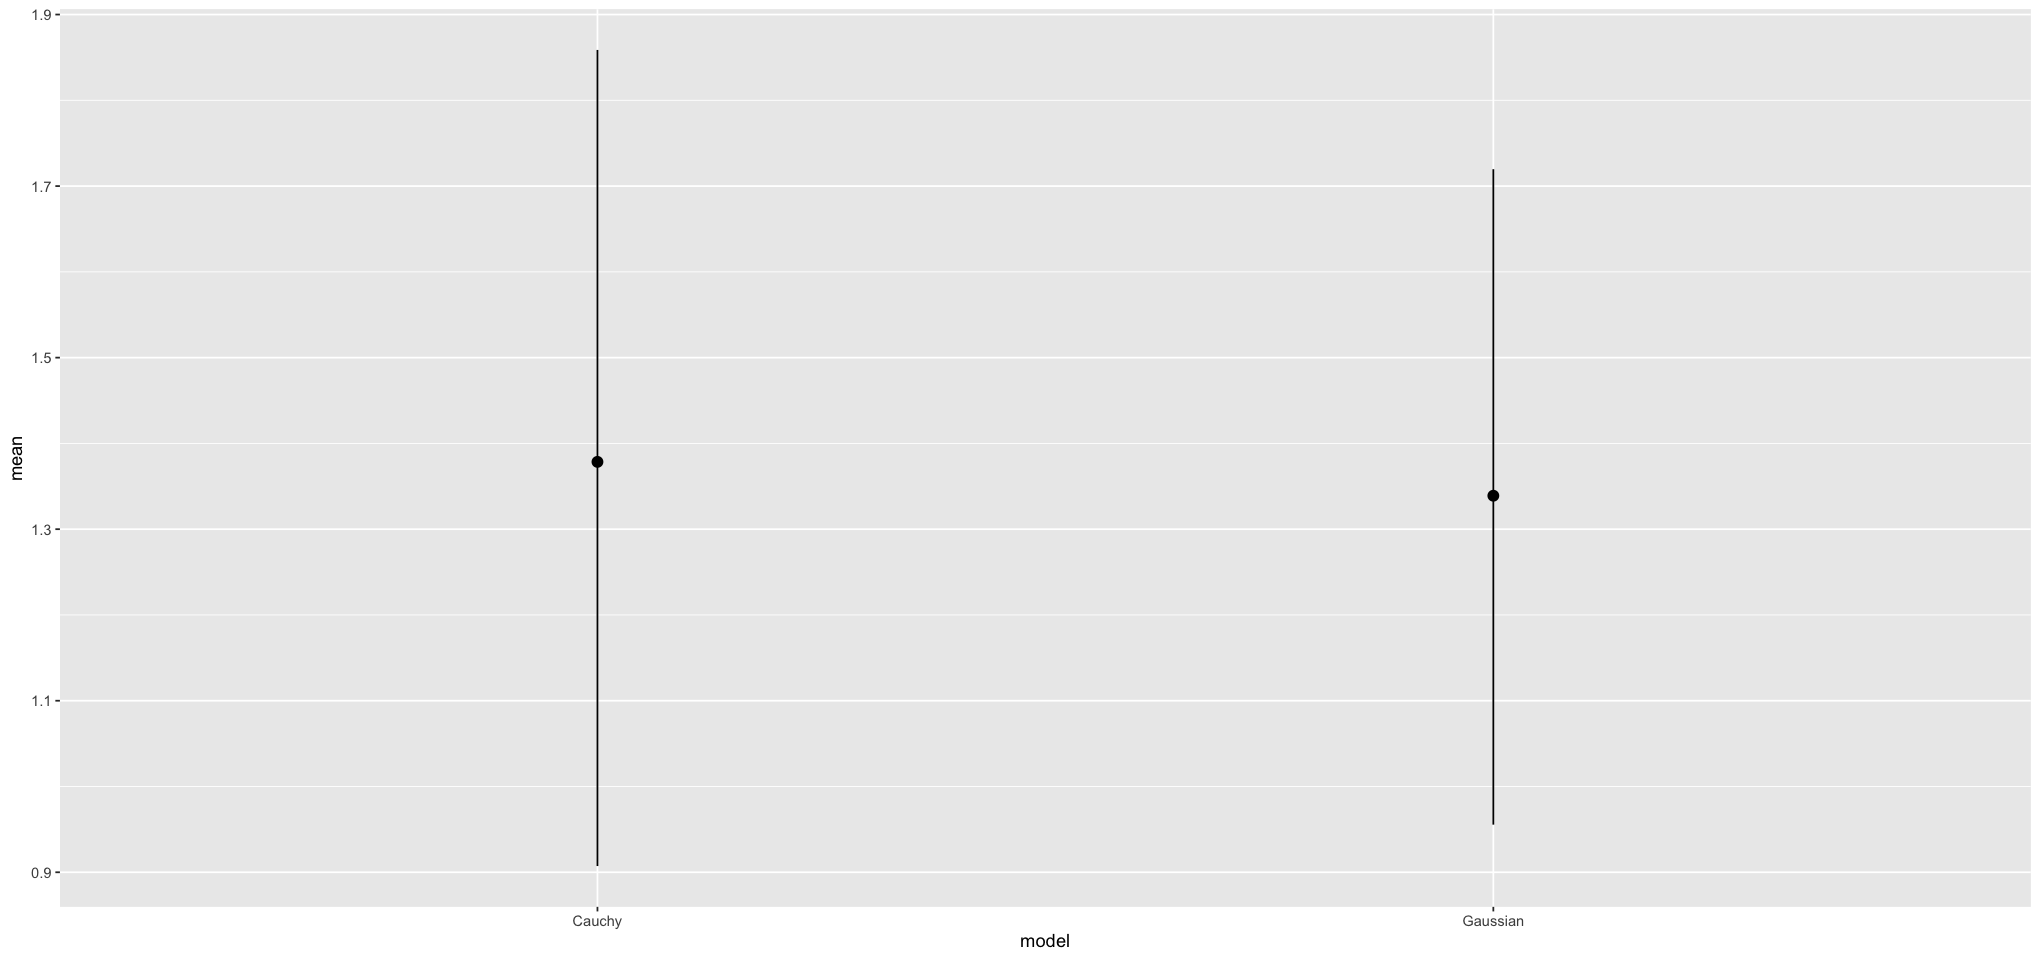

In [ ]:
plot_df <- data.frame(
    mean = c(mean(base_model_samples$a_bar), mean(centred_cauchy_samples$a_bar)),
    lower = c(PI(base_model_samples$a_bar)[1], PI(centred_cauchy_samples$a_bar)[1]),
    upper = c(PI(base_model_samples$a_bar)[2], PI(centred_cauchy_samples$a_bar)[2]),
    model = c("Gaussian", "Cauchy")
)
ggplot(plot_df, aes(model)) +
    geom_pointrange(aes(y = mean, ymin = lower, ymax = upper))

These look basically identical! So it looks like the model only affected the `a[tank]` values.

**13M4** Now use the Student-t distribution with $\nu = 2$ for the intercepts:

$$
\alpha_{\text{TANK}} \sim \text{Student}(2, \alpha, \sigma)
$$

Compare the resulting posterior to both the original model and the Cauchy model in **13M3**. Can you explain the differences and similarities in shinkage in terms of the properties of these distributions?

**Answer**

In [ ]:
m13m3.student <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank],
        a[tank] ~ dstudent(2, a_bar, sigma),
        a_bar ~ dnorm(0, 1),
        sigma ~ dexp(1)
    ),
    data = dat,
    chains = 4,
    log_lik = TRUE,
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: student_t_lpdf: Scale parameter is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fe7c46057d.stan', line 18, column 4 to column 39)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.2 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: student_t_lpdf: Scale parameter is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fe7c46057d.stan', line 18, column 4 to column 39)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.2 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: student_t_lpdf: Scale parameter is 0, but must be positive finite! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/Rtmpul3JD0/model-7fe7c46057d.stan', line 18, column 4 to column 39)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 0.2 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.2 secon

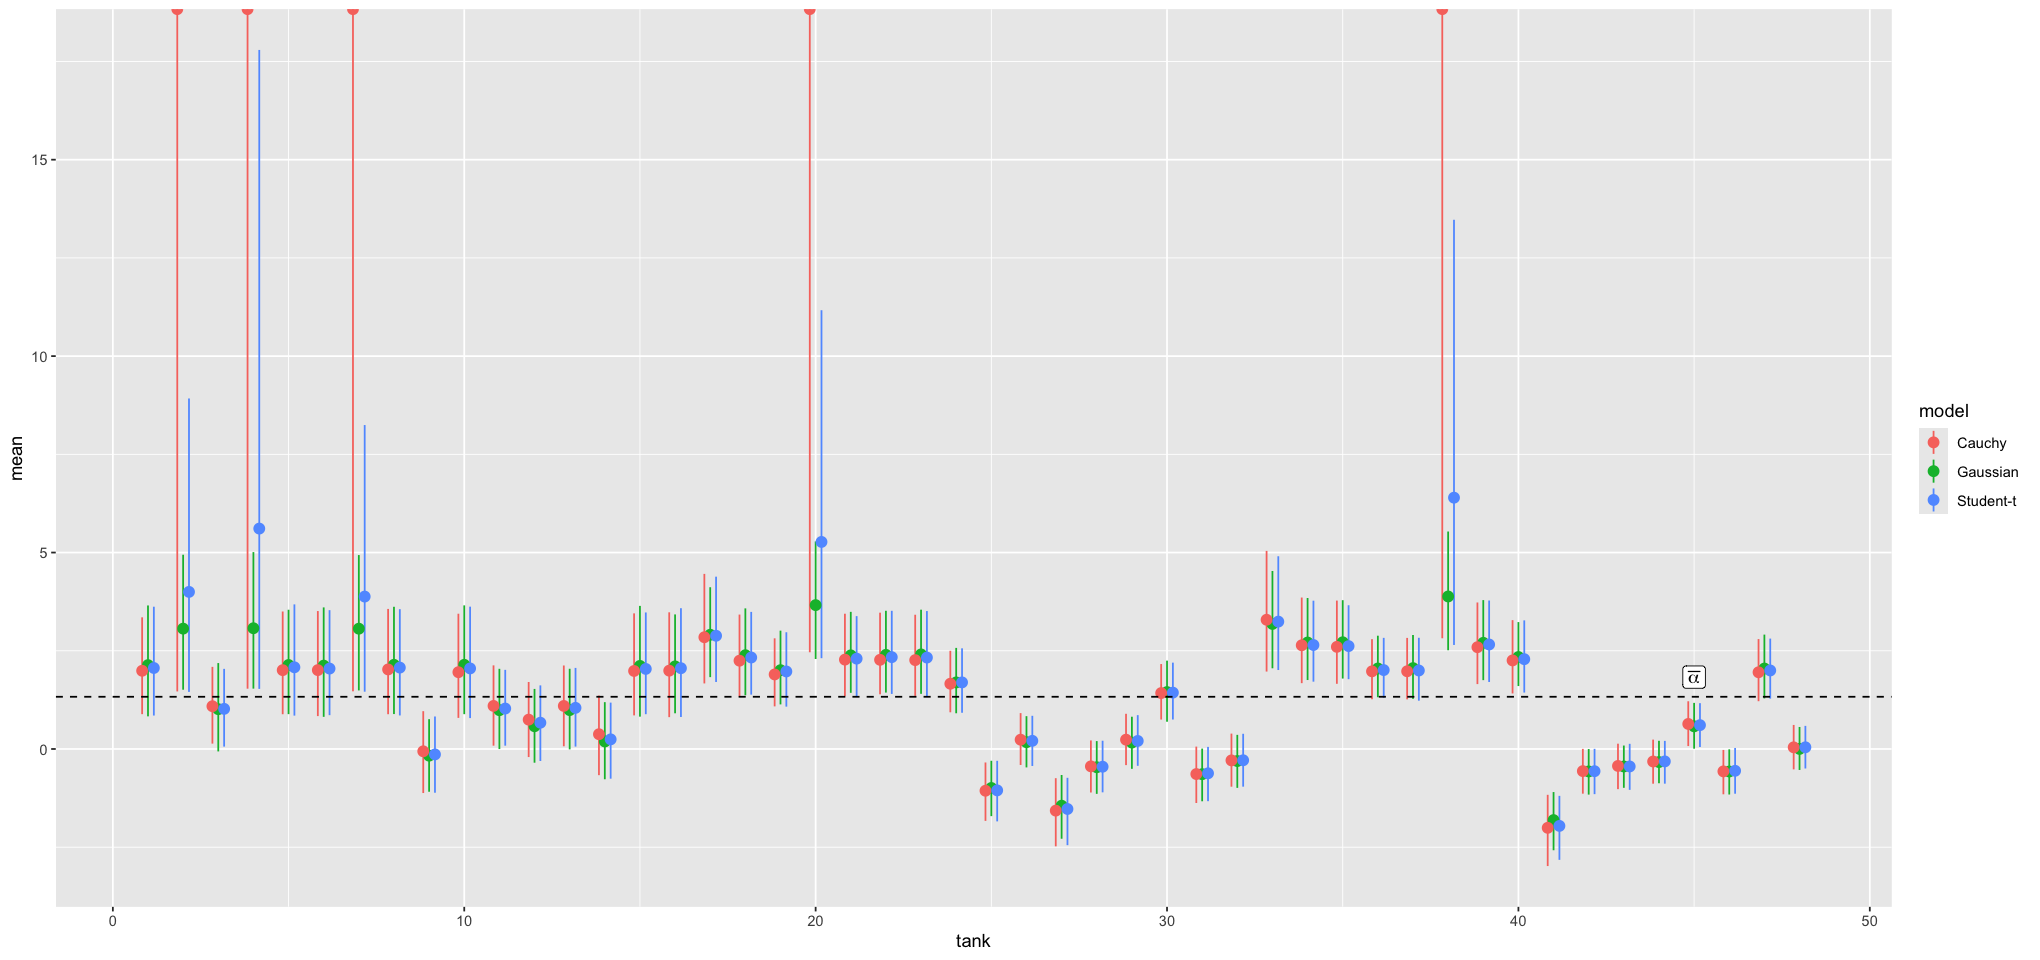

In [ ]:
# campare the a_tank between the different models

student_model_samples <- extract.samples(m13m3.student)

base_means <- apply(base_model_samples$a, 2, mean)
base_ci <- apply(base_model_samples$a, 2, PI)
cauchy_means <- apply(cauchy_a_tank, 2, mean)
cauchy_ci <- apply(cauchy_a_tank, 2, PI)
student_means <- apply(student_model_samples$a, 2, mean)
student_ci <- apply(student_model_samples$a, 2, PI)

student_a_bar <- apply(student_model_samples$a_bar, 2, mean)

plot_df <- data.frame(
    tank = rep(d$tank, 3),
    mean = c(base_means, cauchy_means, student_means),
    lower = c(base_ci[1, ], cauchy_ci[1, ], student_ci[1, ]),
    upper = c(base_ci[2, ], cauchy_ci[2, ], student_ci[2, ]),
    model = rep(c("Gaussian", "Cauchy", "Student-t"), each = length(d$tank))
)
ggplot(plot_df, aes(tank, group = model, colour = model)) +
    geom_pointrange(aes(y = mean, ymin = lower, ymax = upper), position = position_dodge(width = 0.5)) +
    geom_hline(aes(yintercept = student_a_bar), linetype = 'dashed') +
    annotate('label', x = 45, y = student_a_bar + 0.5, label = "bar(alpha)", parse = TRUE)

From the graph, the Student-t distribution experienced an amount of shrinkage intermediate between the Gaussian and the Cauchy. One thing to note is that the colours have changed compared to the earlier graph.

This is as expected. A more concentrated prior will tend to produce more shrinkage toward the mean. Of the three distributions, the Gaussian is the most concentrated, followed by the Student-t and then the Cauchy distribution. This fact explains the different levels of shrinkage.

One thing to note: Normal = $\text{Student-t}(\nu = \infty)$, and Cauchy = $\text{Student-t}(\nu = 1)$, so it makes sense to use a Student-t and then muck about with the number of degrees of freedom to achieve the level of shrinkage that you're looking for.

**13M5** Modify the cross-classified chimpanzee model `m13.4` so that the adaptive prior for blocks contains a parameter $\bar\gamma$ for its mean:

$$
\begin{align*}
\gamma_j &\sim \text{Normal}(\bar\gamma, \sigma_\gamma) \\
\bar\gamma &\sim \text{Normal}(0, 1.5)
\end{align*}
$$

Compare this model to `m13.4`. What has including $\bar\gamma$ done?

**Answer**

Original model:
$$
\begin{align*}
L_i &\sim \text{Binomial}(1, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{ACTOR}[i]} + \gamma_{\text{BLOCK}[i]} + \beta_{\text{TREATMENT}[i]} \\
\beta_j &\sim \text{Normal}(0, 0.5) & \text{for $j = 1\dots 4$} \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) & \text{for $j = 1\dots 7$} \\
\gamma_j &\sim \text{Normal}(0, \sigma_{\gamma}) & \text{for $j = 1\dots 6$} \\
\bar{\alpha} &\sim \text{Normal(0, 1.5)} \\
\sigma_\alpha &\sim \text{Exponential(1)} \\
\sigma_\gamma &\sim \text{Exponential(1)} \\
\end{align*}
$$

New model:
$$
\begin{align*}
L_i &\sim \text{Binomial}(1, p_i) \\
\text{logit}(p_i) &= \alpha_{\text{ACTOR}[i]} + \gamma_{\text{BLOCK}[i]} + \beta_{\text{TREATMENT}[i]} \\
\beta_j &\sim \text{Normal}(0, 0.5) & \text{for $j = 1\dots 4$} \\
\alpha_j &\sim \text{Normal}(\bar{\alpha}, \sigma_{\alpha}) & \text{for $j = 1\dots 7$} \\
\gamma_j &\sim \text{Normal}(\bar\gamma, \sigma_{\gamma}) & \text{for $j = 1\dots 6$} \\
\bar{\alpha} &\sim \text{Normal(0, 1.5)} \\
\bar{\gamma} &\sim \text{Normal}(0, 1.5) \\
\sigma_\alpha &\sim \text{Exponential(1)} \\
\sigma_\gamma &\sim \text{Exponential(1)} \\
\end{align*}
$$

In [ ]:
data(chimpanzees)
d <- chimpanzees
d$treatment <- 1 + d$prosoc_left + 2 * d$condition

dat_list <- list(
    pulled_left = d$pulled_left,
    actor = d$actor,
    block_id = d$block,
    treatment = as.integer(d$treatment)
)

set.seed(13)
m13m5 <- ulam(
    alist(
        pulled_left ~ dbinom(1, p),
        logit(p) <- a[actor] + g[block_id] + b[treatment],
        b[treatment] ~ dnorm(0, 0.5),
        # adaptive priors
        a[actor] ~ dnorm(a_bar, sigma_a),
        g[block_id] ~ dnorm(sigma_bar, sigma_g),
        # hyper priors
        a_bar ~ dnorm(0, 1.5),
        sigma_bar ~ dnorm(0, 1.5),
        sigma_a ~ dexp(1),
        sigma_g ~ dexp(1)
    ),
    data = dat_list,
    chains = 4,
    cores = 4,
    log_lik = TRUE,
    control = list(adapt_delta = 0.99)
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration:

See https://mc-stan.org/misc/warnings for details.


See https://mc-stan.org/misc/warnings for details.




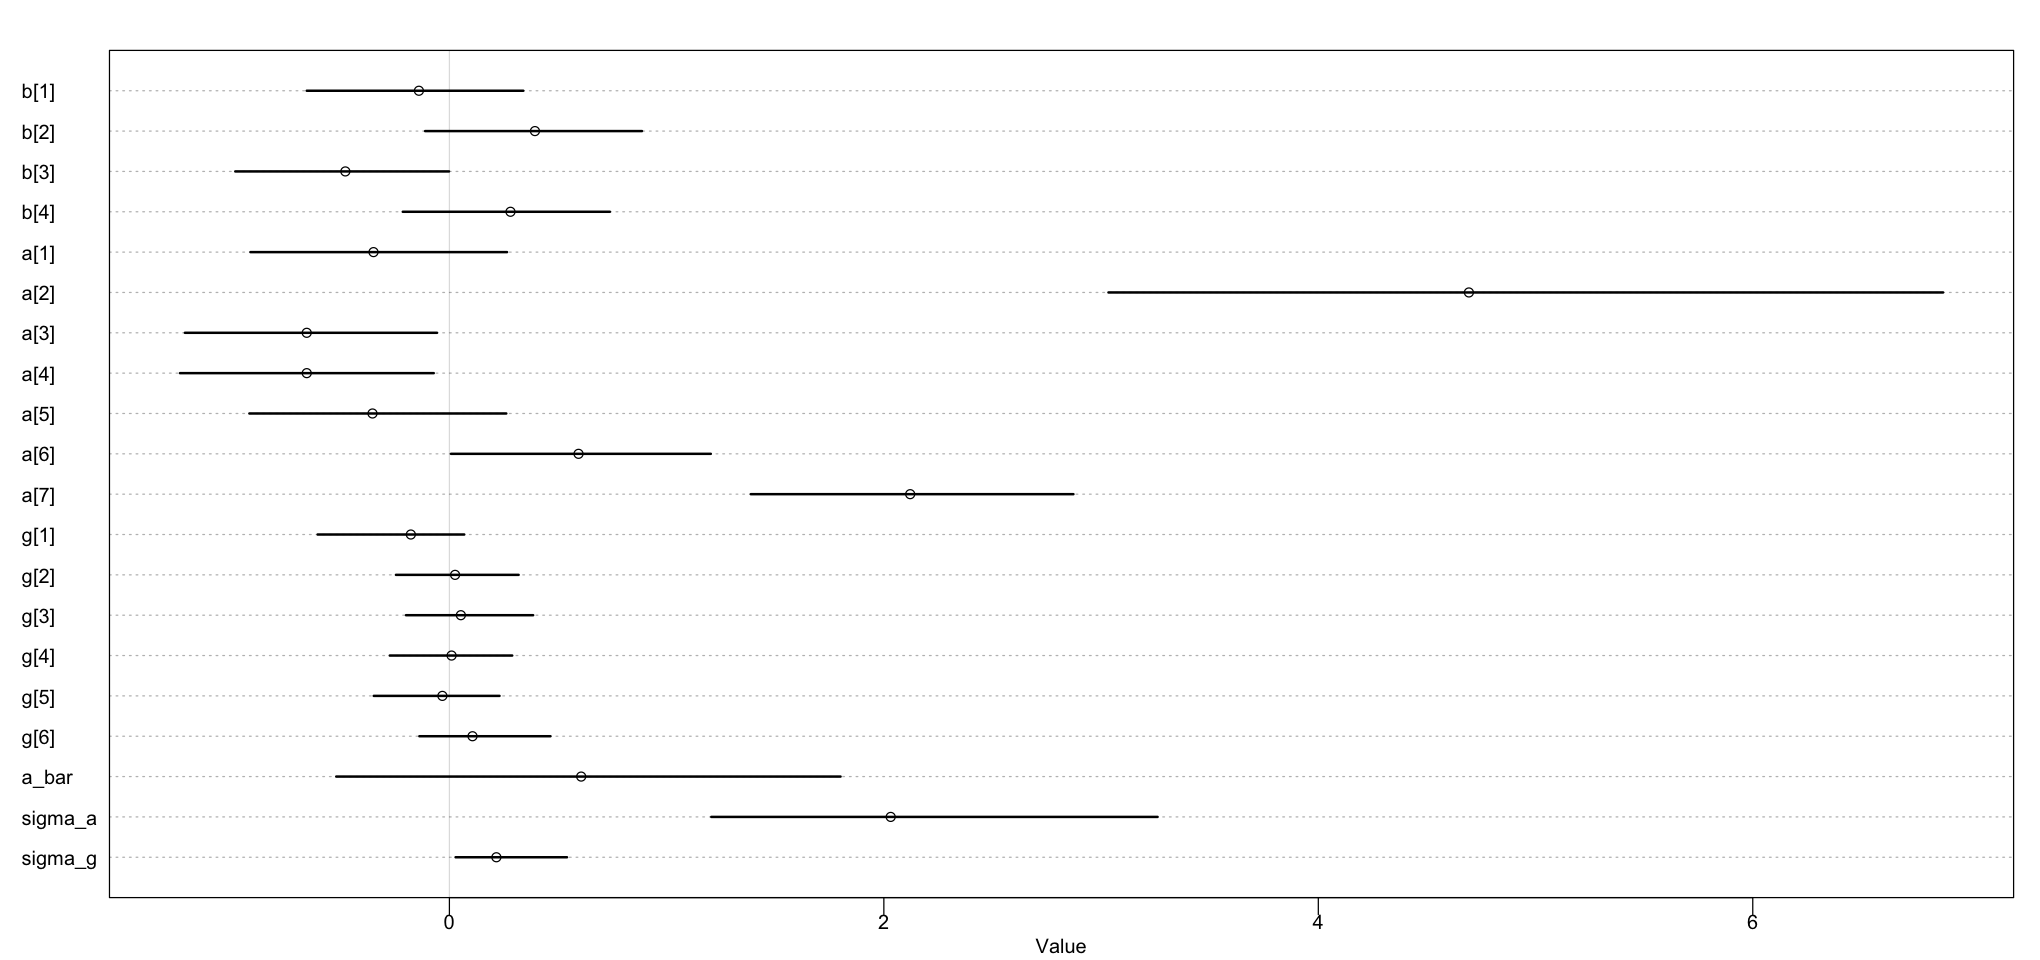

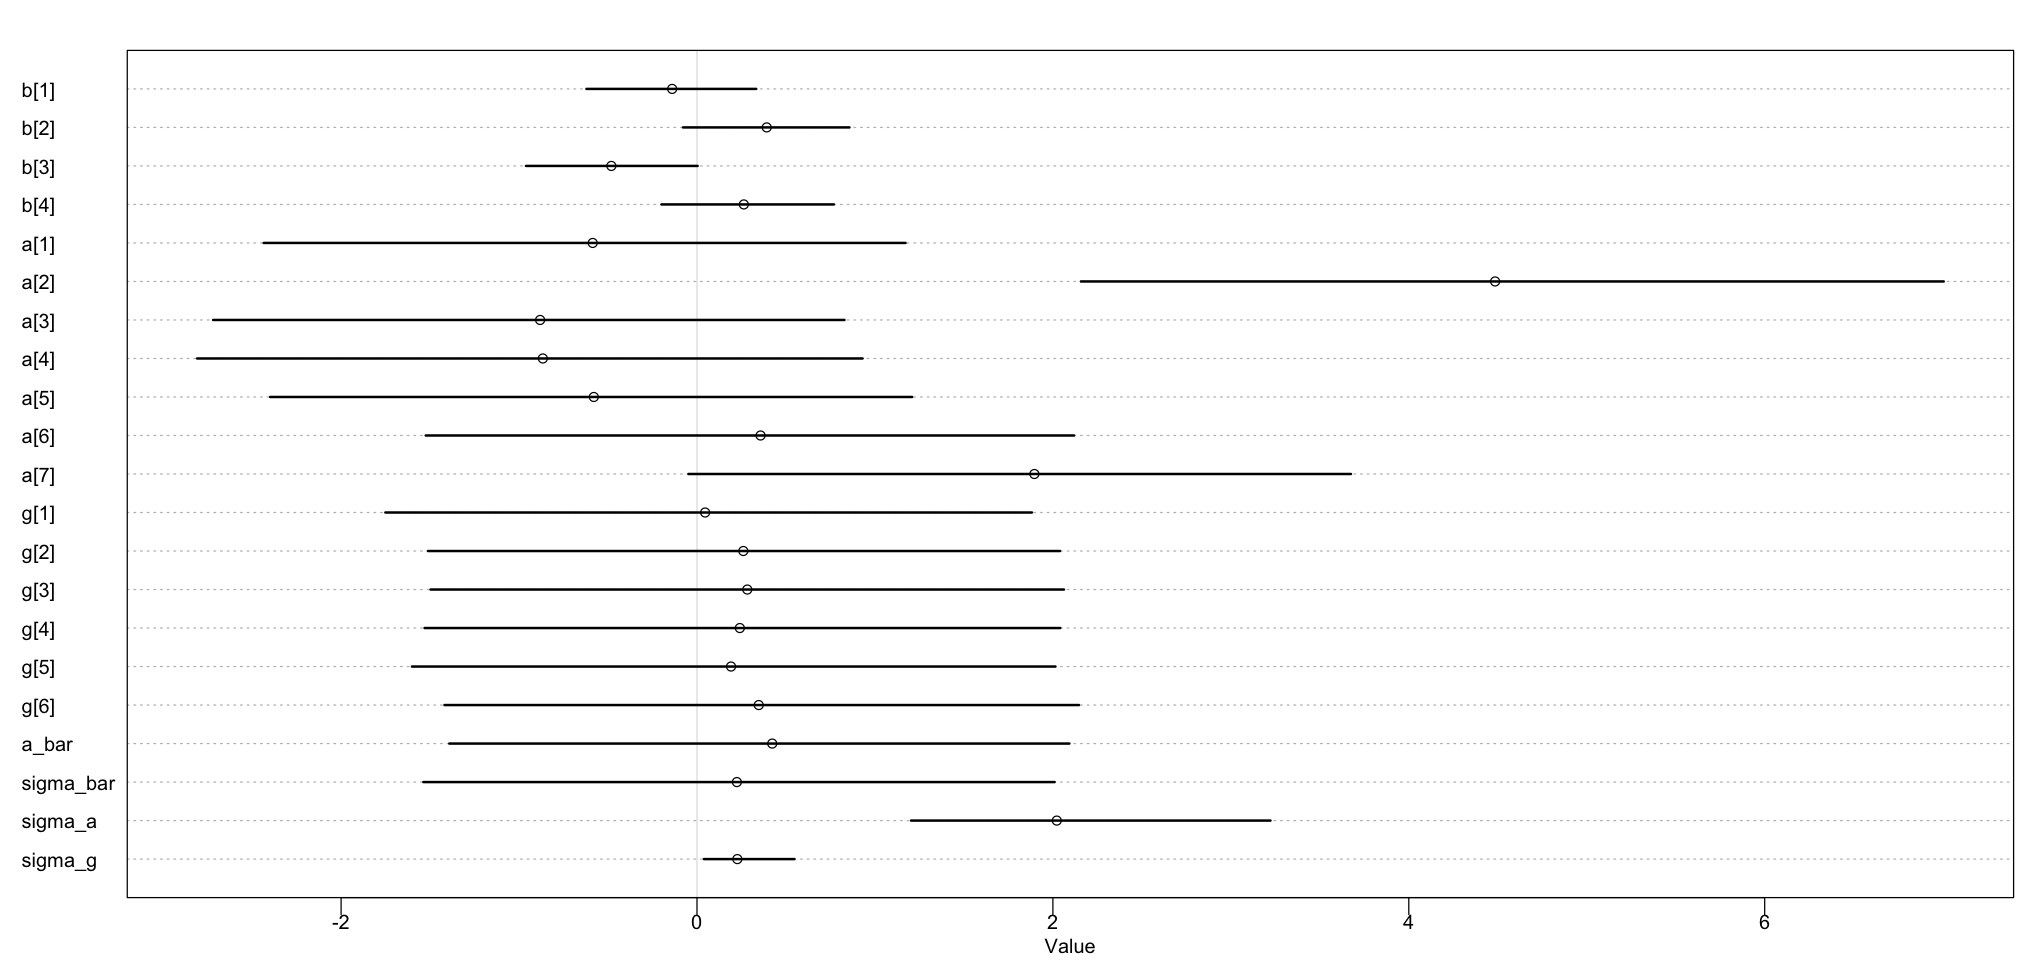

In [ ]:
par(bg = 'white')
plot(precis(m13.4, depth = 2))
plot(precis(m13m5, depth = 2))

In [ ]:
compare(m13.4, m13m5)

WAIC     SE       dWAIC    dSE      pWAIC    weight   
m13.4 532.0367 19.39689 0.000000       NA 10.59352 0.5965073
m13m5 532.8186 19.38993 0.781866 0.273291 11.02560 0.4034927

So this didn't really help! All of the parameters of the second model (with the other adaptive prior). My suspicion is that we're running into the same problem that we did earlier with multicollinearity (although that's probably the wrong term). Basically, we have two adative priors with two different means; when we add them together, there are lots of different values for each of the means that result in the same sum. As a result, the level of confidence in each one goes down (wider variance).

This seems like a model specification issue - it's probably not a good idea to have multiple adaptive priors in the same sum!

**13M6** Sometimes prior and data (through the likelihood) are in conflict because they concentrate around different regions of the parameter space. What happens in these cases depends a lot upon the shape of the tails of the disitrubion. Likewisde, the tails of distributions strongly influence how outliers are shrunk or not towards the mean. Consider four different models to fit to one observation at $y = 0$. The models differ only in the distributions assigned to the likelihood and prior.

Model NN:
$$
\begin{align*}
y &\sim \text{Normal}(\mu, 1) \\
\mu &\sim \text{Normal}(10, 1) \\
\end{align*}
$$

Model TN:
$$
\begin{align*}
y &\sim \text{Student}(2, \mu, 1) \\
\mu &\sim \text{Normal}(10, 1) \\
\end{align*}
$$

Model NT:
$$
\begin{align*}
y &\sim \text{Normal}(\mu, 1) \\
\mu &\sim \text{Student}(2, 10, 1) \\
\end{align*}
$$

Model TT:
$$
\begin{align*}
y &\sim \text{Student}(2, \mu, 1) \\
\mu &\sim \text{Student}(2, 10, 1) \\
\end{align*}
$$

Estimate the posterior distributions for these models and compare them. Can you explain the results using the properties of the distributions?

**Answer**

In [ ]:
data <- list(y = array(0, dim = 1))
m13m6.nn <- ulam(
    alist(
        y ~ dnorm(mu, 1),
        mu ~ dnorm(10, 1)
    ),
    data = data
    # log_lik = TRUE # this causes a failure with a warning about the dimensions - looks like it's treating the input as a real when it should be a vector
)
m13m6.tn <- ulam(
    alist(
        y ~ dstudent(2, mu, 1),
        mu ~ dnorm(10, 1)
    ),
    data = data
    # log_lik = TRUE # this causes a failure with a warning about the dimensions - looks like it's treating the input as a real when it should be a vector
)
m13m6.nt <- ulam(
    alist(
        y ~ dnorm(mu, 1),
        mu ~ dstudent(2, 10, 1)
    ),
    data = data
    # log_lik = TRUE # this causes a failure with a warning about the dimensions - looks like it's treating the input as a real when it should be a vector
)
m13m6.tt <- ulam(
    alist(
        y ~ dstudent(2, mu, 1),
        mu ~ dstudent(2, 10, 1)
    ),
    data = data
    # log_lik = TRUE # this causes a failure with a warning about the dimensions - looks like it's treating the input as a real when it should be a vector
)

Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.0 seconds.
Running MCMC with 1 chain, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500

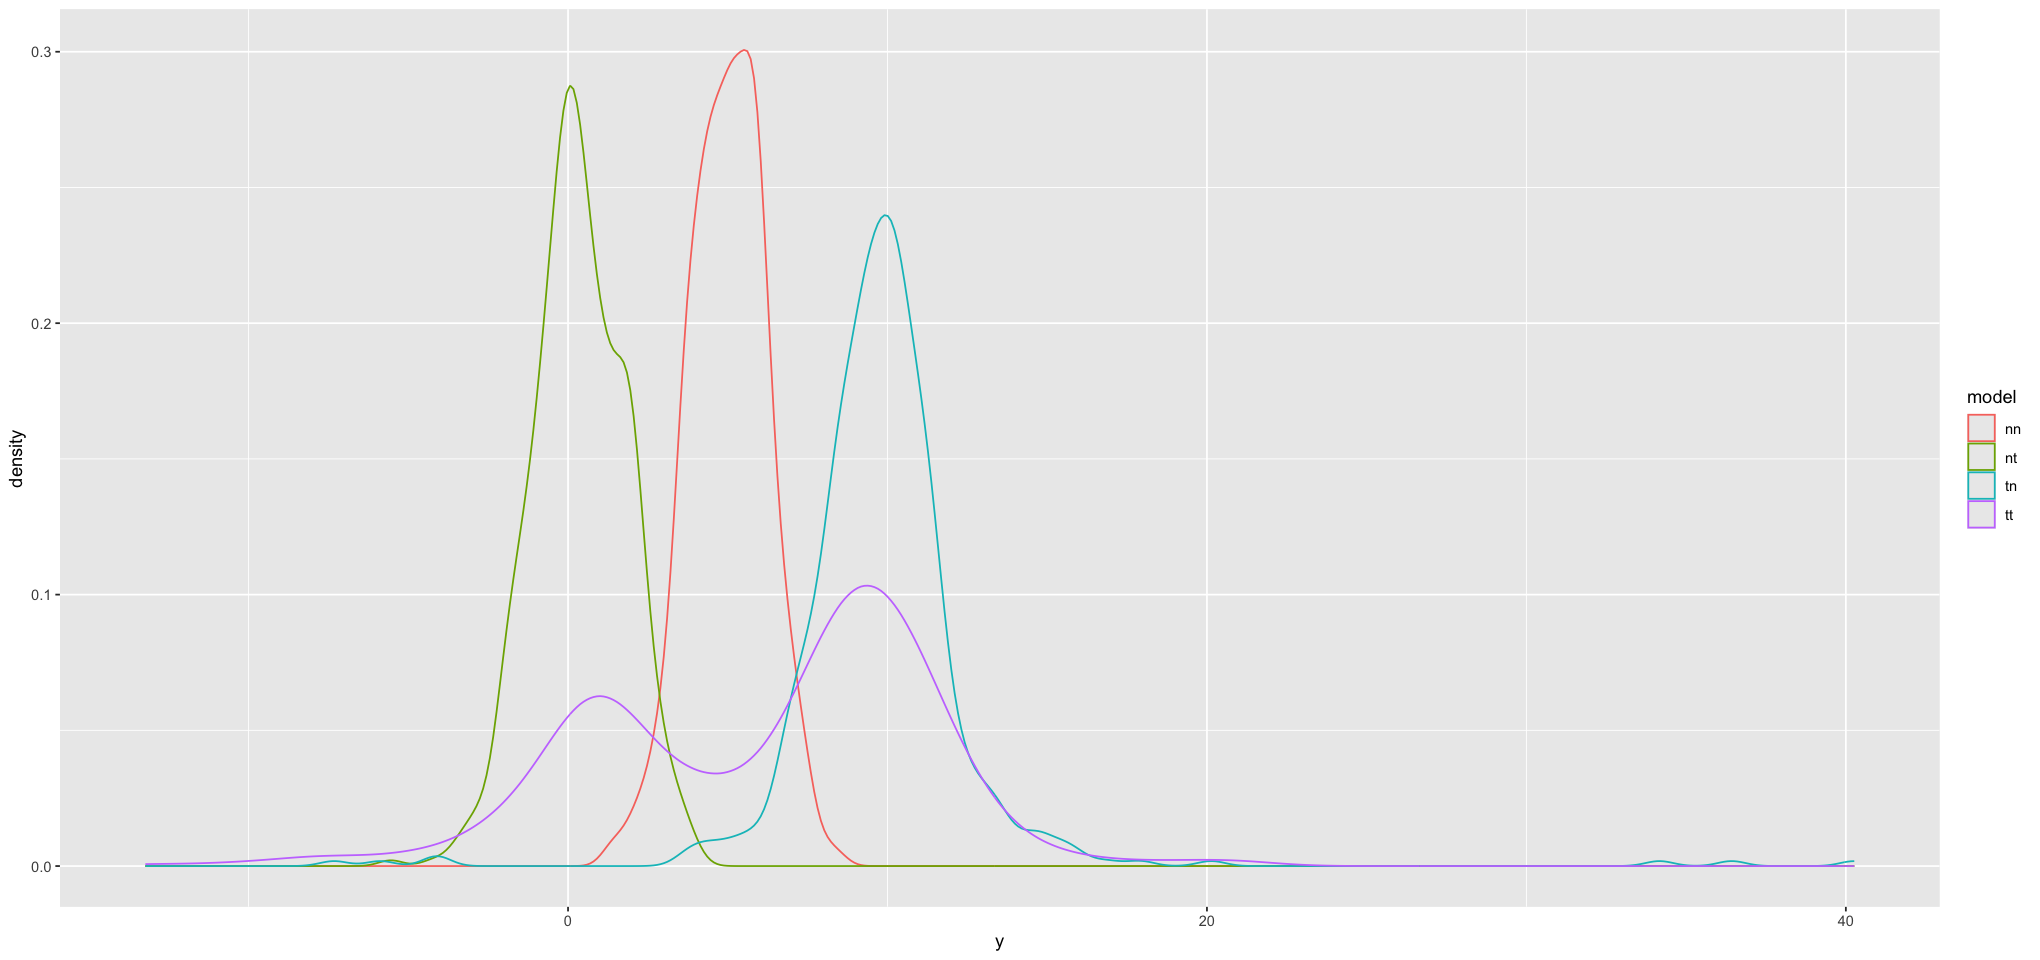

In [ ]:
nn.samples.mu <- extract.samples(m13m6.nn)$mu
nt.samples.mu <- extract.samples(m13m6.nt)$mu
tn.samples.mu <- extract.samples(m13m6.tn)$mu
tt.samples.mu <- extract.samples(m13m6.tt)$mu

nn.samples.y <- rnorm(length(nn.samples.mu), nn.samples.mu, 1)
nt.samples.y <- rnorm(length(nt.samples.mu), nt.samples.mu, 1)
tn.samples.y <- rstudent(length(tn.samples.mu), 2, tn.samples.mu, 1)
tt.samples.y <- rstudent(length(tt.samples.mu), 2, tt.samples.mu, 1)

plot_df <- rbind(
    data.frame(y = nn.samples.y, model = "nn"),
    data.frame(y = nt.samples.y, model = "nt"),
    data.frame(y = tn.samples.y, model = "tn"),
    data.frame(y = tt.samples.y, model = "tt")
)
ggplot(plot_df, aes(group = model, colour = model)) +
    geom_density(aes(y))

1. The NN model (normal likelihood, normal prior) looks approximately normal with a mean just around the halfway point of the data and the prior, as expected. This is the kind of behaviour that we're seen often.
2. The NT model shows almost all of the weight closer to the data than to the prior. This is due to the fact that the Student-t distribution has wider tails, and so is a 'less strong' distribution; the posterior is more influenced by the data than the prior.
3. The TN model is is converse of the NT one; here, the prior is stronger than the likelihood, and so most of the mass of the posterior remains aronud the prior rather than being influenced by the data.
4. The TT model is most puzzling! I would have naively expected to see results like in the first one (NN), but instead there's a bimodal distribution with peaks around the data ($y=0$) and the prior ($y=10$). Even more interestingly, depending on the run, which peak is the largest switches. I am honestly not sure what's going on here!

**13H1** In 1980, a typical Begali woman could have 5 or more chilnder in her lifetime. By 2000, that number had reduced to only 2 or 3. We're going to look at historical data for when contraception was available but many families chose not to use it. These data are in `data(bengladesh)` and come from the 1988 Bagladesh Fertility Survey. Each row is one of the 1934 women. There are siz variables, but we are just going to focus on two of them:
1. `district`: ID of the administrative district each woman resided in
2. `use.contraception`: an indicator (0 / 1) of whether the woman was using contraception

The first thing to do is to ensure that thecluster variable, `district`, is a contiguous set of integers. Recal that these values will be index values inside the mode. If there are gaps, we'll have parameters for wheich there is no data to inform them. Worse, the model probably won't run.

Let's look at the values:

In [ ]:
data(bangladesh)
d <- bangladesh
head(d)

woman district use.contraception living.children age.centered urban
1 1     1        0                 4                18.4400     1    
2 2     1        0                 1                -5.5599     1    
3 3     1        0                 3                 1.4400     1    
4 4     1        0                 4                 8.4400     1    
5 5     1        0                 1               -13.5590     1    
6 6     1        0                 1               -11.5600     1

In [ ]:
sort(unique(d$district))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 55 56 57 58 59 60 61

District 54 is absent, which means that district is not a good index variable. Luckily we can fix that:

In [ ]:
d$district_id <- as.integer(as.factor(d$district))
sort(unique(d$district_id))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60

So now we have a nice set of index variavles.

Focus on predicting `use.contraception` clustered by `district_id`. Fit both
1. A traditional fixed-effects model that uses an index variable for district, and 
2. A multilevel model with a varying intercept for district

Plot the predicted proportions of women in each district using contraception for both the fixed-effects and varying-effects models. That is, make a plot in which district ID is on the horizontal axis and expected proportion using contraception is on the vertical. Make one plot for each model, or layer them on the same plot. How do the models disagree? Can you explain the pattern of disagreement? In particular, can you explain the most extreme case of disagreement, both why they happen where they do and why the models reach different inferences?

**Answer** First, let's look at the data:

In [ ]:
plot_df <- aggregate(use.contraception ~ district_id, data = d, FUN = mean)
names(plot_df)[names(plot_df) == 'use.contraception'] <- 'prop'
# plot_df <- data.frame(
#     district_id = d$district_id,
#     prop = sapply(d$district_id, function(district_id) {
#         subset <- d[d$district_id == district_id, ]
#         sum(subset$use.contraception) / nrow(subset)
#     })
# )
head(plot_df)

district_id prop     
1 1           0.2564103
2 2           0.3500000
3 3           1.0000000
4 4           0.5000000
5 5           0.3589744
6 6           0.2923077

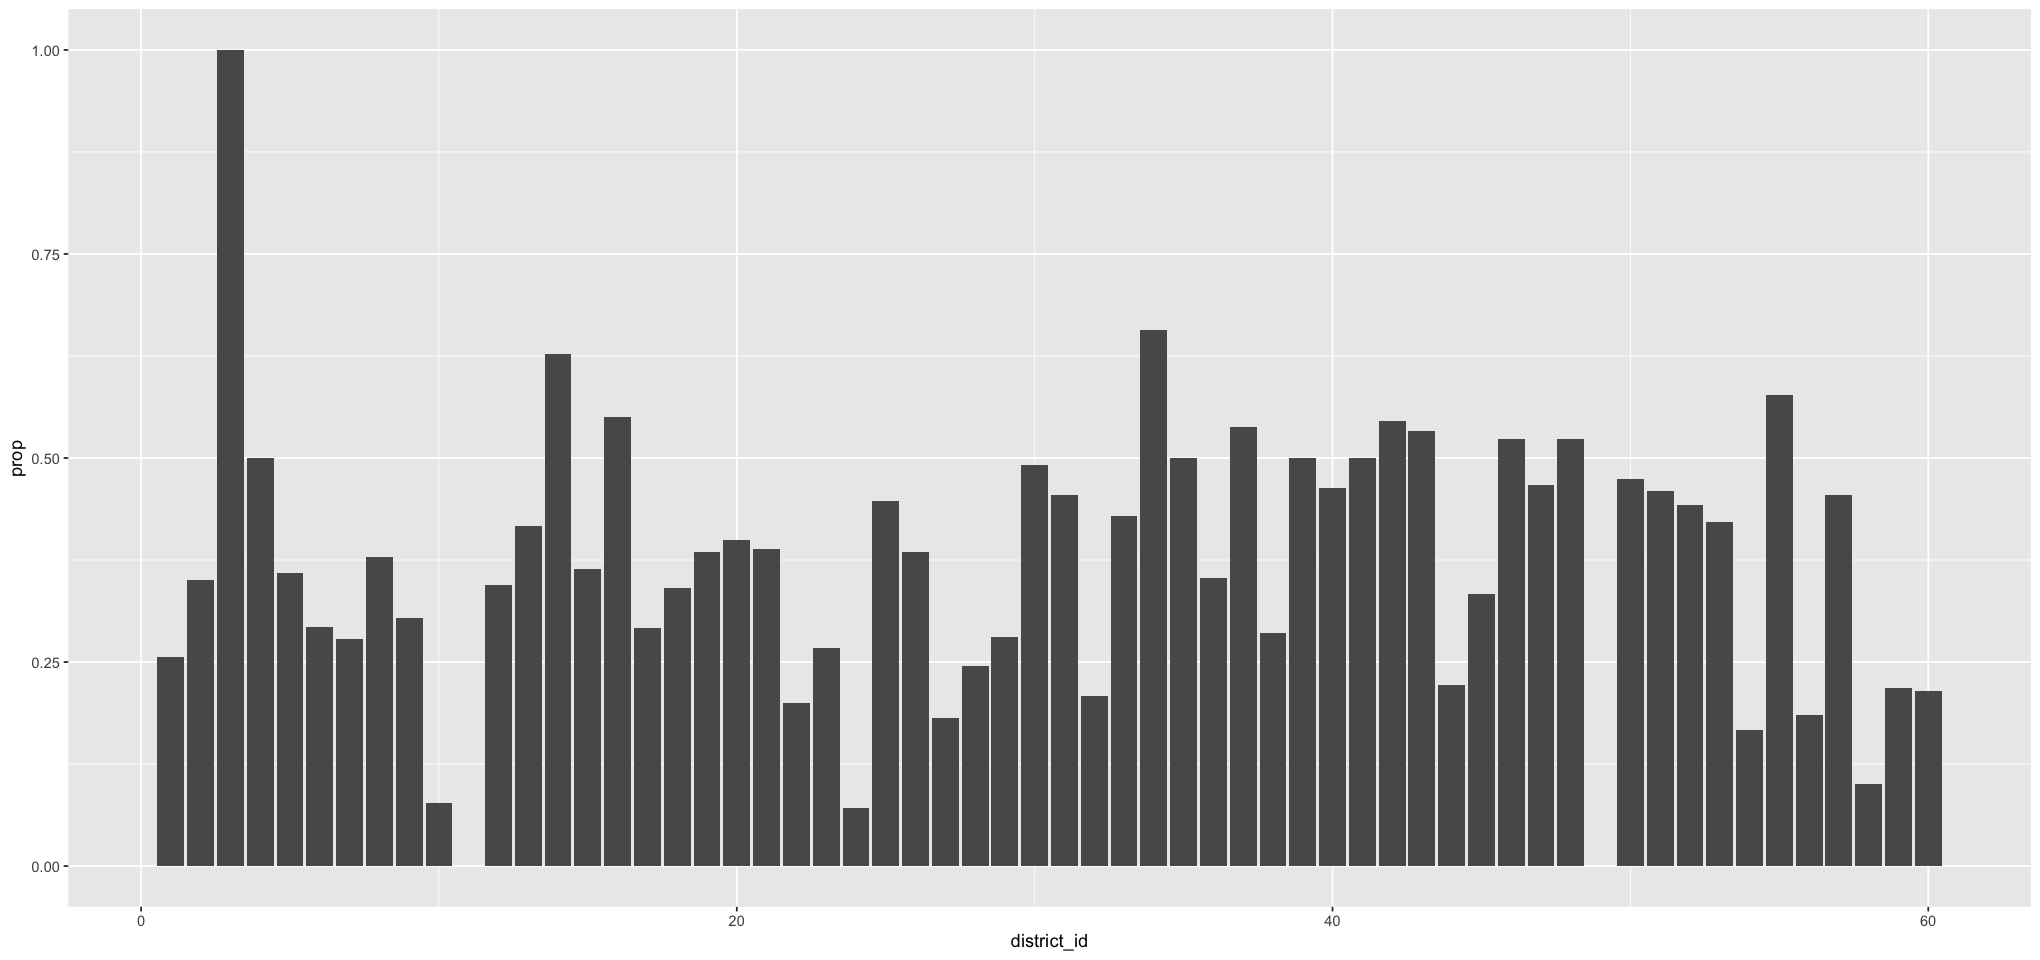

In [ ]:
ggplot(plot_df, aes(district_id, prop)) +
    geom_bar(stat = 'identity')

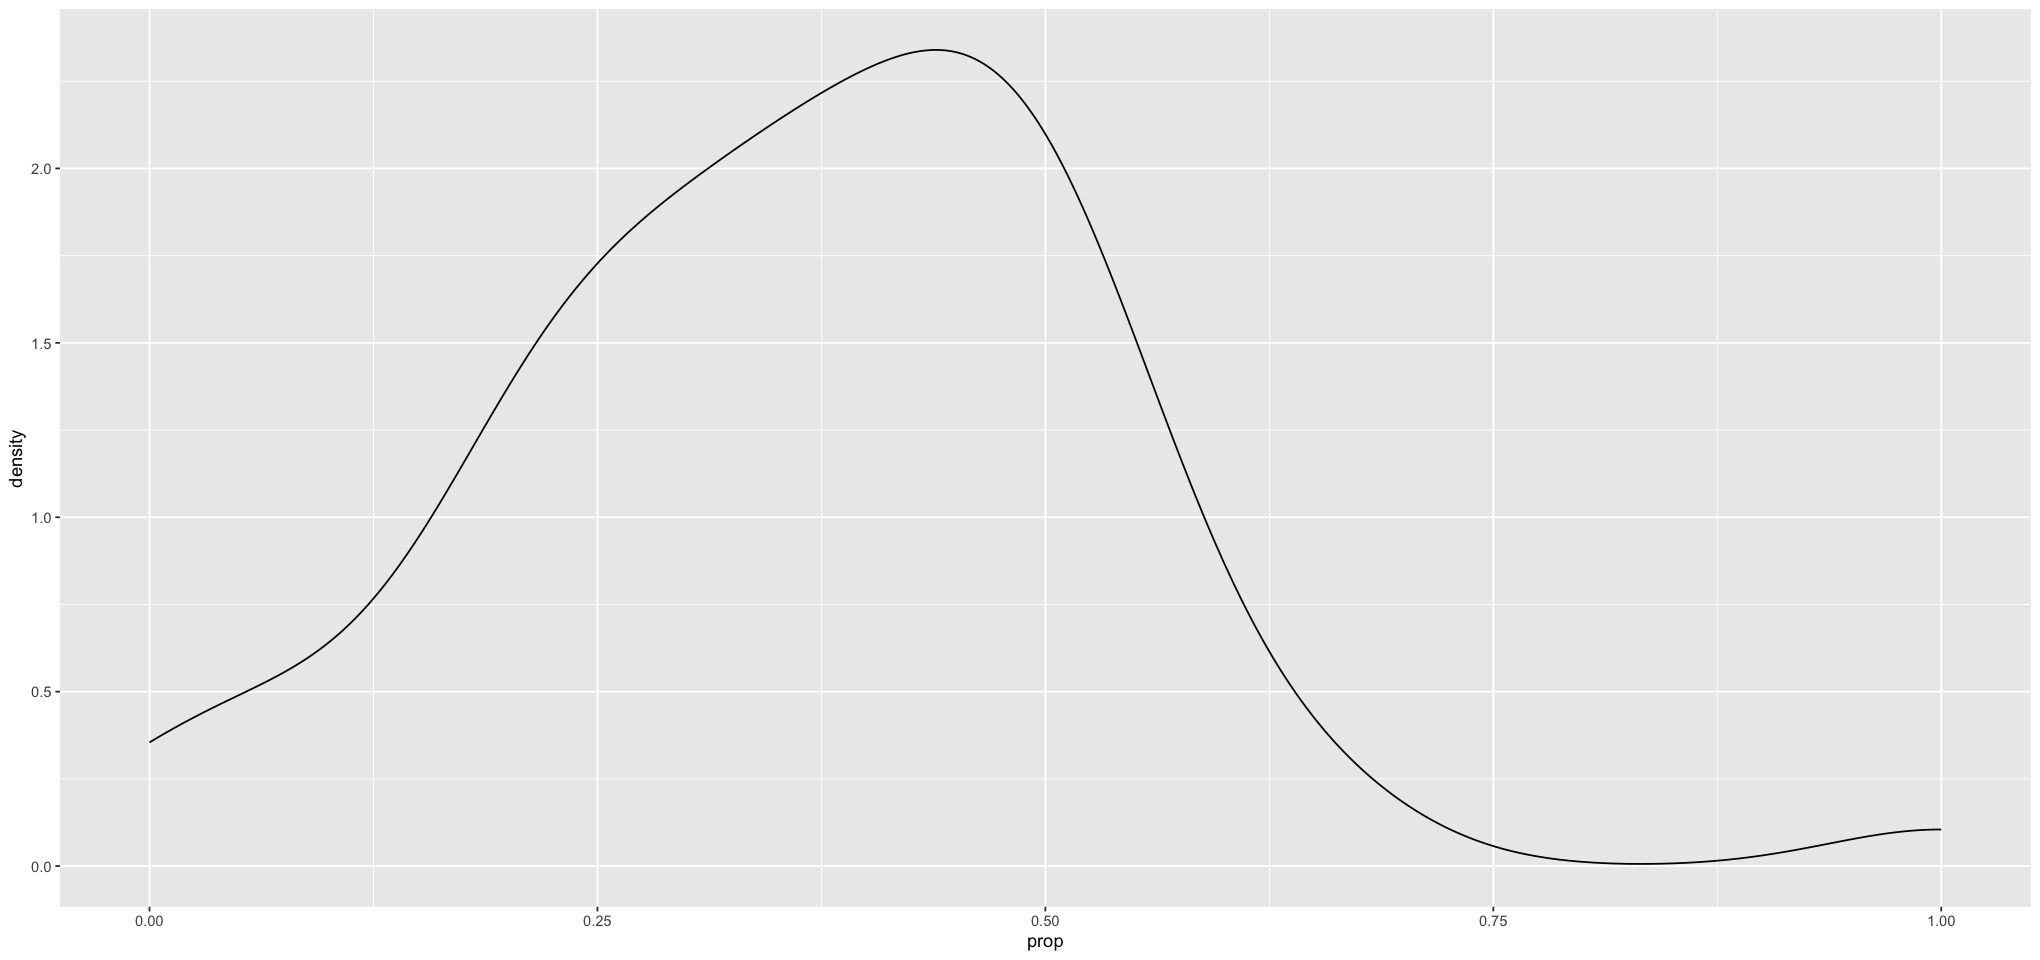

In [ ]:
ggplot(plot_df, aes(prop)) +
    geom_density()

For the fixed-effects model, I want a mean p of about 0.5 (from the above graph). That means that I want the inverse-logit of 0.5 as my prior mean for $\alpha$.

In [ ]:
inv_logit(0.5)

[1] 0.6224593

In [ ]:
districts <- sort(unique(d$district_id))
data <- data.frame(
    district_index = districts,
    n = sapply(districts, function (district_id) {nrow(d[d$district_id == district_id & d$use.contraception == 1, ])}), # number that use contraception
    N = sapply(districts, function(district_id) {nrow(d[d$district_id == district_id, ])})# total number
)
# first the fixed-effects model
m13h1.fixed <- ulam(
    alist(
        n ~ dbinom(N, p),
        logit(p) <- alpha[district_index],
        alpha[district_index] ~ dnorm(0.622, 1)
    ),
    data = data,
    chains = 4,
    log_lik = TRUE
)

# now the varying-effects model
m13h1.varying <- ulam(
    alist(
        n ~ dbinom(N, p),
        logit(p) <- alpha[district_index],
        alpha[district_index] ~ dnorm(alpha_bar, sigma),
        alpha_bar ~ dnorm(0.622, 1.5),
        sigma ~ dexp(1)
    ),
    data = data,
    chains = 4,
    log_lik = TRUE
)

Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

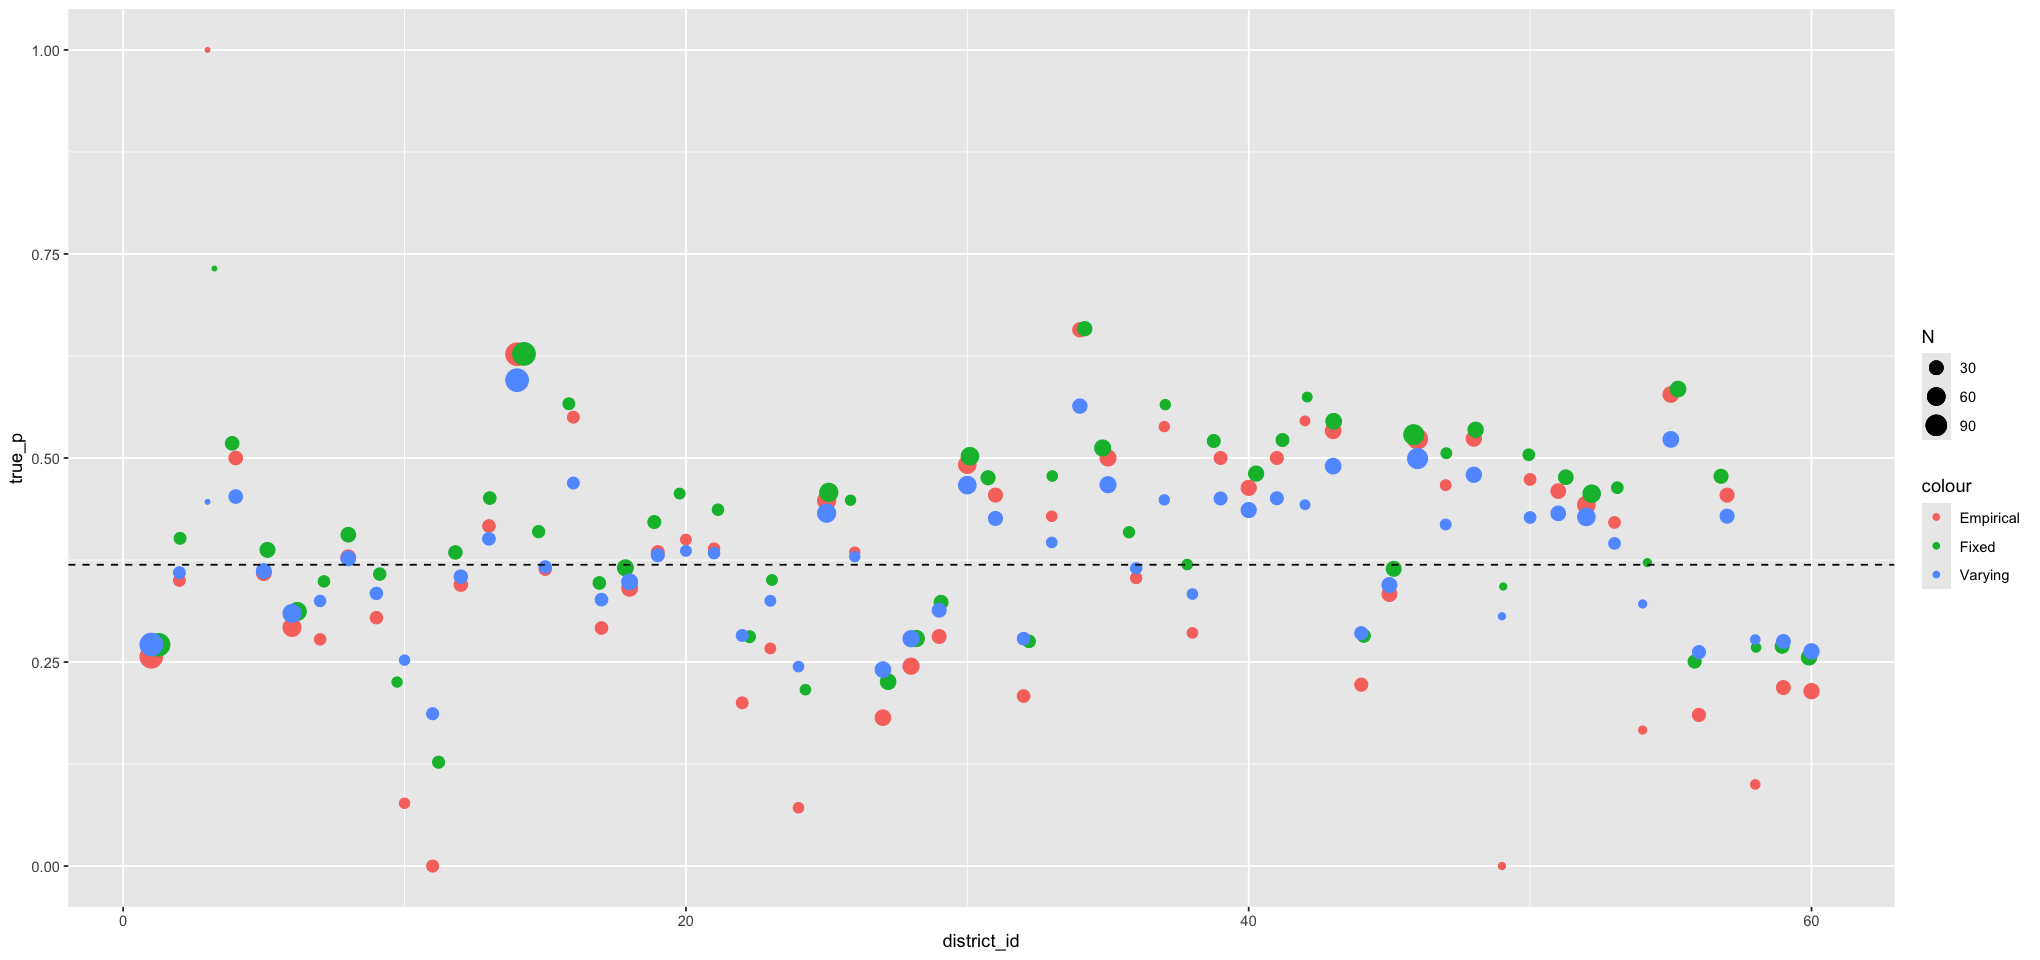

In [ ]:
fixed.samples.p <- extract.samples(m13h1.fixed)$p
varying.samples <- extract.samples(m13h1.varying)
varying.samples.p <- varying.samples$p

fixed.means <- apply(fixed.samples.p, 2, mean)
fixed.ci <- apply(fixed.samples.p, 2, PI)
varying.means <- apply(varying.samples.p, 2, mean)
varying.ci <- apply(varying.samples.p, 2, PI)

plot_df <- data.frame(
    district_id = districts,
    true_p = data$n / data$N,
    N = data$N,
    fixed_mean = fixed.means,
    fixed_lower = fixed.ci[1, ],
    fixed_upper = fixed.ci[2, ],
    varying_mean = varying.means,
    varying_lower = varying.ci[1, ],
    varying_upper = varying.ci[2, ]
)

ggplot(plot_df, aes(district_id, group = district_id)) +
    geom_point(aes(y = true_p, colour = "Empirical", size = N)) +
    geom_point(aes(y = fixed_mean, colour = "Fixed", size = N), position = position_jitter(width = 0.3)) +
    geom_point(aes(y = varying_mean, colour = "Varying", size = N), position = position_jitter(width = -0.3)) +
    geom_hline(aes(yintercept = mean(inv_logit(varying.samples$alpha_bar))), linetype = 'dashed') 
    

It's a little unclear what is going on - let's see what happens if we sort the districts by the empirical proportion using contraception.

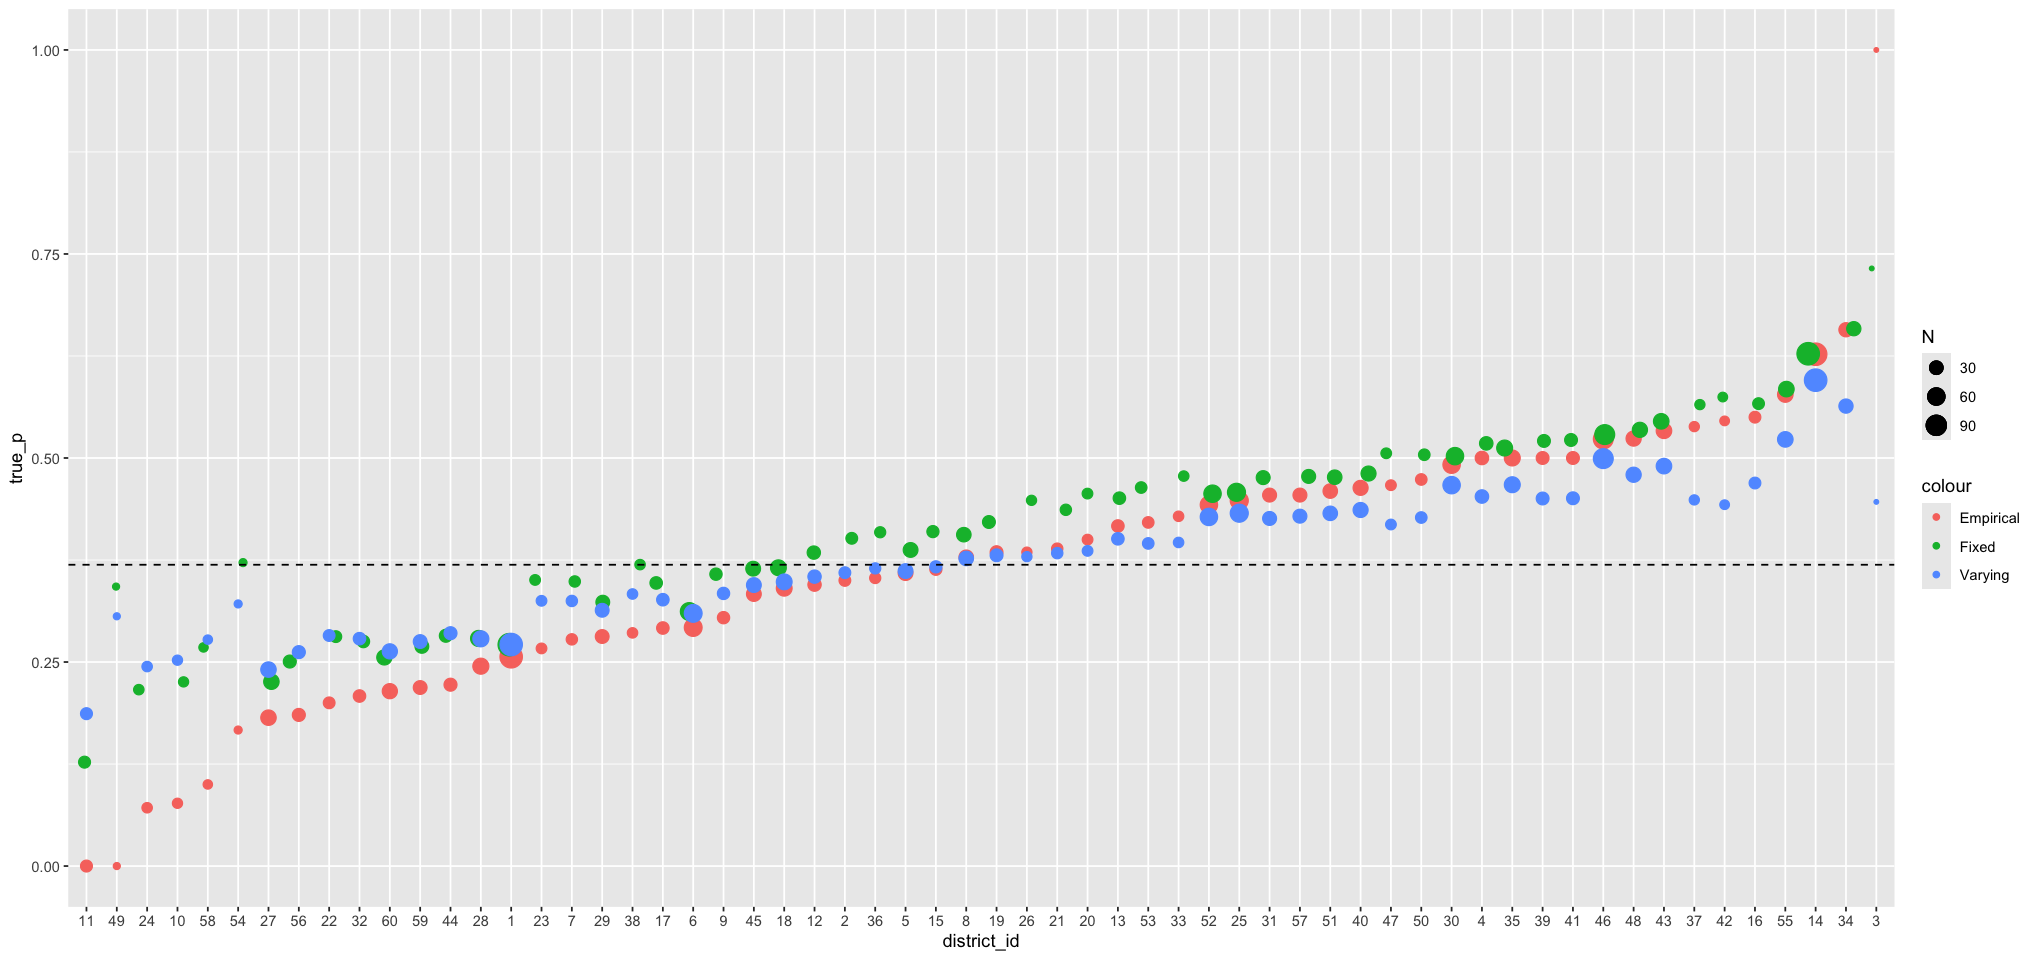

In [ ]:
ordered_by_p <- plot_df[order(plot_df$true_p), ]
ordered_by_p$district_id <- as.character(ordered_by_p$district_id)
district_levels <- unique(ordered_by_p$district_id)
ordered_by_p$district_id <- factor(ordered_by_p$district_id, levels = district_levels)

ggplot(ordered_by_p, aes(district_id, group = district_id)) +
    geom_point(aes(y = true_p, colour = "Empirical", size = N)) +
    geom_point(aes(y = fixed_mean, colour = "Fixed", size = N), position = position_jitter(width = 0.3)) +
    geom_point(aes(y = varying_mean, colour = "Varying", size = N), position = position_jitter(width = -0.3)) +
    geom_hline(aes(yintercept = mean(inv_logit(varying.samples$alpha_bar))), linetype = 'dashed') 

This makes things much clearer! Unsurprisingly, the varying effects model is 'shrinking' towards the adaptive mean $\bar\alpha$, a behaviour that is not shared by the fixed effects model. Thus, for districts where the empirical proportion is below $\bar\alpha$, the varying effects model is greater than the fixed one, and for districts where the empirical proportion is above $\bar\alpha$, the varying effects model is below the fixed one. 

Of course, this effect is ameliorated by the sample size, with a larger sample reducing the amount of shrinkage (again, as expected). Thus, districts 55 and 14 have similar empirical proportions, but the varying effects model for district 14 is closer to the empirical value (less shrinkage) because the sample size is larger.

**13H2** Return to `data(Trolley)` from [[Chapter 12]]. Define and fit a varying intercepts model for these data. Cluster intercepts on individual participants, as indicated by the unique values int he `id` variable. Include `action`, `intention`, and `contact` as ordinary terms. Compare the varying intercepts model and a model that ignores individuals, using both WAIC and posterior predictions. What is the impact of different stores on responses?

**Answer**

In [ ]:
data(Trolley)
d <- Trolley
head(d)

case  response order id     age male edu           action intention contact
1 cfaqu 4         2    96;434 14  0    Middle School 0      0         1      
2 cfbur 3        31    96;434 14  0    Middle School 0      0         1      
3 cfrub 4        16    96;434 14  0    Middle School 0      0         1      
4 cibox 3        32    96;434 14  0    Middle School 0      1         1      
5 cibur 3         4    96;434 14  0    Middle School 0      1         1      
6 cispe 3         9    96;434 14  0    Middle School 0      1         1      
  story action2
1 aqu   1      
2 bur   1      
3 rub   1      
4 box   1      
5 bur   1      
6 spe   1

In [ ]:
# This is the model from Chapter 12

data <- list(
    R = d$response,
    A = d$action,
    I = d$intention,
    C = d$contact
)

m13h2.fixed <- ulam(
    alist(
        R ~ dordlogit(phi, cutpoints),
        phi <- bA * A + bC * C + BI * I,
        BI <- bI + bIA * A + bIC * C,
        c(bA, bI, bC, bIA, bIC) ~ dnorm(0, 0.5),
        cutpoints ~ dnorm(0, 1.5)
    ),
    data = data,
    chains = 4,
    cores = 4,
    log_lik = TRUE
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4208.03, but should be greater than the previous element, -4208.03 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af1ecb2d7.stan', line 30, column 24 to column 70)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4208.93, but should be greater than the previous element, -4208.93 (in '/var/folders/86/1fgck35j5s9g7_

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3771.7, but should be greater than the previous element, -3771.7 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af1ecb2d7.stan', line 30, column 24 to column 70)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3771.49, but should be greater than the previous element, -3771.49 (in '/var/folders/86/1fgck35j5s9g7_r3

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3536.12, but should be greater than the previous element, -3536.12 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af1ecb2d7.stan', line 30, column 24 to column 70)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3536.83, but should be greater than the previous element, -3536.83 (in '/var/folders/86/1fgck35j5s9g7_

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -1906.31, but should be greater than the previous element, -1906.31 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af1ecb2d7.stan', line 30, column 24 to column 70)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -1904.24, but should be greater than the previous element, -1904.24 (in '/var/folders/86/1fgck35j5s9g7_

Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 500 / 1000 [ 50%]

In [ ]:
precis(m13h2.fixed, depth = 2)

mean       sd         5.5%       94.5%      rhat     ess_bulk 
bIC          -1.2358126 0.09183758 -1.3869636 -1.0861686 1.001730 1094.3345
bIA          -0.4335086 0.07666019 -0.5545407 -0.3127022 1.004693  936.2362
bC           -0.3437650 0.06719977 -0.4479615 -0.2310996 1.003108  979.1471
bI           -0.2917632 0.05528957 -0.3802125 -0.2009475 1.004477  862.4484
bA           -0.4724386 0.05325140 -0.5584403 -0.3876734 1.003063  836.2431
cutpoints[1] -2.6342119 0.05117753 -2.7129132 -2.5496661 1.004452  836.5497
cutpoints[2] -1.9377406 0.04689700 -2.0105842 -1.8613061 1.005366  827.6363
cutpoints[3] -1.3431283 0.04533751 -1.4151809 -1.2699200 1.004466  815.2432
cutpoints[4] -0.3082420 0.04272992 -0.3742277 -0.2394277 1.002906  943.7041
cutpoints[5]  0.3622611 0.04291723  0.2941860  0.4329410 1.006183  889.8002
cutpoints[6]  1.2684862 0.04527798  1.1961317  1.3441649 1.003377  969.2096

In [ ]:
# now we add in a new varying intercept
# first we need to convert the id into an index
d$user_index <- as.integer(factor(d$id, levels = unique(d$id)))
d$user_index

[1]   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
  [19]   1   1   1   1   1   1   1   1   1   1   1   1   2   2   2   2   2   2
  [37]   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
  [55]   2   2   2   2   2   2   3   3   3   3   3   3   3   3   3   3   3   3
  [73]   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3   3
  [91]   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4   4
 [109]   4   4   4   4   4   4   4   4   4   4   4   4   5   5   5   5   5   5
 [127]   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
 [145]   5   5   5   5   5   5   6   6   6   6   6   6   6   6   6   6   6   6
 [163]   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6
 [181]   7   7   7   7   7   7   7   7   7   7   7   7   7   7   7   7   7   7
 [199]   7   7   7   7   7   7   7   7   7   7   7   7   8   8   8   8   8   8
 [217]   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
 [235]   8   8   8   8   8   8   9   9   9   9   9   9   9   9   9   9   9   9
 [253]   9   9   9   9   9   9   9   9   9   9   9   9   9   9   9   9   9   9
 [271]  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10
 [289]  10  10  10  10  10  10  10  10  10  10  10  10  11  11  11  11  11  11
 [307]  11  11  11  11  11  11  11  11  11  11  11  11  11  11  11  11  11  11
 [325]  11  11  11  11  11  11  12  12  12  12  12  12  12  12  12  12  12  12
 [343]  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12  12
 [361]  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13  13
 [379]  13  13  13  13  13  13  13  13  13  13  13  13  14  14  14  14  14  14
 [397]  14  14  14  14  14  14  14  14  14  14  14  14  14  14  14  14  14  14
 [415]  14  14  14  14  14  14  15  15  15  15  15  15  15  15  15  15  15  15
 [433]  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
 [451]  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16  16
 [469]  16  16  16  16  16  16  16  16  16  16  16  16  17  17  17  17  17  17
 [487]  17  17  17  17  17  17  17  17  17  17  17  17  17  17  17  17  17  17
 [505]  17  17  17  17  17  17  18  18  18  18  18  18  18  18  18  18  18  18
 [523]  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18  18
 [541]  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19
 [559]  19  19  19  19  19  19  19  19  19  19  19  19  20  20  20  20  20  20
 [577]  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
 [595]  20  20  20  20  20  20  21  21  21  21  21  21  21  21  21  21  21  21
 [613]  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21  21
 [631]  22  22  22  22  22  22  22  22  22  22  22  22  22  22  22  22  22  22
 [649]  22  22  22  22  22  22  22  22  22  22  22  22  23  23  23  23  23  23
 [667]  23  23  23  23  23  23  23  23  23  23  23  23  23  23  23  23  23  23
 [685]  23  23  23  23  23  23  24  24  24  24  24  24  24  24  24  24  24  24
 [703]  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24
 [721]  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25  25
 [739]  25  25  25  25  25  25  25  25  25  25  25  25  26  26  26  26  26  26
 [757]  26  26  26  26  26  26  26  26  26  26  26  26  26  26  26  26  26  26
 [775]  26  26  26  26  26  26  27  27  27  27  27  27  27  27  27  27  27  27
 [793]  27  27  27  27  27  27  27  27  27  27  27  27  27  27  27  27  27  27
 [811]  28  28  28  28  28  28  28  28  28  28  28  28  28  28  28  28  28  28
 [829]  28  28  28  28  28  28  28  28  28  28  28  28  29  29  29  29  29  29
 [847]  29  29  29  29  29  29  29  29  29  29  29  29  29  29  29  29  29  29
 [865]  29  29  29  29  29  29  30  30  30  30  30  30  30  30  30  30  30  30
 [883]  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30  30
 [901]  31  31  31  31  31  31  31  31  31  31  31  3

In [ ]:

data <- list(
    R = d$response,
    A = d$action,
    I = d$intention,
    C = d$contact,
    user_index = d$user_index
)

m13h2.varying <- ulam(
    alist(
        R ~ dordlogit(phi, cutpoints),
        phi <- a[user_index] + bA * A + bC * C + BI * I,
        a[user_index] ~ dnorm(0, sigma_id),
        BI <- bI + bIA * A + bIC * C,
        c(bA, bI, bC, bIA, bIC) ~ dnorm(0, 0.5),
        cutpoints ~ dnorm(0, 1.5),
        sigma_id ~ dexp(1)
    ),
    data = data,
    chains = 4,
    cores = 4,
    log_lik = TRUE
)

Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3312.64, but should be greater than the previous element, -3312.64 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af4d525c9b.stan', line 35, column 24 to column 70)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3310.03, but should be greater than the previous element, -3310.03 (in '/var/folders/86/1fgck35j5s9g7

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -588.368, but should be greater than the previous element, -588.368 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af4d525c9b.stan', line 35, column 24 to column 70)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -589.049, but should be greater than the previous element, -589.049 (in '/var/folders/86/1fgck35j5s9g7

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4271.12, but should be greater than the previous element, -4271.12 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af4d525c9b.stan', line 35, column 24 to column 70)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -4272.47, but should be greater than the previous element, -4272.47 (in '/var/folders/86/1fgck35j5s9g7

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3449.55, but should be greater than the previous element, -3449.55 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af4d525c9b.stan', line 35, column 24 to column 70)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3445.86, but should be greater than the previous element, -3445.86 (in '/var/folders/86/1fgck35j5s9g7

Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 500 / 1000 [ 50%]

In [ ]:
pars <- c("bA", "bC", "bI")
print(precis(m13h2.fixed, depth = 2, pars = pars))
print(precis(m13h2.varying, depth = 2, pars = pars))

         mean         sd       5.5%      94.5%     rhat ess_bulk
bA -0.4724386 0.05325140 -0.5584403 -0.3876734 1.003063 836.2431
bC -0.3437650 0.06719977 -0.4479615 -0.2310996 1.003108 979.1471
bI -0.2917632 0.05528957 -0.3802125 -0.2009475 1.004477 862.4484
         mean         sd       5.5%      94.5%     rhat ess_bulk
bA -0.6488900 0.05658312 -0.7402288 -0.5631944 1.002245 1329.534
bC -0.4537379 0.06910934 -0.5666902 -0.3429041 1.001486 1506.711
bI -0.3842588 0.05897703 -0.4799357 -0.2917684 1.000902 1258.039


Even just looking at these parameters, we can see that there's a big difference! Adding in the user-specific parameter had a big effect.

In [ ]:
# TODO re-run the earlier models with log_lik = TRUE and then compare here
compare(m13h2.fixed, m13h2.varying)

WAIC     SE        dWAIC    dSE      pWAIC     weight
m13h2.varying 31058.68 179.36508    0.000       NA 356.63988 1     
m13h2.fixed   36929.22  80.72734 5870.542 173.5561  10.95863 0

So the varying effects model is quite a bit better; it turns out that the individuals taking part in the study have an important effect on the results!

**M13H3** The `Trolley` data are also clustered by `story`, which indicates a unique narrative for each vignette. Define and fit a cross-classifyied varying intercepts model with both `id` and `story`. Use the same ordinary terms as in the previous problem. Compare this model to the previous models. What do you inder about the impact of different stories on responses?

**Answer**

In [ ]:
data <- list(
    R = d$response,
    A = d$action,
    I = d$intention,
    C = d$contact,
    user_index = d$user_index,
    story_index = as.integer(factor(d$story, levels = unique(d$story)))
)

In [ ]:
# cross-classified model including the story
m13h3.varying <- ulam(
    alist(
        R ~ dordlogit(phi, cutpoints),
        phi <- a[user_index] + s[story_index] + bA * A + bC * C + BI * I,
        a[user_index] ~ dnorm(0, sigma_id),
        s[story_index] ~ dnorm(0, sigma_story),
        BI <- bI + bIA * A + bIC * C,
        c(bA, bI, bC, bIA, bIC) ~ dnorm(0, 0.5),
        cutpoints ~ dnorm(0, 1.5),
        sigma_id ~ dexp(1),
        sigma_story ~ dexp(1)
    ),
    data = data,
    chains = 4,
    cores = 4,
    log_lik = TRUE
)


Running MCMC with 4 parallel chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3315.25, but should be greater than the previous element, -3315.25 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af42b8025.stan', line 40, column 24 to column 70)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3316.02, but should be greater than the previous element, -3316.02 (in '/var/folders/86/1fgck35j5s9g7_

Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is 13.5627, but should be greater than the previous element, 13.5627 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af42b8025.stan', line 40, column 24 to column 70)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is 15.5869, but should be greater than the previous element, 15.5869 (in '/var/folders/86/1fgck35j5s9g7_r3_8

Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3394.1, but should be greater than the previous element, -3394.1 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af42b8025.stan', line 40, column 24 to column 70)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 

Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -3394.49, but should be greater than the previous element, -3394.49 (in '/var/folders/86/1fgck35j5s9g7_r3

Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 


Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2855.6, but should be greater than the previous element, -2855.6 (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpGot1mx/model-7af42b8025.stan', line 40, column 24 to column 70)

Chain 4 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 4 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 4 

Chain 4 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 4 Exception: ordered_logistic: Cut-points is not a valid ordered vector. The element at 2 is -2857.02, but should be greater than the previous element, -2857.02 (in '/var/folders/86/1fgck35j5s9g7_r3

Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 500 / 1000 [ 50%]

In [ ]:
params <- c("bC", "bI", "bA", "sigma_id", "sigma_story")
plot(coeftab(m13h2.fixed, m13h2.varying, m13h3.varying), pars = params)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'plot': object 'm13h2.fixed' not found


In [ ]:
compare(m13h2.fixed, m13h2.varying, m13h3.varying)

WAIC     SE        dWAIC     dSE       pWAIC     weight       
m13h3.varying 30569.40 180.32869    0.0000        NA 367.60062  1.000000e+00
m13h2.varying 31058.68 179.36508  489.2737  42.57966 356.63988 5.695835e-107
m13h2.fixed   36929.22  80.72734 6359.8160 175.28190  10.95863  0.000000e+00

So the one including the effect of the story is definitely doing better than the others.

In [ ]:
# let's take a look at the different sigmas
samples <- extract.samples(m13h3.varying)

$a
          [,1]     [,2]     [,3]      [,4]     [,5]     [,6]       [,7]    [,8]
[1,] -0.601756 -1.35244 -2.03348 -0.670158 -3.24273 0.357715 -0.5368740 3.70859
[2,] -0.590659 -1.14900 -3.16181 -0.136548 -3.54981 1.000510 -0.2995760 4.49389
[3,] -0.517140 -1.27364 -3.05657  0.151048 -3.58014 1.006730 -0.4196320 4.41978
[4,] -0.374961 -1.69828 -2.70519 -0.539763 -3.16441 0.768989  0.2061810 3.98343
[5,] -0.240082 -1.12346 -3.18192 -0.115529 -4.40930 0.951738 -0.5079980 4.74511
[6,] -0.668418 -2.03437 -2.65763 -0.507477 -2.50623 0.578492 -0.0382749 3.44395
          [,9]    [,10]    [,11]   [,12]     [,13]     [,14]   [,15]    [,16]
[1,] -0.875990 0.283774 0.919136 2.73227 -0.321063 -0.871343 1.78521 -1.26792
[2,] -0.600569 1.021550 1.213070 2.08246 -0.372380 -0.980525 1.95434 -1.50456
[3,] -0.582784 0.904467 1.001040 2.27371 -0.408925 -0.979267 1.83489 -1.66243
[4,] -1.166940 0.972252 0.845818 3.03929 -0.033924 -0.969036 1.99437 -2.38572
[5,] -0.689229 1.045130 0.960447 2.73630 -0.443848 -0.646954 1.80883 -1.13496
[6,] -0.808105 0.814914 0.425893 2.37945 -0.222978 -1.074330 2.08165 -2.49405
       [,17]     [,18]     [,19]     [,20]    [,21]      [,22]    [,23]
[1,] 1.71254 -0.107117 -1.466760 -0.183868 -1.93750 -0.0302896 -5.53530
[2,] 2.45480 -1.873110 -0.925218 -0.620259 -2.03925 -0.0520255 -4.87274
[3,] 2.40754 -1.721030 -1.293010 -0.312980 -1.95101  0.0989885 -5.09300
[4,] 1.61311 -0.586978 -1.241420 -0.509178 -1.88522  0.8973720 -5.02956
[5,] 2.59829 -1.066060 -0.902434 -0.635427 -2.17035 -0.5264680 -5.10004
[6,] 0.92027 -1.065250 -1.623430 -0.346722 -2.01769  0.7903350 -6.50439
        [,24]     [,25]    [,26]    [,27]     [,28]    [,29]   [,30]   [,31]
[1,] -1.70303 -0.619572 1.204190 1.622670 -0.707928 1.115080 1.42744 4.00579
[2,] -1.88230 -0.871167 1.046330 0.903739 -0.932974 1.606220 2.40718 3.71489
[3,] -2.05157 -0.854771 1.124940 0.850760 -1.187160 1.526720 2.38876 3.64712
[4,] -1.20647 -0.361387 1.006050 1.711750 -0.444665 0.633652 1.54854 4.73210
[5,] -2.17501 -0.964902 1.239440 0.724252 -0.611989 2.093420 1.89379 3.61912
[6,] -1.11498 -0.236109 0.887317 1.767820 -0.818612 0.575342 1.80180 4.42074
         [,32]      [,33]    [,34]   [,35]   [,36]    [,37]    [,38]   [,39]
[1,] -0.604146  0.0659269 -1.52039 1.88104 1.68361 1.069230 0.816966 1.60722
[2,] -0.592063 -0.4604430 -1.70978 1.39006 1.99945 1.568980 0.506391 1.20698
[3,] -0.429677 -0.3348170 -1.56197 1.57667 1.79180 1.890850 0.687331 1.31037
[4,] -1.051830  0.1979170 -2.22225 1.52633 1.39968 0.897152 0.881132 1.77372
[5,] -0.377184 -0.3564910 -1.48549 1.65417 2.71763 1.235760 0.991471 1.02302
[6,] -0.825663  0.2142390 -2.28956 1.47088 0.90066 1.293260 0.582254 1.76418
       [,40]     [,41]   [,42]   [,43]      [,44]    [,45]   [,46]   [,47]
[1,] 1.74773 -1.073060 2.08987 1.78910  0.4408440 0.763188 2.48532 1.88801
[2,] 1.17329 -0.150850 1.64890 1.82090  0.3610720 1.235220 1.90227 2.07124
[3,] 1.41944 -0.225728 1.77557 1.99269  0.4420850 1.252640 1.94508 2.20273
[4,] 2.05729 -0.670630 2.20085 1.76047 -0.0144729 0.592756 2.55226 2.32431
[5,] 1.21019 -0.994015 2.04022 2.17270  0.7724680 0.610024 1.65757 2.05966
[6,] 1.58594 -0.461102 1.65153 1.72402 -0.0847018 1.093550 2.74475 2.40838
       [,48]    [,49]    [,50]      [,51]    [,52]    [,53]     [,54]   [,55]
[1,] 2.91263 -2.57000 1.602010  0.0243573 1.223050 -3.04618 -0.776967 2.56182
[2,] 2.27198 -1.79880 1.105880 -0.6386410 0.488636 -2.02863 -0.157849 2.05405
[3,] 2.28962 -1.86324 1.170480 -0.6962300 0.509655 -1.90629 -0.265028 2.22850
[4,] 2.85014 -2.16533 1.634670  0.2713830 1.331770 -2.44285 -0.392145 1.99602
[5,] 2.06816 -1.94688 0.580955 -0.8551920 0.427741 -2.47554 -1.064900 2.33789
[6,] 3.01670 -2.00166 2.111020  0.5696210 1.044030 -2.29646  0.219629 2.05445
       [,56]     [,57]    [,58]    [,59]     [,60]     [,61]    [,62]    [,63]
[1,] 4.78756 -0.129903 -1.80171 -2.89124 -1.326480 -1.145260 0.395263 -1.42608
[2,] 2.65365 -0.466184 -1.33893 -2.83357 -1.077520 -1.744220 0.573634 -2.19303
[

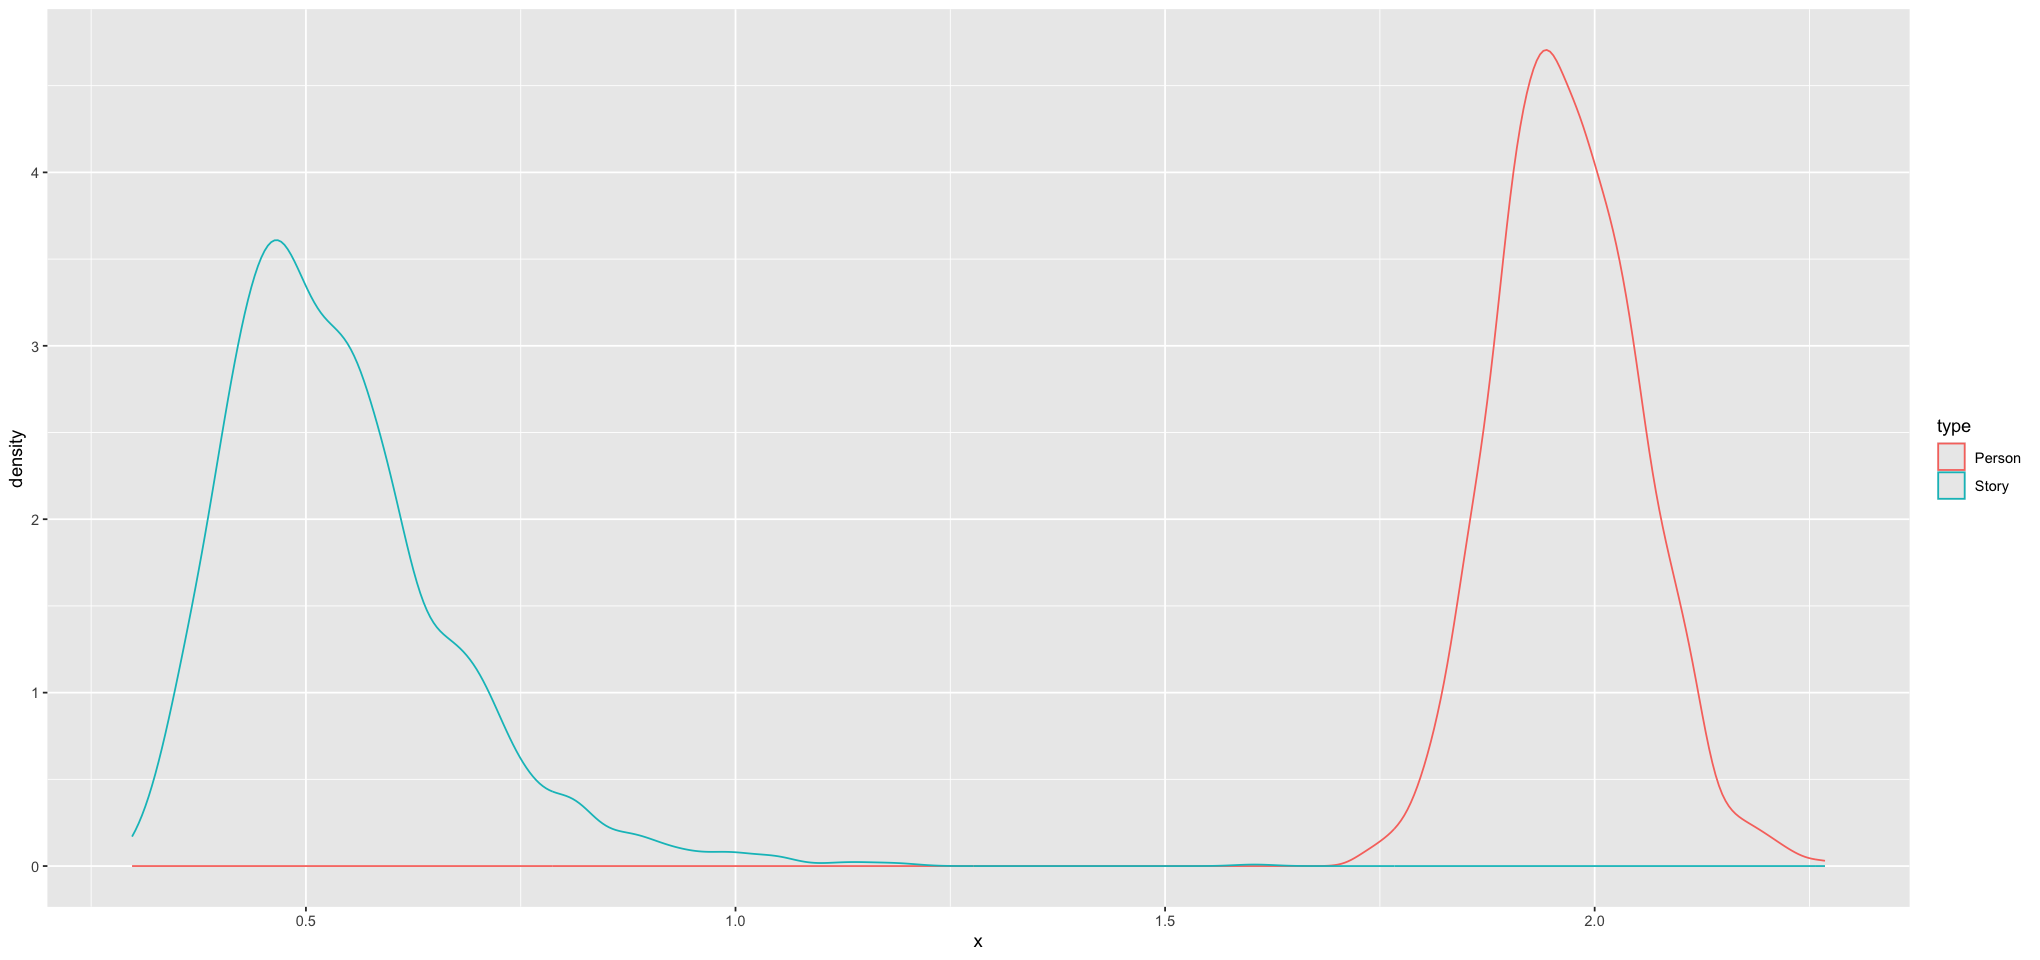

In [ ]:
plot_df <- rbind(
    data.frame(x = samples$sigma_id, type = "Person"),
    data.frame(x = samples$sigma_story, type = "Story")
)

ggplot(plot_df, aes(x, colour = type)) +
    geom_density()

Interesting! So it looks like there is much more variability in the people than in the stories! That is, while including the story effect is important, different people tend to react relatively the same to each different story. This is especially interesting because we separately pull out the I, A, and C components, so there's something about the different stories that is having an effect (albeit not a huge one) *over and above* the components that we're interested in.

**13H4** Revisit the Reed frog survival data, `data(reedFrogs)`, and add the `predation` and `size` treatment variables to the varying intercepts model. Consider models with either predictor alone, both predictors, as well as a model including their interaction. What do you infer about the causal influense of these predictor variables? Also focus on the inferred variation across tanks (the $\sigma$ across tanks). Explain why it changes as it does across models with different predictors included. 

**Answer** This is largely the same as 13M1, but now we're focusing on the causal influence rather than just the variation. We'll run the models again and take a look at some data.

In [ ]:
data(reedfrogs)
d <- reedfrogs
d$tank <- 1:nrow(d)
d$pred_index <- ifelse(d$pred == 'no', 1L, 2L)
d$size_index <- ifelse(d$size == 'small', 1L, 2L)
d$pred_size_index <- 2 * (d$pred_index - 1) + (d$size_index - 1) + 1

data <- list(
    S = d$surv,
    N = d$density,
    tank = d$tank,
    pred_index = d$pred_index,
    size_index = d$size_index,
    pred_size_index = d$pred_size_index
)

In [ ]:
m13h4.base <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1)
    ),
    data = data,
    chains = 4,
    log_lik = TRUE
)

# predation
m13h4.pred <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank] + b[pred_index],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1),
        b[pred_index] ~ dnorm(0, 1.5)
    ),
    data = data,
    chains = 4,
    log_lik = TRUE
)

# size
m13h4.size <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank] + g[size_index],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1),
        g[size_index] ~ dnorm(0, 1.5)
    ),
    data = data,
    chains = 4,
    log_lik = TRUE
)

# predation and size (no interaction)
m13h4.pred_size_no_interaction <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank] + b[pred_index] + g[size_index],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1),
        b[pred_index] ~ dnorm(0, 1.5),
        g[size_index] ~ dnorm(0, 1.5)
    ),
    data = data,
    chains = 4,
    log_lik = TRUE
)

# predation and size (interaction)
m13h4.pred_size_interaction <- ulam(
    alist(
        S ~ dbinom(N, p),
        logit(p) <- a[tank] + b[pred_index] + g[size_index] + e[pred_size_index],
        a[tank] ~ dnorm(a_bar, sigma),
        a_bar ~ dnorm(0, 1.5),
        sigma ~ dexp(1),
        b[pred_index] ~ dnorm(0, 1.5),
        g[size_index] ~ dnorm(0, 1.5),
        e[pred_size_index] ~ dnorm(0, 1.5)
    ),
    data = data,
    chains = 4,
    log_lik = TRUE
)


Running MCMC with 4 sequential chains, with 1 thread(s) per chain...

Chain 1 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 1 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 1 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 1 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.1 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 5

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpEjYFfx/model-89855c0f70cb.stan', line 20, column 4 to column 32)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.2 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.1 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpEjYFfx/model-89855c0f70cb.stan', line 20, column 4 to column 32)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 0.2 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 4 finished in 0.1 seconds.

All 4 chains finished successfully.
Mean chain execution time: 0.2 seconds.
Total execution time: 1.0 seconds.

Running MCMC with 4 sequential 

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpEjYFfx/model-89856865d913.stan', line 20, column 4 to column 32)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.3 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpEjYFfx/model-89856865d913.stan', line 20, column 4 to column 32)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.2 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 0.2 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup)

Chain 1 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 1 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpEjYFfx/model-898535d804d.stan', line 22, column 4 to column 32)

Chain 1 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 1 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 1 



Chain 1 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 1 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 1 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 1 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 1 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 1 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 1 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 1 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 1 finished in 0.3 seconds.
Chain 2 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 2 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 


Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpEjYFfx/model-898535d804d.stan', line 22, column 4 to column 32)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.3 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 


Chain 3 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 3 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpEjYFfx/model-898535d804d.stan', line 22, column 4 to column 32)

Chain 3 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 3 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 3 



Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 3 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 3 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 3 finished in 0.4 seconds.
Chain 4 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 4 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 4 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 4 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 4 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 4 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 4 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 4 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 4 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 4 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 4 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 4 Iteration: 1000 / 1000 [

Chain 2 Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Chain 2 Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/var/folders/86/1fgck35j5s9g7_r3_8y8txcc0000gn/T/RtmpEjYFfx/model-89857059ceb1.stan', line 24, column 4 to column 32)

Chain 2 If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Chain 2 but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Chain 2 



Chain 2 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 2 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 2 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 2 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 2 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 2 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 2 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 2 Iteration: 800 / 1000 [ 80%]  (Sampling) 
Chain 2 Iteration: 900 / 1000 [ 90%]  (Sampling) 
Chain 2 Iteration: 1000 / 1000 [100%]  (Sampling) 
Chain 2 finished in 0.5 seconds.
Chain 3 Iteration:   1 / 1000 [  0%]  (Warmup) 
Chain 3 Iteration: 100 / 1000 [ 10%]  (Warmup) 
Chain 3 Iteration: 200 / 1000 [ 20%]  (Warmup) 
Chain 3 Iteration: 300 / 1000 [ 30%]  (Warmup) 
Chain 3 Iteration: 400 / 1000 [ 40%]  (Warmup) 
Chain 3 Iteration: 500 / 1000 [ 50%]  (Warmup) 
Chain 3 Iteration: 501 / 1000 [ 50%]  (Sampling) 
Chain 3 Iteration: 600 / 1000 [ 60%]  (Sampling) 
Chain 3 Iteration: 700 / 1000 [ 70%]  (Sampling) 
Chain 3 Iteration: 800 / 1000 [ 80%]

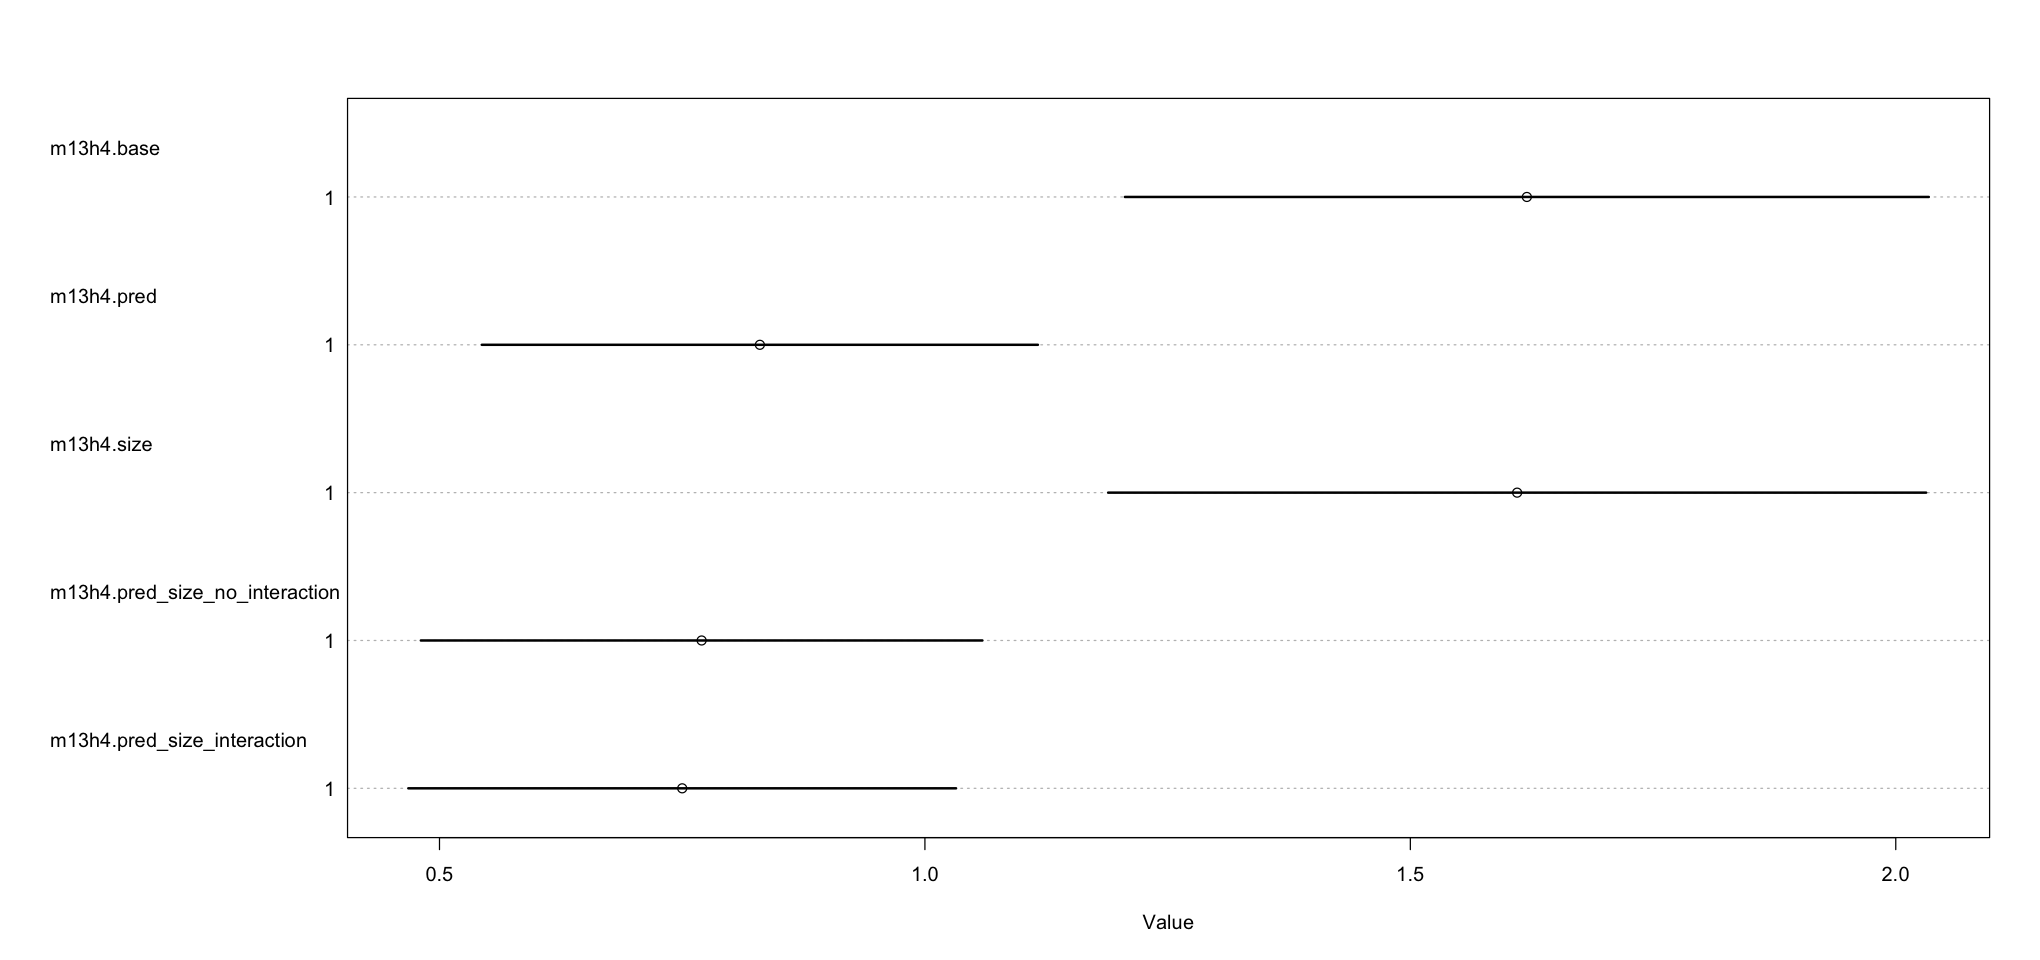

In [ ]:
par(bg = 'white')
params <- c('sigma')
plot(coeftab(m13h4.base, m13h4.pred, m13h4.size, m13h4.pred_size_no_interaction, m13h4.pred_size_interaction), pars = params)

In [ ]:
compare(m13h4.base, m13h4.pred, m13h4.size, m13h4.pred_size_no_interaction, m13h4.pred_size_interaction)

WAIC     SE       dWAIC     dSE      pWAIC   
m13h4.base                     199.0502 7.350988 0.0000000       NA 20.42246
m13h4.pred                     199.4221 9.179128 0.3719159 5.759817 19.31676
m13h4.pred_size_no_interaction 200.0441 8.973249 0.9938571 6.157536 19.16602
m13h4.pred_size_interaction    200.1870 9.670286 1.1368335 6.891638 19.27705
m13h4.size                     201.3463 7.253817 2.2961013 1.307723 21.37179
                               weight    
m13h4.base                     0.30098895
m13h4.pred                     0.24991369
m13h4.pred_size_no_interaction 0.18312061
m13h4.pred_size_interaction    0.17048662
m13h4.size                     0.09549013

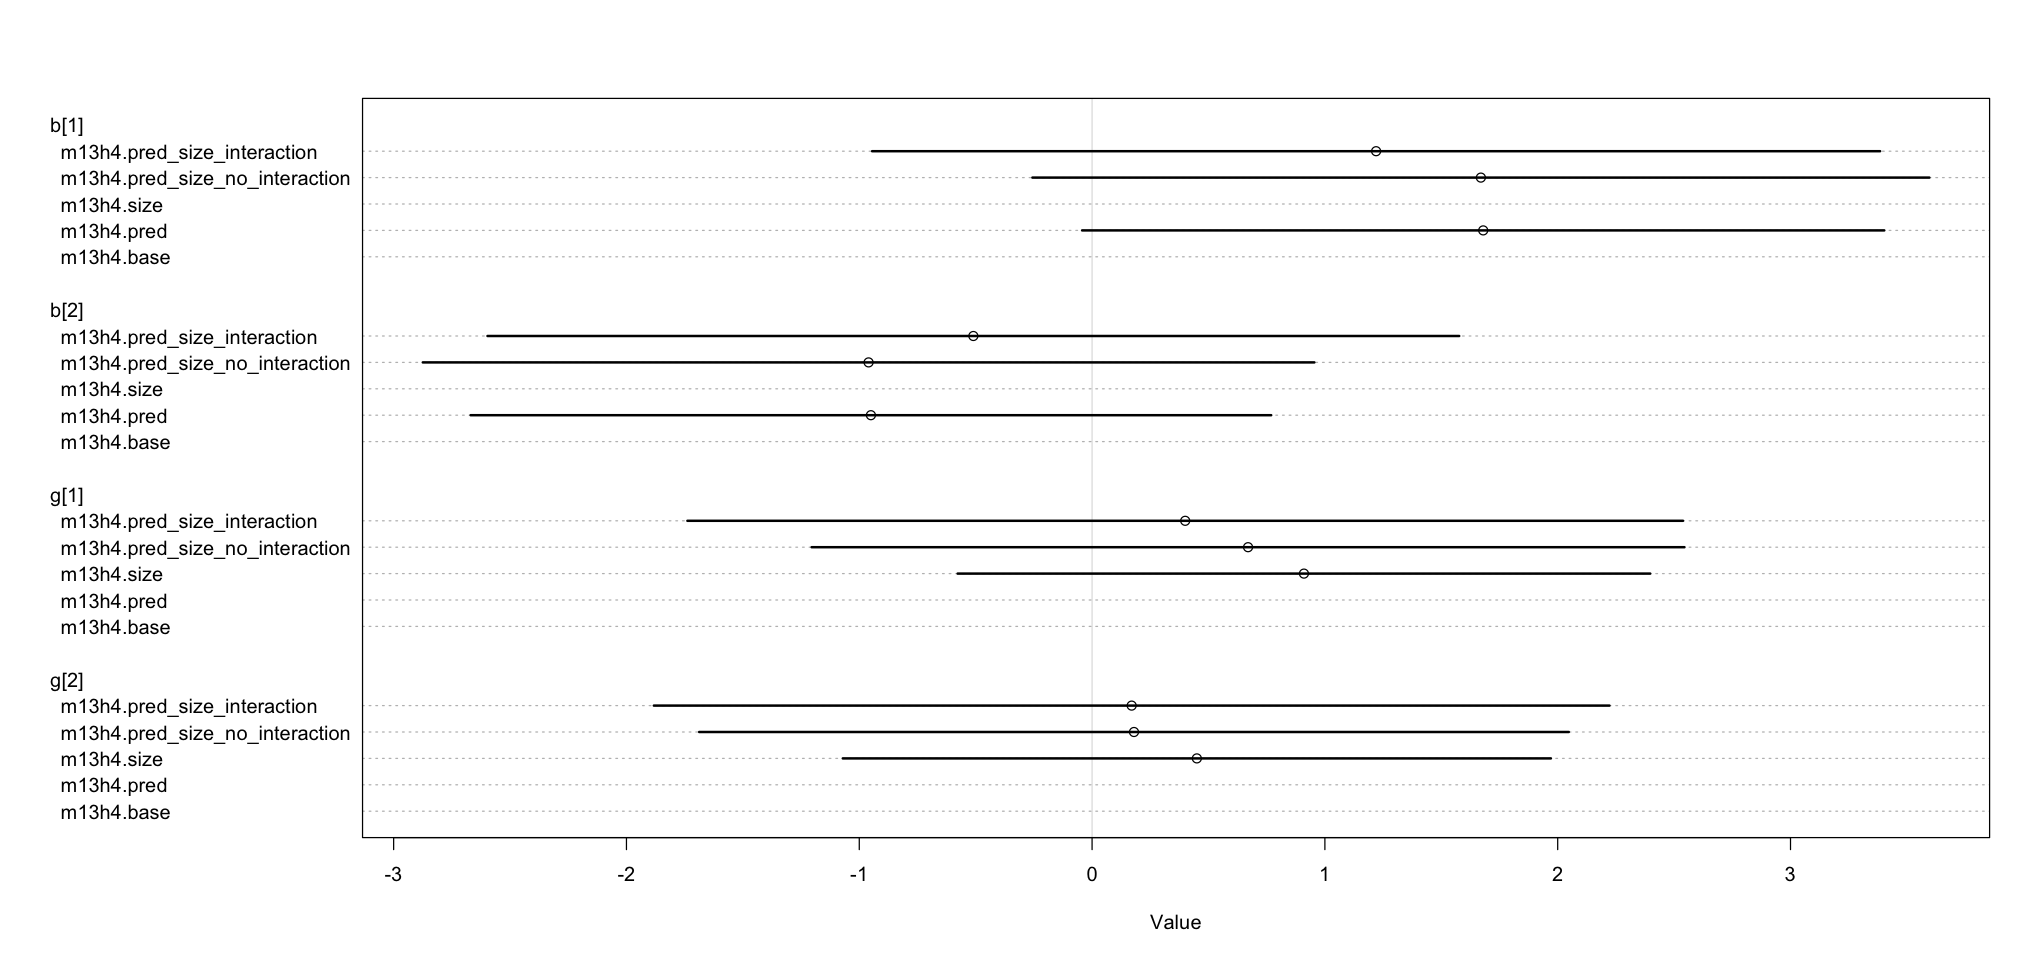

In [ ]:
par(bg = 'white')
params <- c('b[1]', 'b[2]', 'g[1]', 'g[2]')
plot(coeftab(m13h4.base, m13h4.pred, m13h4.size, m13h4.pred_size_no_interaction, m13h4.pred_size_interaction), pars = params)

All of these models do roughly as good a job, regardless of the variables that we include. From this, is looks like the individual variation in the tanks is the most important causal variable, followed by the inclusion of predation (although with only a small effect). The size of the tank seems to have very little effect on the outcome.